In [ ]:
!pip install pingouin
!pip install scipy
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#1.EDA - 전체 데이터의 흐름을 통한 인사이트 발견

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import datetime as dt
import seaborn as sns
import numpy as np
from mlxtend.frequent_patterns import association_rules, apriori
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import math
import warnings
warnings.filterwarnings("ignore")

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False
pd.set_option('display.max_columns',None)
pd.set_option('display.max_row',None)
import matplotlib.pyplot as plt

### **1-0) 데이터 불러오기**

In [3]:
df_on = pd.read_csv('/content/drive/MyDrive/유나다 코드 정리/이커머스/Onlinesales_info.csv')
df_cus = pd.read_csv('/content/drive/MyDrive/유나다 코드 정리/이커머스/Customer_info.csv')
df_dis = pd.read_csv('/content/drive/MyDrive/유나다 코드 정리/이커머스/Discount_info.csv')
df_mar = pd.read_csv('/content/drive/MyDrive/유나다 코드 정리/이커머스/Marketing_info.csv')
df_tax = pd.read_csv('/content/drive/MyDrive/유나다 코드 정리/이커머스/Tax_info.csv')
df_on['거래날짜'] = pd.to_datetime(df_on['거래날짜'])

### **1-1) eda에 사용할 지표및 알고리즘 만들기**

> EDA 및 분석을 하는 과정에 있어서 유효한 지표와 알고리즘을 통해 데이터를 해석하는 것이 더 설득력 있다고 판단했기 때문에 고객 생애 가치(CLV), ARPPU, retention, 장바구니 분석을 지표로 채택 하여 사용하였다.

※고객 생애 가치를 사용하여 해석하는 경우, 이상치고객이 그룹에 속해있다는 것만으로, 결과가 편향되어 있을 것으로 판단하여 해당 부분에서만 이상치를 제거하고 진행하였다. (기준: 수량 <= 300 & 평균금액<=279)

#### **1-1-1) 고객생애가치 (CLV)**

CLV는 계산 방법은 아래와 같다.

* 고객 가치 = 평균 구매 가치 × 평균 구매 빈도
  * 평균 구매 가치 = 특정 기간 내 총 수익 / 특정 기간 내 총 구매 횟수
* **CLV = 고객 가치 × 고객 평균 유지 기간**\
(여기서, 고객 평균 유지 기간은 `Online Sales_info`의 `가입기간`을 활용하여 산출.)



In [4]:
clv = df_on.groupby('고객ID').agg({'평균금액': 'sum', '고객ID': 'count'}).rename(columns={'평균금액': '총구매금액', '고객ID': '구매횟수'})
clv['평균구매금액'] = clv['총구매금액'] / clv['구매횟수']
# 2019년 1년간의 구매데이터이기 때문에 평균구매빈도를 구하기 위해서 구매횟수에서 일수를 나눠주기
clv['평균구매빈도'] = clv['구매횟수']/365
clv = pd.merge(df_cus, clv, on='고객ID', how='outer')
#가입기간을 년 단위로 바꿔주기
clv['가입기간'] = clv['가입기간']/12

#고객ID별로 고객생애가치 컬럼 추가
clv['고객생애가치'] = clv['가입기간']*clv['평균구매금액']*clv['평균구매빈도']
clv.head(3)

,고객ID,성별,고객지역,가입기간,총구매금액,구매횟수,평균구매금액,평균구매빈도,고객생애가치
0,USER_1358,남,Chicago,1.000000,20483.98,297,68.969630,0.813699,56.120493
1,USER_0190,남,California,3.583333,2320.33,44,52.734773,0.120548,22.779495
2,USER_0066,남,Chicago,2.750000,1319.79,42,31.423571,0.115068,9.943623


In [5]:
# Onlinesales_info.csv에 고객생애가치를 위한 파생변수 추가
df_on = pd.merge(df_on, clv[['고객ID','총구매금액','구매횟수','평균구매금액','평균구매빈도','고객생애가치']], on='고객ID', how='outer')
df_on.head(3)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,총구매금액,구매횟수,평균구매금액,평균구매빈도,고객생애가치
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,20483.98,297,68.96963,0.813699,56.120493


#### **1-1-2) retention**

In [6]:
#전체 코드 돌리고 retention 함수만 선언해서 사용하면 됨.
#월별 코호트

import datetime as dt
#string에서 datetime형으로 변경


def get_month(x) : return dt.datetime(x.year,x.month,1)

def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day

def retention_m(df_on): #df이름 삽입
  df_on['거래날짜']=pd.to_datetime(df_on['거래날짜'])
  df_on['거래날짜달기준'] = df_on['거래날짜'].apply(get_month)
  grouping = df_on.groupby('고객ID')['거래날짜달기준']
  df_on['최초거래날짜'] = grouping.transform('min')

  invoice_year,invoice_month,_ = get_month_int(df_on,'거래날짜달기준')
  cohort_year,cohort_month,_ = get_month_int(df_on,'최초거래날짜')

  year_diff = invoice_year - cohort_year
  month_diff = invoice_month - cohort_month

  df_on['최초구매일로부터달'] = year_diff * 12 + month_diff +1
  #Count monthly active customers from each cohort
  grouping = df_on.groupby(['최초거래날짜', '최초구매일로부터달'])
  cohort_data = grouping['고객ID'].apply(pd.Series.nunique)
  # Return number of unique elements in the object.
  cohort_data = cohort_data.reset_index()
  cohort_counts = cohort_data.pivot(index='최초거래날짜',columns='최초구매일로부터달',values='고객ID')
  # Retention table
  cohort_size = cohort_counts.iloc[:,0]
  retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis
  #retention.round(3) * 100 #to show the number as percentage

  return retention.round(3) * 100

In [7]:
#df넣으면 카테고리별/최초구입날짜별 cohort 생성
#카테고리별로 retention_df 생성

def cat_mon(df_on): #df_on자리에 나눠준 cohort(loc)데이터프레임 넣어주면 맞춰서 카테고리별 값 산출
  import pandas as pd
  a=df_on.loc[df_on['제품카테고리']=='Nest-USA']
  b=df_on.loc[df_on['제품카테고리']=='Office']
  c=df_on.loc[df_on['제품카테고리']=='Apparel']
  d=df_on.loc[df_on['제품카테고리']=='Bags']
  e=df_on.loc[df_on['제품카테고리']=='Drinkware']
  f=df_on.loc[df_on['제품카테고리']=='Lifestyle']
  g=df_on.loc[df_on['제품카테고리']=='Notebooks & Journals']
  h=df_on.loc[df_on['제품카테고리']=='Headgear']
  i=df_on.loc[df_on['제품카테고리']=='Waze']
  j=df_on.loc[df_on['제품카테고리']=='Fun']
  k=df_on.loc[df_on['제품카테고리']=='Nest-Canada']
  l=df_on.loc[df_on['제품카테고리']=='Backpacks']
  m=df_on.loc[df_on['제품카테고리']=='Google']
  n=df_on.loc[df_on['제품카테고리']=='Bottles']
  o=df_on.loc[df_on['제품카테고리']=='Gift Cards']
  p=df_on.loc[df_on['제품카테고리']=='More Bags']
  q=df_on.loc[df_on['제품카테고리']=='Housewares']
  r=df_on.loc[df_on['제품카테고리']=='Android']
  s=df_on.loc[df_on['제품카테고리']=='Accessories']
  t=df_on.loc[df_on['제품카테고리']=='Nest']

  #2-1. 카테고리별로 retention_m 코드 돌리기

  df_a=pd.DataFrame(retention_m(a).iloc[1:,:].mean().values)
  df_b=pd.DataFrame(retention_m(b).iloc[1:,:].mean().values)
  df_c=pd.DataFrame(retention_m(c).iloc[1:,:].mean().values)
  df_d=pd.DataFrame(retention_m(d).iloc[1:,:].mean().values)
  df_e=pd.DataFrame(retention_m(e).iloc[1:,:].mean().values)
  df_f=pd.DataFrame(retention_m(f).iloc[1:,:].mean().values)
  df_g=pd.DataFrame(retention_m(g).iloc[1:,:].mean().values)
  df_h=pd.DataFrame(retention_m(h).iloc[1:,:].mean().values)
  df_i=pd.DataFrame(retention_m(i).iloc[1:,:].mean().values)
  df_j=pd.DataFrame(retention_m(j).iloc[1:,:].mean().values)
  df_k=pd.DataFrame(retention_m(k).iloc[1:,:].mean().values)
  df_l=pd.DataFrame(retention_m(l).iloc[1:,:].mean().values)
  df_m=pd.DataFrame(retention_m(m).iloc[1:,:].mean().values)
  df_n=pd.DataFrame(retention_m(n).iloc[1:,:].mean().values)
  df_o=pd.DataFrame(retention_m(o).iloc[1:,:].mean().values)
  df_p=pd.DataFrame(retention_m(p).iloc[1:,:].mean().values)
  df_q=pd.DataFrame(retention_m(q).iloc[1:,:].mean().values)
  df_r=pd.DataFrame(retention_m(r).iloc[1:,:].mean().values)
  df_s=pd.DataFrame(retention_m(s).iloc[1:,:].mean().values)
  df_t=pd.DataFrame(retention_m(t).iloc[1:,:].mean().values)

  #monthly/category cohort
  m_cohort=pd.concat([df_a,df_b,df_c,df_d,df_e,df_f,df_g,df_h,df_i,df_j,df_k,df_l,df_m,df_n,df_o,df_p,df_q,df_r,df_s,df_t],axis=1) #k(Nest_Canade 제외)
  m_cohort.columns=['Nest-USA', 'Office', 'Apparel', 'Bags', 'Drinkware', 'Lifestyle',
        'Notebooks & Journals', 'Headgear', 'Waze', 'Fun', 'Nest-Canada',
        'Backpacks', 'Google', 'Bottles', 'Gift Cards', 'More Bags',
        'Housewares', 'Android', 'Accessories', 'Nest']
  #
  m_cohort.index=[0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  m_cohort.index.name="최초구매일로부터달"

  return round(m_cohort,2)

In [8]:
re_m=retention_m(df_on)
cat_m=cat_mon(df_on)

#### **1-1-3) arppu**

In [9]:
from datetime import datetime

# 변환 함수 정의
def convert_to_year_month_week(date_str):
    date = datetime.strptime(date_str, "%Y-%m-%d")
    year = date.year
    month = date.month
    week_number = (date.day - 1) // 7 + 1
    return f"{year}-{month}-{week_number}"

def ar(final_df):
  final_df['거래날짜'] = pd.to_datetime(final_df['거래날짜'])
  final_df = final_df.drop_duplicates()
  final_df['최종금액'] = final_df['평균금액']*final_df['수량']

  final_df['Dow'] = final_df['거래날짜'].dt.dayofweek
  final_df['년도월'] = final_df['거래날짜'].astype(str).str[:7]
  final_df['년도월주차'] = final_df['거래날짜'].astype(str).apply(convert_to_year_month_week)

  final_df['년도월'] = pd.to_datetime(final_df['년도월'])
  final_df['년도월주차'] = pd.to_datetime(final_df['년도월주차'])


  # 월별 ARPPU 구하는 방법
  cate_list = list(final_df['제품카테고리'].unique())
  month_arppu = pd.DataFrame(final_df['년도월'].value_counts()).reset_index().drop(columns=['년도월'])
  month_arppu.columns = ['년도월']
  for cate in cate_list:
    df = final_df.loc[final_df['제품카테고리']== cate]
    arppu = df.groupby(['년도월']).agg({"최종금액":"sum","고객ID":"nunique"})
    name = cate +'의 ARPPU'
    arppu[name]= arppu['최종금액'] / arppu['고객ID']
    arppu.reset_index(inplace=True)
    month_arppu = pd.merge(month_arppu,arppu[['년도월',name]],on='년도월',how='outer')
  month_arppu.sort_values('년도월',inplace=True)

  # 주차별 ARPPU 구하는 방법
  cate_list = list(final_df['제품카테고리'].unique())
  week_arppu = pd.DataFrame(final_df['년도월주차'].value_counts()).reset_index().drop(columns=['년도월주차'])
  week_arppu.columns = ['년도월주차']
  for cate in cate_list:
    df = final_df.loc[final_df['제품카테고리']== cate]
    arppu = df.groupby(['년도월주차']).agg({"최종금액":"sum","고객ID":"nunique"})
    name = cate +'의 ARPPU'
    arppu[name]= arppu['최종금액'] / arppu['고객ID']
    arppu.reset_index(inplace=True)
    week_arppu = pd.merge(week_arppu,arppu[['년도월주차',name]],on='년도월주차',how='outer')
  week_arppu.sort_values('년도월주차',inplace=True)

  return month_arppu,week_arppu #두가지 결과 모두 출력

#### **1-1-4) 장바구니 분석 - Apiori 알고리즘**

In [10]:
#Apiori 알고리즘을 이용한 장바구니 분석 함수 : 데이터프레임과 "컬럼명"을 지정하면 해당 조건에 맞게 연관규칙 데이터프레임과 규칙 데이터프레임 하나를 결과값으로 내놓는다.

def encoding(x):
    if x<=0:
        return 0
    if x>=1:
        return 1

def ap(df,column): #데이터프레임, 행이름
  from mlxtend.frequent_patterns import association_rules, apriori
  Transaction = df.groupby(['고유_거래ID',column])[column].count().reset_index(name='Count')
  basket = Transaction.pivot_table(index='고유_거래ID', columns=column, values='Count', aggfunc='sum').fillna(0)
  # 0, 1 로 변환해주는 함수
  # applying the function to the dataset
  basket = basket.applymap(encoding)
  freq_item = apriori(basket, min_support = 0.01,use_colnames = True)
  rules = association_rules(freq_item, metric = "lift", min_threshold = 1)
  rules.sort_values('confidence', ascending = False, inplace = True)
  return pd.DataFrame(freq_item)

### **1-2) Onlinesales_info**

#### **1-2-1) 파생변수 :**

1. 다음에 구매한 날짜,다음에 사용한 쿠폰

  * 재구매까지 걸리는 시간과 재구매시의 쿠폰상태를 확인해보기 위해 추가로 `다음구매날짜`, `다음쿠폰상태`, `재구매날까지의일` 파생변수를 추가하였다.\
  (당일에 결제한 이력에 대해서는 재구매로 계산 하지않고, 최소 하루 뒤에 구매한 이력부터 재구매로 계산하였다. -> 해당 행 뒤에 당일에 구매한 행이 있으면 재구매날까지의일을 0으로 지정하고 해당 행 뒤에 다른 날에 구매한 행이 있을 때 재구매날까지의 일을 계산하여 값을 지정)

2. 총판매수량,총판매금액

  배송비 제외 한번 거래할 때 지불한 금액을 기준으로 제품ID 기준 총 몇개가 팔렸는지, 총판매액은 얼마인지를 파생변수로 추가하였다.

In [11]:
users = list(df_on['고객ID'].unique())
df_on['다음구매날짜'] = df_on['거래날짜']
df_on['다음구매날짜'] = pd.to_datetime(df_on['다음구매날짜'])
df_on['다음쿠폰상태'] = df_on['쿠폰상태']
for user in users:
    users_index = df_on[df_on['고객ID'] == user].index
    for idx in range(len(users_index)):
        if len(users_index) <= 1:
            df_on.loc[users_index[idx],'다음구매날짜'] = 0
            df_on.loc[users_index[idx],'다음쿠폰상태'] = 0
        else:
            if idx == 0:
                continue
            else:
                df_on.loc[users_index[idx-1],'다음구매날짜'] = df_on.loc[users_index[idx],'거래날짜']
                df_on.loc[users_index[idx-1],'다음쿠폰상태'] = df_on.loc[users_index[idx],'쿠폰상태']

df_on['최종금액'] = df_on['수량']*df_on['평균금액']
df_on['거래날짜'] = pd.to_datetime(df_on['거래날짜'])
df_on['다음구매날짜'] = df_on['다음구매날짜'].replace(0, pd.NaT)
df_on['다음구매날짜'] = pd.to_datetime(df_on['다음구매날짜'])
df_on['재구매날까지의일']  = df_on['다음구매날짜']-df_on['거래날짜']
df_on['재구매날까지의일'] = df_on['재구매날까지의일'].apply(lambda x: x.days)
df_on.head(3)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,총구매금액,구매횟수,평균구매금액,평균구매빈도,고객생애가치,거래날짜달기준,최초거래날짜,최초구매일로부터달,다음구매날짜,다음쿠폰상태,최종금액,재구매날까지의일
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,153.71,0.0
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,153.71,0.0
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Not Used,2.05,0.0


In [12]:
#배송비 제외 한번 거래할 때 지불한 금액
df_on2=df_on.loc[(df_on['수량']<=300)&(df_on['평균금액']<=279)]
df_on2['지불금액']=df_on2['수량']*df_on2['평균금액']

#위에서 낸 지불금액을 기준으로 제품ID 기준 총 몇개가 팔렸는지, 총판매액은 얼마인지를 파생변수로 추가하였다.
pro_df=df_on2.groupby(['제품ID'])[['수량','지불금액']].sum().reset_index()
pro_df.columns=['제품ID','총판매수량','총판매금액']

df_on2=pd.merge(df_on2,pro_df,on='제품ID')

#### **1-2-2) 제품ID별 인기가 편향된 제품 카테고리 선정 및 현상 해석**   

**현상 :**

  카테고리별로 제품ID가 여러개 있다 하더라도, 가장 많이 판매되는 제품ID만 많이 구매되는 경향이 있는지 파악하여 인기제품을 구매해본 경험이 있는 구매자와 그렇지 않는 구매자의 retention을 비교해본다 -> 인기제품을 구매해본 구매자가 retention이 높다

.

**결론 :**

  소수의 제품ID가 인기를 독점하는 제품 카테고리 : Drinkware,Apparel,Bags,Office,Waze, Headgear

.

**각 카테고리별 인기를 독점하는 제품 카테고리**

  - Apparel : 'Product_0520', 'Product_0519', 'Product_0922', 'Product_0398', 'Product_0399', 'Product_0521', 'Product_0362'
  - Drinkware : 'Product_0892', 'Product_0882', 'Product_0900', 'Product_0181', 'Product_0891'
  - Bags : ‘Product_0864’,‘Product_0865’,‘Product_0858’
  - Office : 'Product_0904', 'Product_0969', 'Product_0952', 'Product_0852'
  - Waze : 'Product_1017', 'Product_1008', 'Product_1000'
  - Headgear : 'Product_0926'


In [13]:
#전체 제품ID 수는 1145
pd.DataFrame(df_on2.groupby(['제품카테고리'])['제품ID'].size()).sort_values('제품ID',ascending=False).reset_index()

#제품ID별로 평균내서 저장해 품목별 판매에 관한 지표 / 리텐션 / 평균금액 확인 진행
#확인할 지표 : 고객생애가치, 수량, 평균금액

id_avg=df_on2[['제품카테고리','제품ID','고객생애가치','수량','평균금액']].groupby(['제품카테고리','제품ID']).sum().reset_index() #sum?mean? 누적으로봐야하지 않나 고객생애가치 mean. 평균금액이랑 수량은 누적
id_avg.columns=['제품카테고리','제품ID','무시','총판매량','총판매금액']
id_avg.head(10)

,제품카테고리,제품ID,무시,총판매량,총판매금액
0,Accessories,Product_0182,3222.235176,330,173.09
1,Accessories,Product_0183,1588.363826,242,110.05
2,Accessories,Product_0856,635.595537,49,498.45
3,Accessories,Product_0857,280.696897,49,421.11
4,Accessories,Product_0871,1478.261797,247,168.60
5,Accessories,Product_0903,1868.879016,147,165.63
6,Accessories,Product_1016,1035.645066,33,384.46
7,Android,Product_0021,318.661256,6,89.54
8,Android,Product_0022,736.551562,17,258.71
9,Android,Product_0023,394.117443,13,205.29


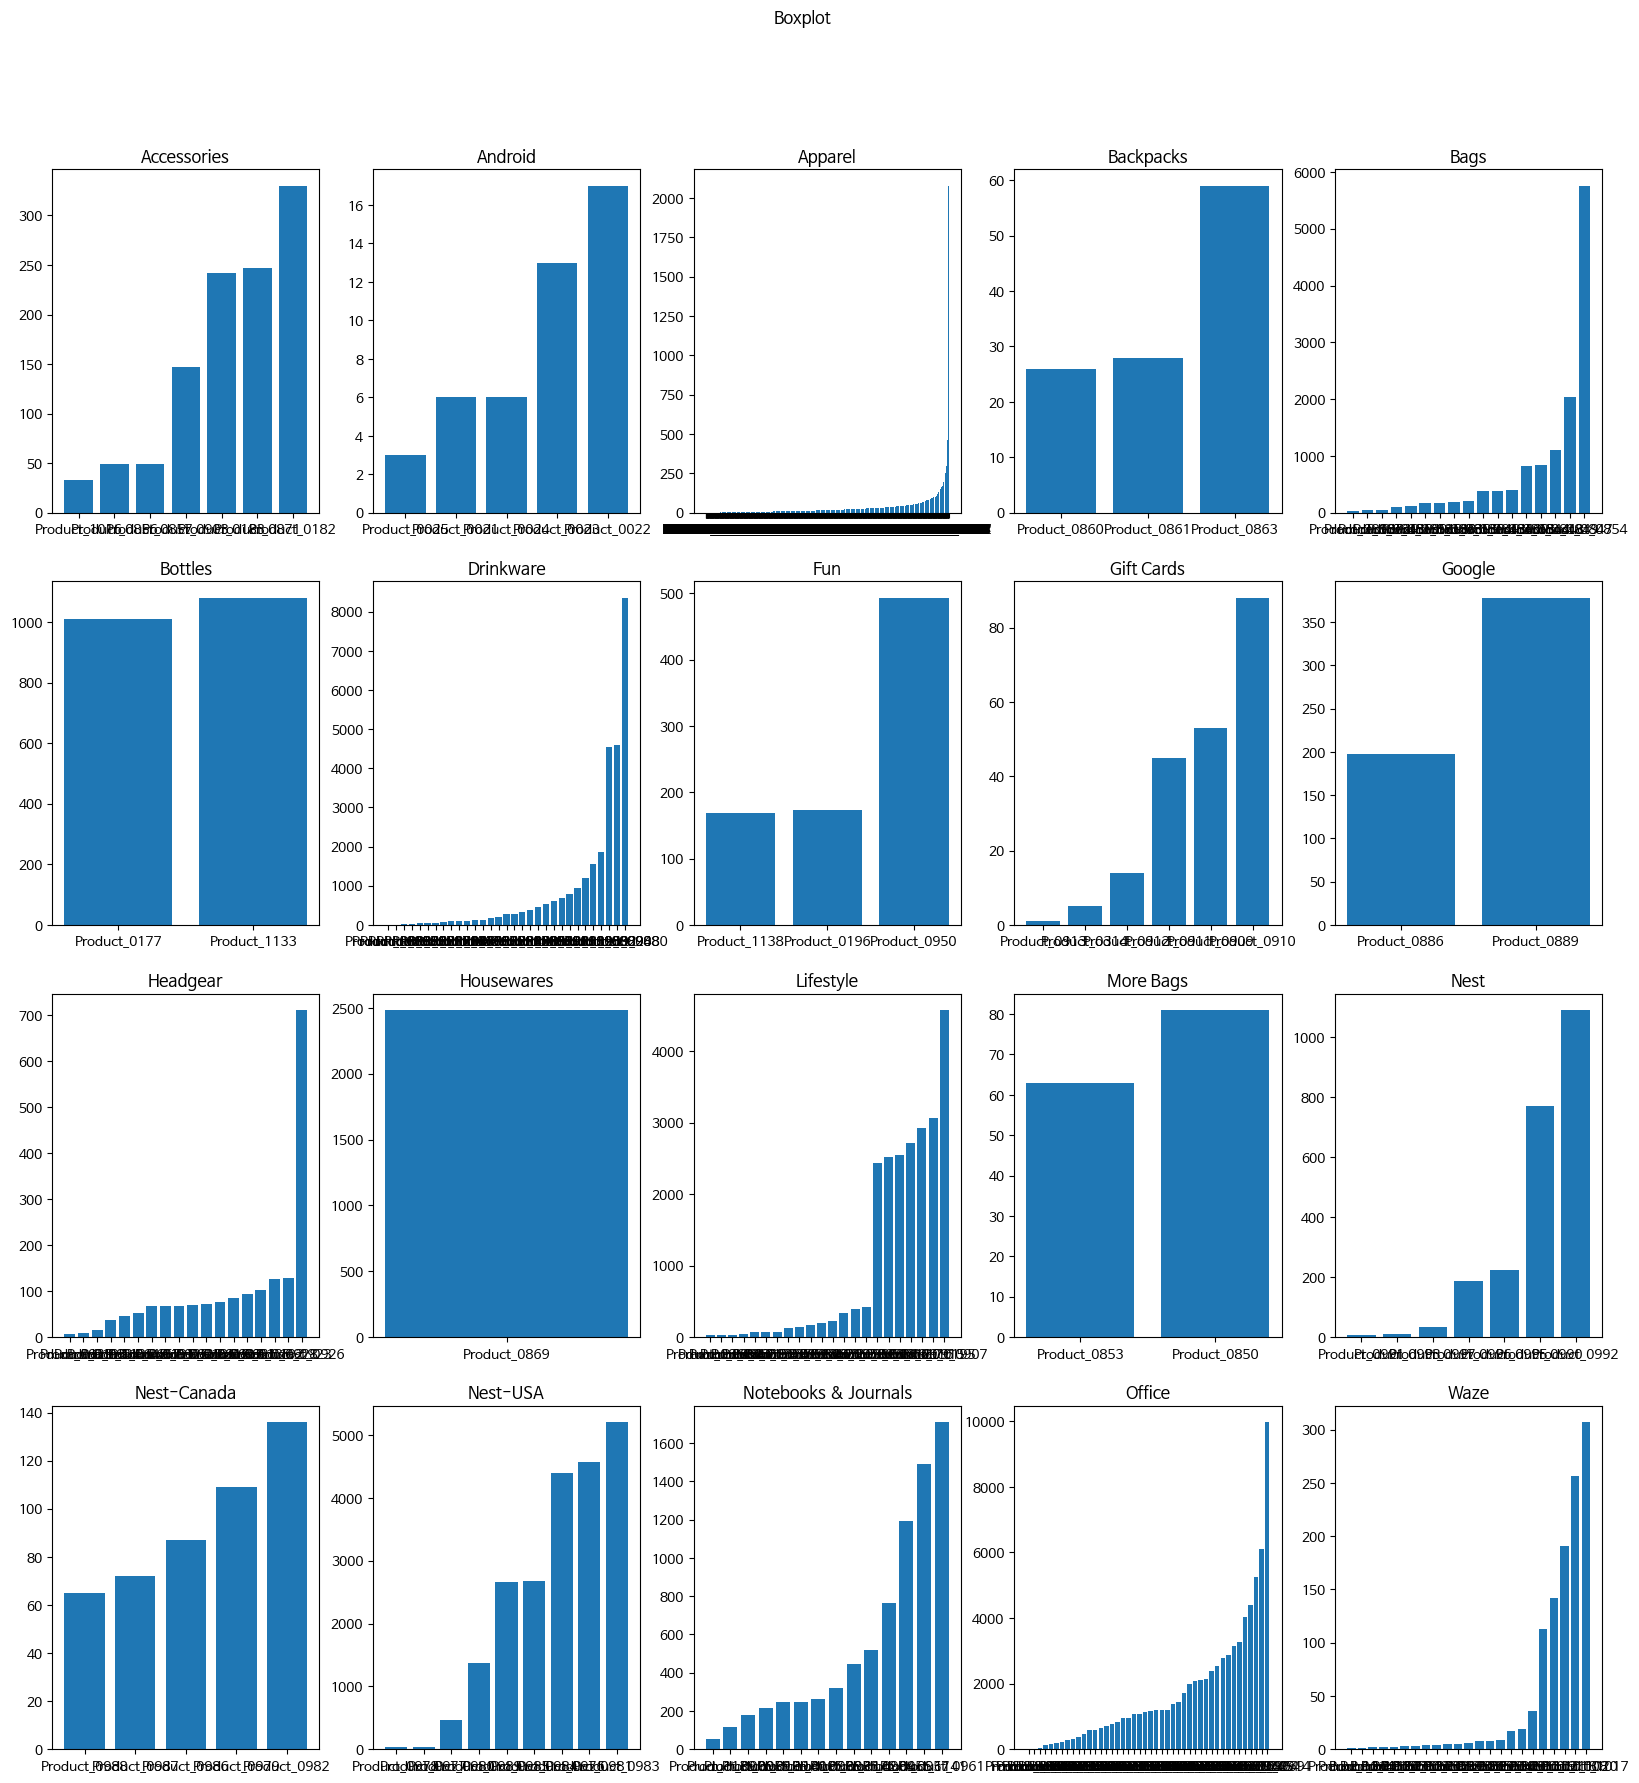

In [14]:
#카테고리별로 제품ID별 제품에 대한 인기를 총판매량, 총판매금액으로 확인하고자 함.

import matplotlib.pyplot as plt

#ar_fem
fig,axs=plt.subplots(4,5,figsize=(20,20)) #세로 *가로, 한번에 4개의 그래프를 그리겠다.
fig.suptitle('Boxplot')

for i,j in enumerate(id_avg['제품카테고리'].unique(),1):
  plt.subplot(4,5,i) #4*4중 몇번째에 그릴건지
  plt.bar(id_avg.loc[id_avg['제품카테고리']==j].sort_values('총판매량')['제품ID'],id_avg.loc[id_avg['제품카테고리']==j].sort_values('총판매량')['총판매량'])
  plt.title(j)
#plt.tight_rayout()
plt.subplots_adjust(top=0.9)


plt.show()

고객들이 해당 카테고리 내의 제품을 비슷한 형태로 구매함  : Bottles,Housewares,More Bags(애초에 제품ID가 최대 2개이다.)

소수의 제품ID가 인기를 독점하는 제품 카테고리 : Drinkware,Apparel,Bags,Office,Waze, Headgear

**Apparel에 대하여, Apparel내에서 7개의 인기제품중 하나라도 구매한 경험이 있는 고객과 / 7개의 인기제품 중 하나도 구매한 경험이 없는 고객일 경우 retention 차이가 있는지를 확인하는 예시이다**

{'whiskers': [<matplotlib.lines.Line2D at 0x7bf6247e5780>,
 'caps': [<matplotlib.lines.Line2D at 0x7bf6247e6200>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bf6247e5240>],
 'medians': [<matplotlib.lines.Line2D at 0x7bf6247e6c80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7bf6247e71c0>],
 'means': []}

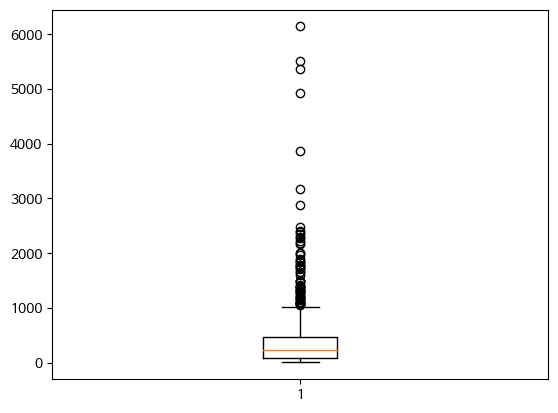

In [15]:
#롱테일 현상을 보였던 Apparel, Office,Bags를 롱테일에서 주력 상품 소수와 꼬리 상품 8-90%의 지표를 비교해 보여줌.
plt.boxplot(id_avg.loc[id_avg['제품카테고리']=="Apparel"]['총판매금액'])

롱테일 현상을 보였던 Apparel 카테고리를 기준으로 총판매금액 상위 n개의 제품과 꼬리쪽 제품을 구매한 고객의 리텐션 비교

In [16]:
#후에 쓰기 편하게 제품카테고리 총판매량,총판매금액만 나오게!
#위의 7개까지 끊기
t7=id_avg.loc[id_avg['제품카테고리']=="Apparel"].sort_values('총판매금액',ascending=False).head(7)['제품ID'].tolist()
in_t7=df_on2.loc[df_on2['제품ID'].isin(t7)]['고객ID'].unique().tolist()
in_t7=df_on2.loc[df_on2['고객ID'].isin(in_t7)]
out_t7=df_on2.loc[~df_on2['고객ID'].isin(in_t7)]
in_re_a=retention_m(in_t7) #Apparel 중 판매금액 Top7을 구매한 경험이 있는
out_re_a=retention_m(out_t7) #Apparel 중 판매금액 Top7을 구매한 경험이 없는

#리텐션의 히트맵을 그려주는 함수
def heatmap(df):
  import seaborn as sns
  import matplotlib.pyplot as plt

  plt.figure(figsize=(12, 8))
  plt.title('Cohorts: User Retention')
  sns.heatmap(df/100, mask=df.isnull(), annot=True, fmt='.0%');
  plt.show()

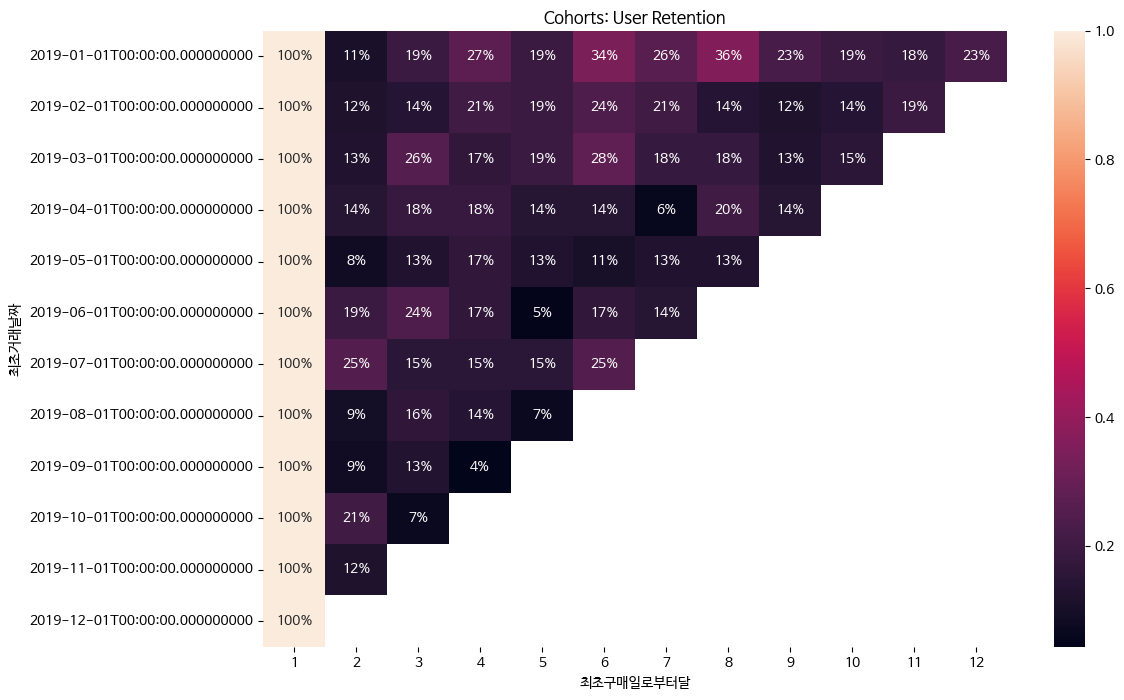

Apparel Top7을 구매했던 사람의 리텐션 :  24.32407136844637


In [17]:
heatmap(in_re_a)
print("Apparel Top7을 구매했던 사람의 리텐션 : ",in_re_a.mean().mean())

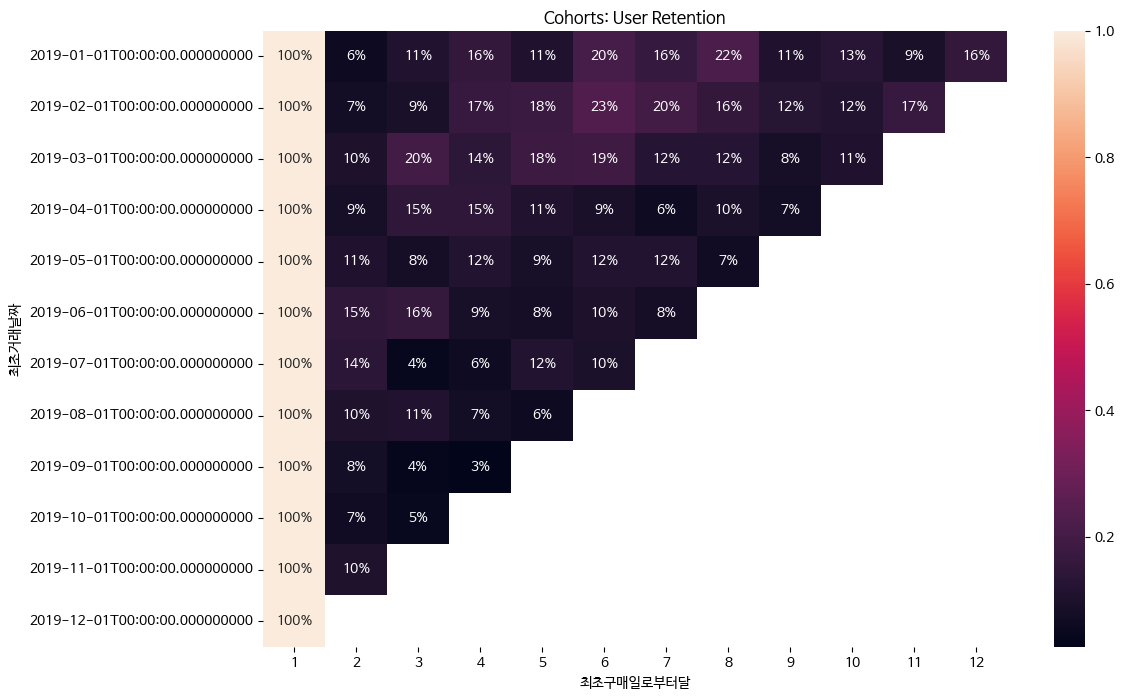

Apprel Top7를 구매하지 않았던 사람의 리텐션 :  19.42283008658009


In [18]:
heatmap(out_re_a)
print("Apprel Top7를 구매하지 않았던 사람의 리텐션 : ",out_re_a.mean().mean())

결론 : Apparel내에서 총판매금액이 가장 높은 7개의 제품을 **구매해본 경험이 있는 소비자의 리텐션은24.32인 반면 그렇지 않은 고객의 리텐션 평균은 19.42**로 확실한 차이가 나는 것을 확인할 수 있겠다.

각 카테고리별 인기를 독점하는 제품 카테고리 확인해보기

In [19]:
products = ['Apparel','Drinkware', 'Bags', 'Office', 'Waze', 'Headgear']
counts = [7,5,3,4,3,1]
for cou, pro in zip(counts,products):
  t7=id_avg.loc[id_avg['제품카테고리']==pro].sort_values('총판매금액',ascending=False).head(cou)['제품ID'].tolist()
  print(f"{pro}별 인기를 독점하는 제품 카테고리 : {t7}")

Apparel별 인기를 독점하는 제품 카테고리 : ['Product_0520', 'Product_0519', 'Product_0922', 'Product_0398', 'Product_0399', 'Product_0521', 'Product_0362']
Drinkware별 인기를 독점하는 제품 카테고리 : ['Product_0892', 'Product_0882', 'Product_0900', 'Product_0181', 'Product_0891']
Bags별 인기를 독점하는 제품 카테고리 : ['Product_0864', 'Product_0865', 'Product_0858']
Office별 인기를 독점하는 제품 카테고리 : ['Product_0904', 'Product_0969', 'Product_0952', 'Product_0852']
Waze별 인기를 독점하는 제품 카테고리 : ['Product_1017', 'Product_1008', 'Product_1000']
Headgear별 인기를 독점하는 제품 카테고리 : ['Product_0926']


### **1-3) Customer_info**

#### **1-3-1) 주목할만한 타겟1 _ 여성**
  
  여성의 남성의 CLV 값 비교를 통해 유의미한 성별 확인 -> 여성의 CLV가 상당히 더 높으면서 여성이 남성의 1.65배 정도되기에 주목해볼만한 타켓이다

In [20]:
# 1.여성의 남성의 CLV 값 비교를 통해 유의미한 성별 확인
fe=df_cus.loc[df_cus['성별']=="여",'고객ID'].tolist()
ma=df_cus.loc[df_cus['성별']=="남",'고객ID'].tolist()
df_on2 = pd.merge(df_on2,df_cus,on=['고객ID'])
df_on2.groupby('성별').mean()[['가입기간','구매횟수','평균구매금액','고객생애가치']]

,가입기간,구매횟수,평균구매금액,고객생애가치
성별,,,,
남,26.830015,95.449822,53.023691,29.559362
여,25.688875,115.411245,51.383353,36.877087


#### **1-3-2) 성별 별로 일정한 주기를 통해 구매하는 제품이 있는지 확인**

여성과 남성을 나누어 카테고리별로 일정한 리텐션 주기를 보이는 제품이 있는지 확인한다. 있다면 해당 제품에 대해 해당 주기로 마케팅을 하는 것이 효율적이라고 판단됨

.

**결론 :**

여성:Apparel','Bags','Office 을 2-3달을 주기로 구매함

남성: 'Nest-USA' 5개월 주기로 'Office'는 3-4를 주기로 구매함

In [21]:
fe_df=df_on2.loc[df_on2['고객ID'].isin(fe)]
ar_fem,ar_few=ar(fe_df)

ma_df=df_on2.loc[df_on2['고객ID'].isin(ma)]
ar_mam,ar_maw=ar(ma_df)

#컬럼 맞춰서 맞는지 확인하기
ar_mam=ar_mam[['년도월', 'Lifestyle의 ARPPU', 'Nest-USA의 ARPPU', 'Headgear의 ARPPU',
       'Nest-Canada의 ARPPU', 'Backpacks의 ARPPU', 'Bags의 ARPPU',
       'Office의 ARPPU', 'Apparel의 ARPPU', 'Drinkware의 ARPPU', 'Fun의 ARPPU',
       'Waze의 ARPPU', 'Google의 ARPPU', 'Notebooks & Journals의 ARPPU',
       'Bottles의 ARPPU', 'More Bags의 ARPPU', 'Gift Cards의 ARPPU',
       'Housewares의 ARPPU', 'Android의 ARPPU', 'Accessories의 ARPPU',
       'Nest의 ARPPU']]

In [22]:
#카테고리별로 어떤 성별이 ARPPU가 더 높은지, 얼마나 차이가 나는지를 확인할 수 있다.
#여성 더 많이 : bags,google,more bags,gift card,Accessories
#남성 더 많이 : headgear,nest-canada,fun,waze,notebook&journals,bottles
dif=pd.DataFrame(ar_fem.mean())
dif['차이_여']=np.where(ar_fem.mean().values>ar_mam.mean().values,ar_fem.mean().values-ar_mam.mean().values,"남성")
dif['차이_남']=np.where(ar_fem.mean().values>ar_mam.mean().values,"여성",ar_mam.mean().values-ar_fem.mean().values)
dif.columns = ['여성의 카테고리별 ARPPU 평균','여성-남성의 수치',' 남성-여성의 수치']
# 여성의 ARPPU의 값이 더 크면 여성-남성의 수치의 값을 보면 되고
# 남성의 ARPPU의 값이 더 크면 남성-여성의 수치의 값을 보면 된다.
dif

,여성의 카테고리별 ARPPU 평균,여성-남성의 수치,남성-여성의 수치
Nest-USA의 ARPPU,1314.181157,1251.6186734598982,여성
Bags의 ARPPU,160.890635,남성,1154.3580557934397
Lifestyle의 ARPPU,62.509770,18.570547265458785,여성
Drinkware의 ARPPU,154.634878,남성,210.63211910943778
Office의 ARPPU,156.960246,54.15952887143412,여성
Backpacks의 ARPPU,116.605633,남성,16.3901200275983
Nest-Canada의 ARPPU,283.324049,142.6103164939586,여성
Apparel의 ARPPU,288.726947,16.897605655309746,여성
Bottles의 ARPPU,23.160855,남성,131.38974245548414
Nest의 ARPPU,544.781815,482.9327342024999,여성


In [23]:
#성별별로 리텐션 지표 확인하기
re_mam=retention_m(df_on2.loc[df_on2['고객ID'].isin(ma)])
re_fem=retention_m(df_on2.loc[df_on2['고객ID'].isin(fe)])

cat_mam=cat_mon(df_on2.loc[df_on2['고객ID'].isin(ma)])
cat_fem=cat_mon(df_on2.loc[df_on2['고객ID'].isin(fe)])

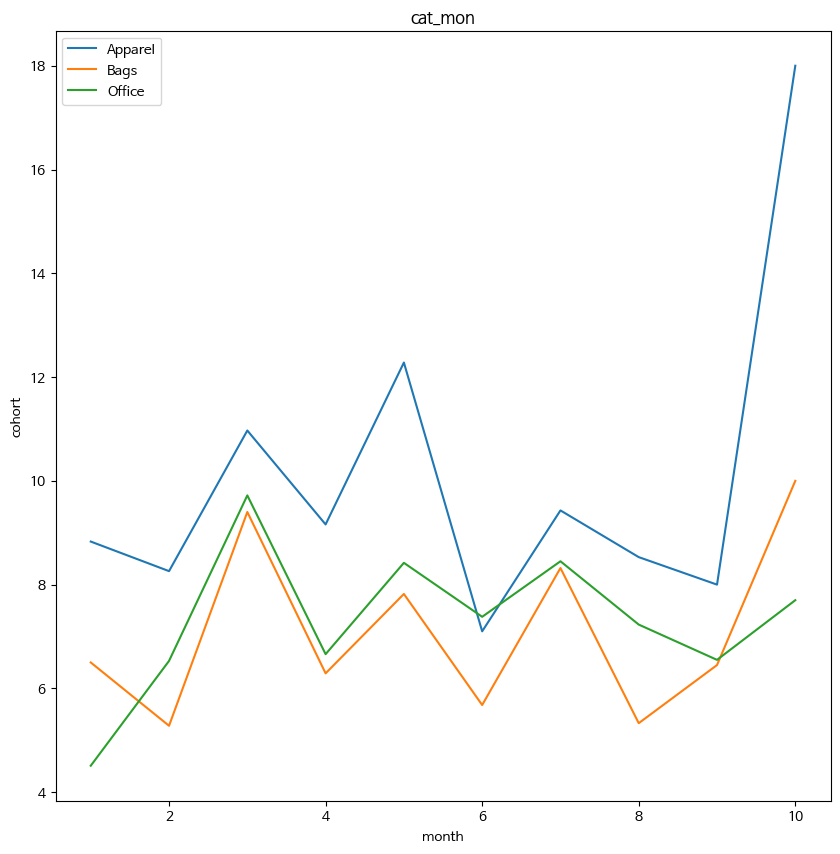

In [24]:
#여성 카테고리별 리텐션
cat_fem[['Apparel','Bags','Office']].iloc[1:].plot(figsize=(10,10))
plt.title('cat_mon')
plt.legend()

plt.xlabel('month')
plt.ylabel('cohort');

여성의 경우 다음 3가지의 카테고리에서 일정한 리텐션 상승 주기를 보였다.
Apparels,Bags,Ofice는 구매 후 2-3달에 한번씩 재구매를 하는 현상을 보이므로 고객이 해당 카테고리를 산 후 2-3달이 지나는 시점마다 관련 알람을 준다면 효과적일 것이다.

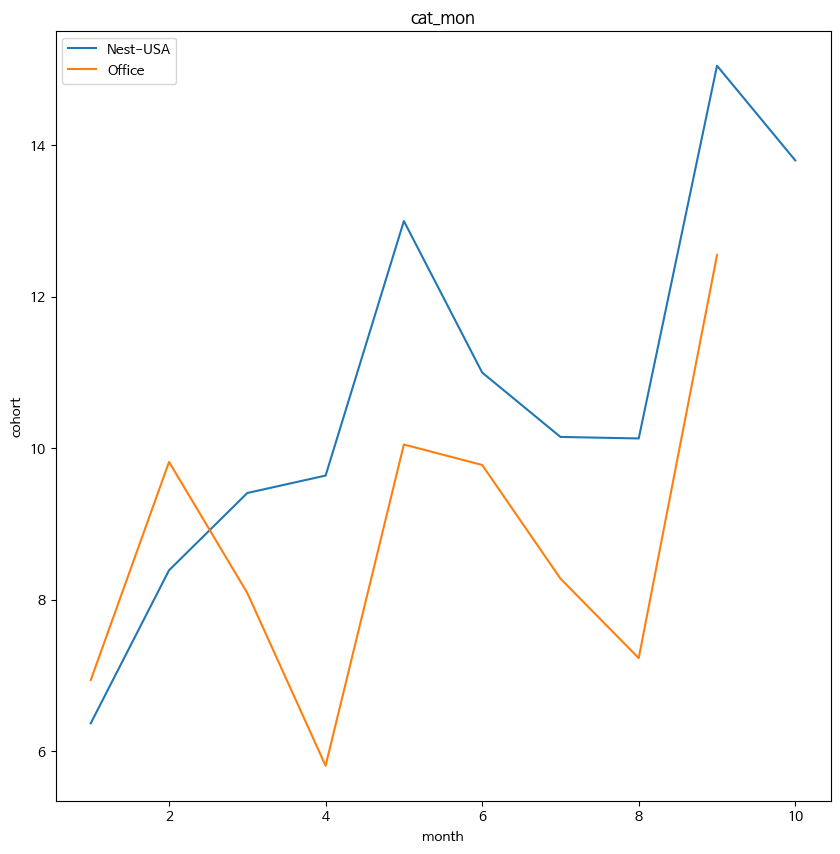

In [25]:
#남성 카테고리별 리텐션

cat_mam[['Nest-USA','Office']].iloc[1:].plot(figsize=(10,10))
plt.title('cat_mon')
plt.legend()

plt.xlabel('month')
plt.ylabel('cohort');

남성의 경우, nest_usa 5개월마다
ofice 3-4개월마다(2,5-6,9) 재구매하는 패턴을 보이므로
해당 카테고리를 구매한 이력이 있는 고객에 한해 해당 시점이 지난 후 알람을 보내는게 효율적일 것이다.


#### **1-3-3) 주목할만한 타겟2 _ Chicago,California 거주민**

고객지역별로 CLV 지표를 파악하여, 고객수와 CLV 값도 높은 지역을 발견한다 -> Chicago, California

In [26]:
#우리 이커머스 고객의 지역 분포는 다음과 같다.
df_cus.groupby('고객지역').size().sort_values(ascending=False)

고객지역
California       464
Chicago          456
New York         324
New Jersey       149
Washington DC     75
dtype: int64

In [27]:
df_on2.groupby('고객지역')[['가입기간','구매횟수','평균구매금액','고객생애가치']].mean().sort_values('고객생애가치',ascending=False)

,가입기간,구매횟수,평균구매금액,고객생애가치
고객지역,,,,
Chicago,26.247350,141.416003,51.686829,45.106671
California,26.813139,106.633235,52.099932,35.578778
New Jersey,25.971641,82.720234,52.853798,25.943974
Washington DC,26.902222,65.408148,55.427161,23.092379
New York,24.770856,75.119538,51.192779,19.954725



California,Chicago 가 가장 고객 수도 많고, CLV도 높아 조금의 노력으로 큰 성과를 낼 수 있을 것으로 예상한다.

#### **1-3-4) 주목할만한 타겟3 _ 고객의 방문시기 (요일별)**

요일별 방문 고객의 지표 차이가 가장 유의미한 결과를 보여 이 부분에서 인사이트를 얻어 후에 마케팅 주기와 관련하여 활용하고자 한다.

.

**결론 :**

  * 월요일/수요일/토요일(고객생애주기가 높은 고객이 많이 오는 요일)
  * 화요일/목요일 (고객생애주기 낮은 고객이 많이 오는 요일)







<BarContainer object of 7 artists>

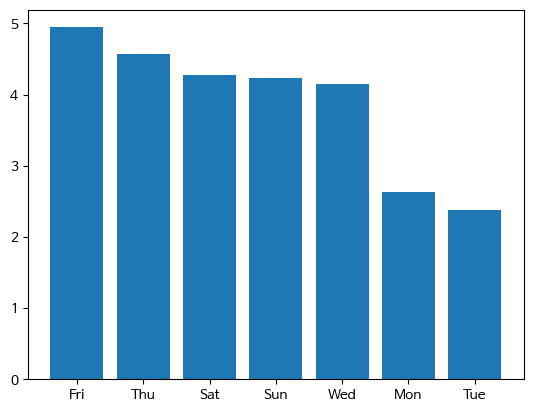

In [28]:
df_on2['거래요일']=pd.to_datetime(df_on2['거래날짜']).dt.weekday.replace({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
#요일별 거래 수량 평균
plt.bar(df_on2.groupby('거래요일')['수량'].mean().sort_values(ascending=False).index,df_on2.groupby('거래요일')['수량'].mean().sort_values(ascending=False).values)

<BarContainer object of 7 artists>

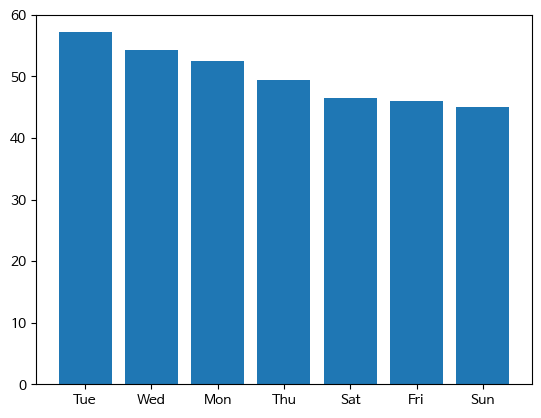

In [29]:
#일별 거래 평균금액 평균
plt.bar(df_on2.groupby('거래요일')['평균금액'].mean().sort_values(ascending=False).index,df_on2.groupby('거래요일')['평균금액'].mean().sort_values(ascending=False).values)

In [30]:
df_on2.groupby('거래요일')[['구매횟수','평균구매금액','고객생애가치']].mean().sort_values('고객생애가치',ascending=False)

,구매횟수,평균구매금액,고객생애가치
거래요일,,,
Sat,126.249291,49.719319,40.265852
Wed,118.102643,55.402439,38.111501
Mon,111.869624,54.286811,35.154438
Sun,107.024240,49.266061,33.408734
Fri,105.063426,50.712433,33.082096
Tue,93.098336,55.846038,30.976096
Thu,90.567295,51.527709,27.473668


수량과 평균금액의 그래프가 역이 관계를 갖는 것은 싸면 많은 수량을 구매하고, 비싸면 더 적은 수량을 구매하는 경향이 있기에 당연하다.


각 요일에 방문한 고객별로 고객생애주기가 차이가 많이 나는 것을 확인할 수 있다.


Sat이 고객생애가치 상위권인 이유 : 평균구매금액은 낮은 편인데, 구매를 많이 함 토요일에

Tue가 고객생애가치 하위권인 이유 : 평균금액은 1등이나, 수량과 구매횟수가 낮음.


---


각 요일에 고객생애주기 상위 ~ 하위에 맞는 전략 실행, 요일별 전략(마케팅, 할인)

월요일/수요일/토요일(고객생애주기가 높은 고객이 많이 오는 요일) : 업셀링 시도, 해당 일에 추천 알림 보내기

화요일/목요일 (고객생애주기 낮은 고객이 많이 오는 요일) : 우리 페이지에 방문하여 긍정적 경험하도록 유도하기(첫 구매 할인, 장바구니에 담아뒀던 제품 상기 알람 보내기)

### 1-4) **Marketing_info**


>마케팅 데이터를 분석하기에 앞서 우리는 아래와 같은 가정을 전제로 한 후 분석을 진행하였다.

* **마케팅을 진행한 날짜부터 14일까지의 구매이력이 모두 광고 영향을 어느정도 받았다고 가정하였으며, 마찬가지로 마케팅을 진행한 날짜부터 14일이 지난 후의 구매데이터는 해당 마케팅과 연관이 없다고 가정하였다.**\
(광고일부터 14일내의 구매한 이력을 광고의 성과로 집계하게 된 이유는 `에이블리`의 광고성과기준을 참고하였다.)

In [31]:
# 광고일부터 14일까지의 구매데이터, CLV를 모두 더해서 날짜별로 새로운 데이터프레임 만들기
df_mar2 = df_mar.copy()
df_mar2['거래날짜'] = df_mar2['날짜']
df_mar2['거래날짜'] = pd.to_datetime(df_mar2['거래날짜'])
df_mar_on = pd.merge(df_on, df_mar2, on='거래날짜', how='outer')

df_mar_on['날짜'] = pd.to_datetime(df_mar_on['날짜'])
df_mar_on['거래날짜'] = pd.to_datetime(df_mar_on['거래날짜'])

df_mar_on['2주뒤_날짜'] = df_mar_on['날짜'] + pd.DateOffset(weeks=2)
df_mar_on['총마케팅비용'] = df_mar_on['오프라인비용']+df_mar_on['온라인비용']
selected_rows = df_mar_on[df_mar_on['거래날짜'].between(df_mar_on['날짜'], df_mar_on['2주뒤_날짜'])]

new_df = selected_rows.groupby('날짜').agg({
    '평균금액': 'sum',
    '고객ID': 'count',
}).reset_index().rename(columns={'평균금액': '매출합', '고객ID': '고객수'})

new_df = pd.merge(new_df, df_mar_on[['날짜','오프라인비용', '온라인비용', '총마케팅비용']], on='날짜', how='outer')

week_df = new_df.drop_duplicates()
week_df['ARPPU'] = week_df['매출합']/week_df['고객수']
week_df.head(3)

,날짜,매출합,고객수,오프라인비용,온라인비용,총마케팅비용,ARPPU
0,2019-01-01,5183.16,89,4500,2424.50,6924.50,58.237753
89,2019-01-02,8990.64,115,4500,3480.36,7980.36,78.179478
204,2019-01-03,15428.67,207,4500,1576.38,6076.38,74.534638


#### **1-4-1) 마케팅 비용이 증가할 때 ARPPU의 변화**

* 마케팅 비용이 증가할 때 ARPPU또한 함께 증가한다면 매출 증대를 위해서 마케팅 비용을 높히는 것을 하나의 전략으로 세워볼 수 있기 때문에 마케팅 비용과 ARPPU와의 관계를 확인해보았다.


* 총마케팅 비용의 경우 unique 값의 개수가 많았기 때문에 회귀선을 통해 ARPPU와의 관계를 확인해보았다.

.**결론 :**

* 회귀선을 통해 확인해본 결과 마케팅 비용이 증가할수록 ARPPU의 증가가 뚜렷하게 보였기 때문에 **매출증대를 위해 마케팅 비용을 높히는 전략이 효과가 있을거**라 판단하였다.

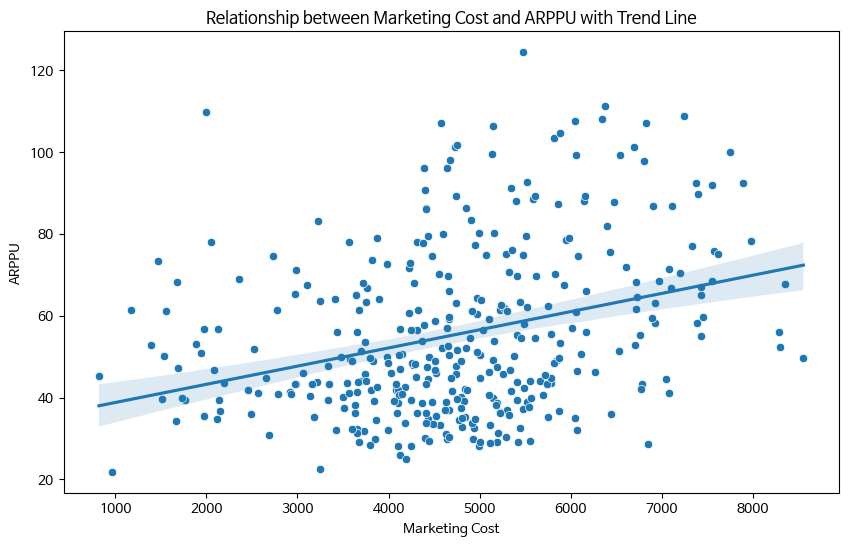

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=week_df, x='총마케팅비용', y='ARPPU')

# 회귀선 추가
sns.regplot(data=week_df, x='총마케팅비용', y='ARPPU', scatter=False)

plt.title('Relationship between Marketing Cost and ARPPU with Trend Line')
plt.xlabel('Marketing Cost')
plt.ylabel('ARPPU')
plt.show()

#### **1-4-2) 오프라인 비용이 증가할 때 ARPPU의 변화 / 온라인 비용이 증가할 때 ARPPU의 변화**

**결론 :**

* 오프라인 마케팅 비용이 가장 높은 5000을 제외한 나머지 금액에서 마케팅 비용이 증가할 수록 ARPPU가 함께 증가하는 경향을 보였다.

* 온라인 마케팅 비용의 경우 unique 값의 개수가 많았기 때문에 회귀선을 통해 ARPPU와의 관계를 확인해보았고, 오프라인과 마찬가지로 온라인 마케팅 비용이 증가할 때 ARPPU가 증가하는 경향을 보였다.



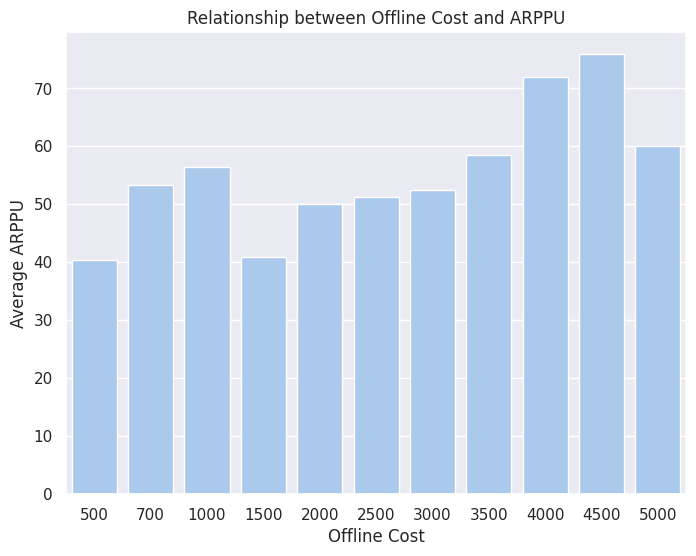

In [33]:
average_arppu_by_offline_cost = week_df.groupby('오프라인비용')['ARPPU'].mean().reset_index()

sns.set(style="darkgrid")
sns.set_palette("pastel")

plt.figure(figsize=(8, 6))
sns.barplot(x='오프라인비용', y='ARPPU', data=average_arppu_by_offline_cost)
plt.title('Relationship between Offline Cost and ARPPU')
plt.xlabel('Offline Cost')
plt.ylabel('Average ARPPU')
plt.show()

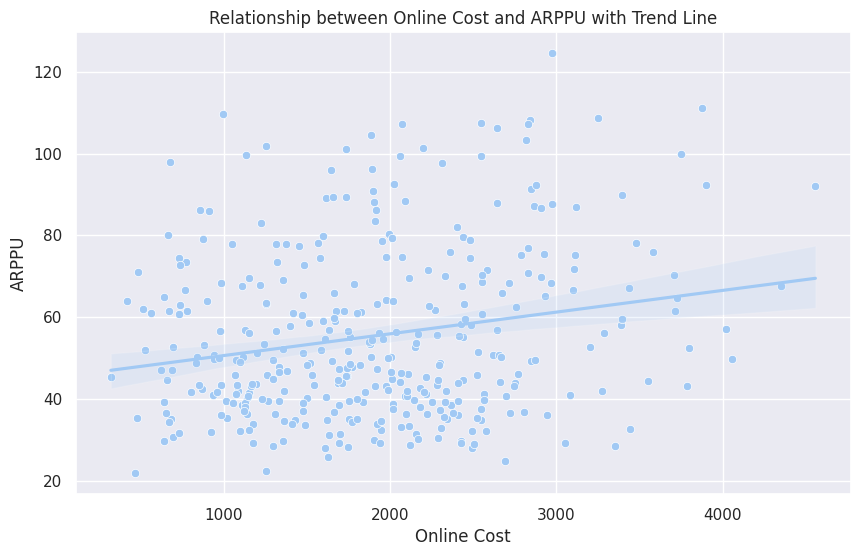

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=week_df, x='온라인비용', y='ARPPU')

# 회귀선 추가
sns.regplot(data=week_df, x='온라인비용', y='ARPPU', scatter=False)

plt.title('Relationship between Online Cost and ARPPU with Trend Line')
plt.xlabel('Online Cost')
plt.ylabel('ARPPU')
plt.show()

#### **1-4-3)** ARPPU 값과 회귀선을 통하여 온/오프라인 중 더 효과적인 마케팅 방법 선택


* 추가적으로 온라인 마케팅과 오프라인 마케팅 중 ARPPU를 올리기 위해 더 효율적인 마케팅이 무엇인지 알아보기 위해 온/오프라인 마케팅과 ARPPU와의 회귀선을 구한 후 기울기를 비교해보았다.

**결론 :** 오프라인 광고 비용을 높혔을 때 ARPPU가 더 많이 오르기 때문에 매출증대를 위한 효과가 좋다고 볼 수 있다.

Online Regression Slope: 42.79474747474745


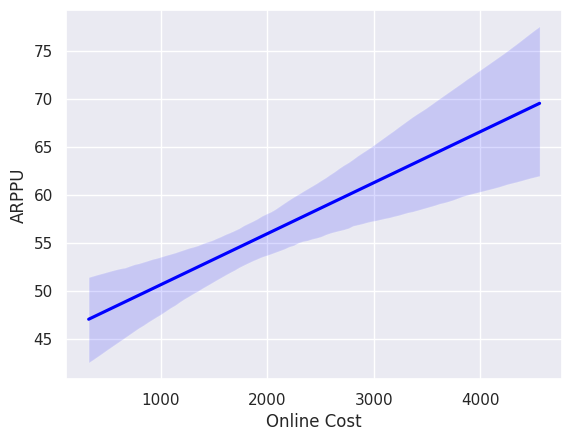

In [35]:
# 온라인 광고 비용 회귀선 기울기
slope_online, intercept_online = sns.regplot(data=week_df, x='온라인비용', y='ARPPU', scatter=False, color='blue').get_lines()[0].get_data()
plt.xlabel('Online Cost')
print("Online Regression Slope:", slope_online[1] - slope_online[0])

Offline Regression Slope: 45.454545454545496


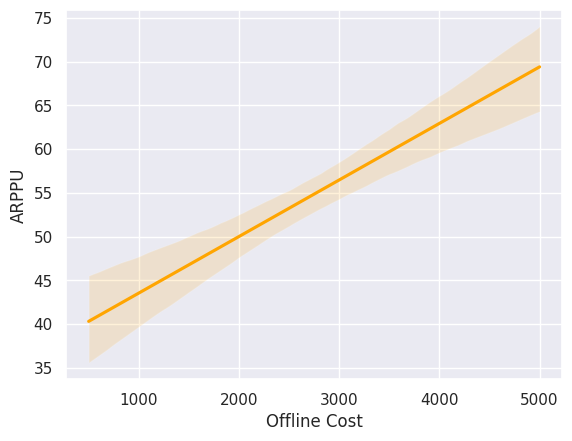

In [36]:
# 오프라인 광고 비용 회귀선 기울기
slope_offline, intercept_offline = sns.regplot(data=week_df, x='오프라인비용', y='ARPPU', scatter=False, color='orange').get_lines()[0].get_data()
plt.xlabel('Offline Cost')
print("Offline Regression Slope:", slope_offline[1] - slope_offline[0])

* Online Regression Slope: 42.79474747474745
* Offline Regression Slope: 45.454545454545496
* 회귀선의 기울기를 비교해 본 결과 오프라인 광고 비용 회귀선의 기울기가 조금 더 높았으며, 크게 두드러지는 차이는 아니지만 **오프라인 광고 비용을 높혔을 때 ARPPU가 더 많이 오르기 때문에 매출증대를 위한 효과가 좋다고 볼 수 있다**.

#### **1-4-4)** 마케팅 비용이 높은 기간에 물건을 구매한 고객의 리텐션과 마케팅 비용이 낮을 때 물건을 구매한 고객의 리텐션 비교


* 마케팅 비용이 높을 때 구매한 고객의 리텐션이 높다면, 고객의 재구매율을 높히기 위해서 마케팅 비용을 높히는 전략을 세워볼 수 있기 때문에 마케팅 비용이 높을 때와 낮을 때 구매한 고객으로 나누어서 리텐션을 확인해보았다.


##### **1-4-4-1)  마케팅 비용이 높을 때`**
>마케팅 비용이 상위 25%에 해당할 때 구매한 고객의 리텐션 확인

**결론 :**
  * 시간이 지날수록 리텐션율이 증가한다.
  * 마지막 달에는 리텐션율이 10%에 가까워지거나 더 높아지는 경향이 있다.

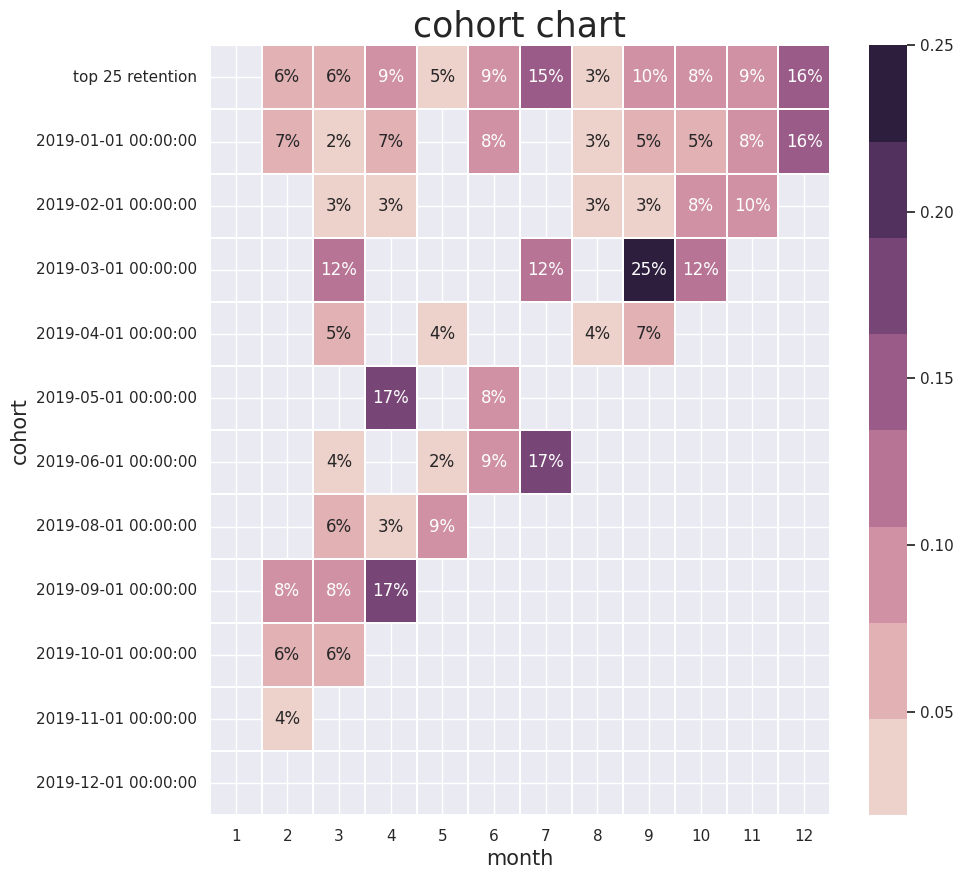

In [37]:
# 총마케팅 비용을 사분위수로 나눈 후에 상위 25퍼센트에 해당하는 행들만
# 새로운 데이터프레임으로 추출
q3 = df_mar_on['총마케팅비용'].quantile(0.75)
mar_top = df_mar_on[df_mar_on['총마케팅비용'] > q3]

def get_month(x) :
  return dt.datetime(x.year,x.month,1)
mar_top['거래날짜달기준'] = mar_top['거래날짜'].apply(get_month)
grouping = mar_top.groupby('고객ID')['거래날짜달기준']
mar_top['최초거래날짜'] = grouping.transform('min')

def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day
invoice_year,invoice_month,_ = get_month_int(mar_top,'거래날짜달기준')
cohort_year,cohort_month,_ = get_month_int(mar_top,'최초거래날짜')
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
mar_top['최초구매일로부터달'] = year_diff * 12 + month_diff + 1
#Count monthly active customers from each cohort
grouping = mar_top.groupby(['최초거래날짜', '최초구매일로부터달'])
cohort_data = grouping['고객ID'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='최초거래날짜',columns='최초구매일로부터달',values='고객ID')
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis
# retention 평균 추가
monthly_avg_retention = retention.mean(axis=0)
monthly_avg_retention_df = pd.DataFrame(monthly_avg_retention).T
monthly_avg_retention_df.index = ['top 25 retention']
retention_avg = monthly_avg_retention_df
retention = pd.concat([monthly_avg_retention_df, retention])

def plot_cohort_chart(retention_matrix):
  # 첫번째 열의 경우 모두 100%로 의미있는 값이 아니기에 지운다.
    mask = retention_matrix.isnull()
    mask.iloc[:, 0] = True
    plt.figure(figsize = (10, 10))
    sns.heatmap(
        retention,
        mask=mask,
        annot=True,
        fmt='.0%',
        cmap=sns.cubehelix_palette(8),
        linewidths=.05
    )
    plt.title('cohort chart', fontsize=25)
    plt.xlabel('month', fontsize=15)
    plt.ylabel('cohort', fontsize=15)
    plt.show()
plot_cohort_chart(retention)

##### **1-4-4-2)  온라인 마케팅 비용이 낮을 때**

>온라인 마케팅 비용이 하위 25%에 해당할 때 구매한 고객의 리텐션 확인

**결론 :**
* 시간이 지날수록 리텐션율이 감소한다.
  * 마지막 달의 리텐션율은 5%를 넘지 않는다.

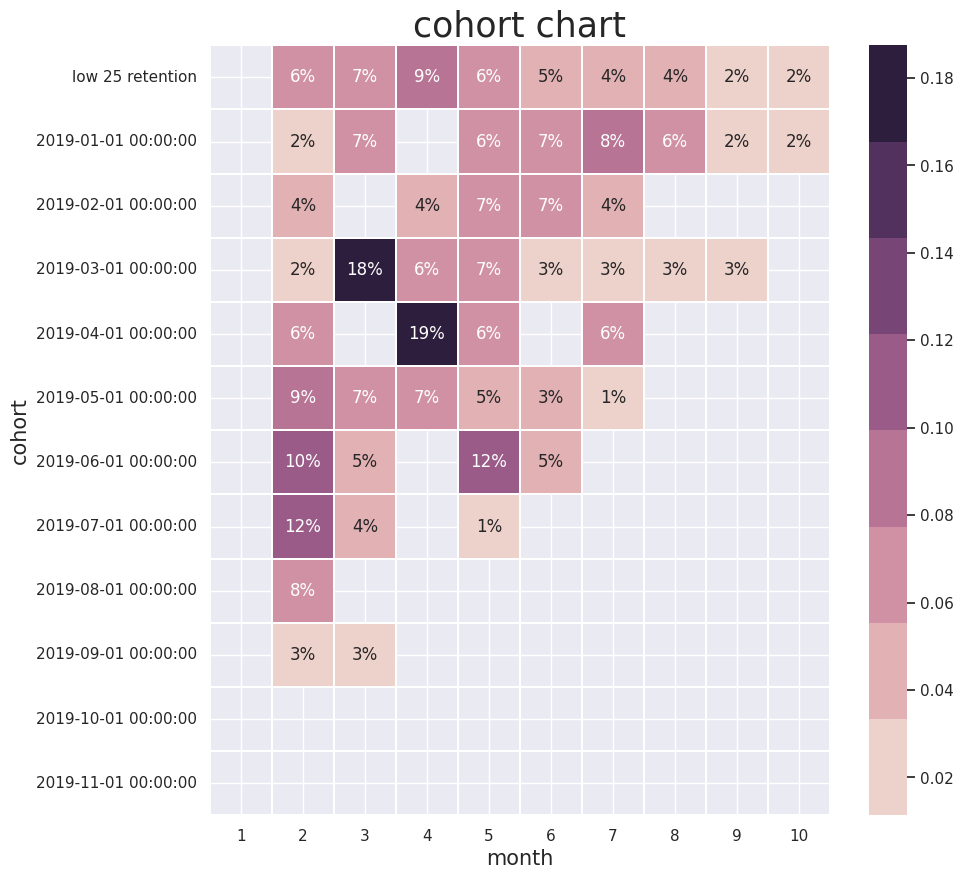

In [38]:
# 총마케팅 비용을 사분위수로 나눈 후에 하위 25퍼센트에 해당하는 행들만
# 새로운 데이터프레임으로 추출
q1 = df_mar_on['총마케팅비용'].quantile(0.25)
mar_bottom = df_mar_on[df_mar_on['총마케팅비용'] < q1]

def get_month(x) :
  return dt.datetime(x.year,x.month,1)

mar_bottom['거래날짜달기준'] = mar_bottom['거래날짜'].apply(get_month)
grouping = mar_bottom.groupby('고객ID')['거래날짜달기준']
mar_bottom['최초거래날짜'] = grouping.transform('min')


def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day

invoice_year,invoice_month,_ = get_month_int(mar_bottom,'거래날짜달기준')
cohort_year,cohort_month,_ = get_month_int(mar_bottom,'최초거래날짜')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

mar_bottom['최초구매일로부터달'] = year_diff * 12 + month_diff + 1
#Count monthly active customers from each cohort
grouping = mar_bottom.groupby(['최초거래날짜', '최초구매일로부터달'])
cohort_data = grouping['고객ID'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='최초거래날짜',columns='최초구매일로부터달',values='고객ID')
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis
# retention 평균 추가
monthly_avg_retention = retention.mean(axis=0)
monthly_avg_retention_df = pd.DataFrame(monthly_avg_retention).T
monthly_avg_retention_df.index = ['low 25 retention']
retention_avg = pd.concat([retention_avg, monthly_avg_retention_df])
retention = pd.concat([monthly_avg_retention_df, retention])

def plot_cohort_chart(retention_matrix):
  # 첫번째 열의 경우 모두 100%로 의미있는 값이 아니기에 지운다.
    mask = retention_matrix.isnull()
    mask.iloc[:, 0] = True

    plt.figure(figsize = (10, 10))

    sns.heatmap(
        retention,
        mask=mask,
        annot=True,
        fmt='.0%',
        cmap=sns.cubehelix_palette(8),
        linewidths=.1
    )

    plt.title('cohort chart', fontsize=25)
    plt.xlabel('month', fontsize=15)
    plt.ylabel('cohort', fontsize=15)

    plt.show()

plot_cohort_chart(retention)

##### **1-4-4-3)** 마케팅 비용이 높을 때 구매한 고객과 낮을 때 구매한 고객의 평균 리텐션 그래프

**결론 :** 재구매율 증대를 위해 마케팅 비용을 높히는 것이 장기적으로 보았을 때 큰 이득을 가져온다는 것을 확인하였다.

<Figure size 1000x600 with 0 Axes>

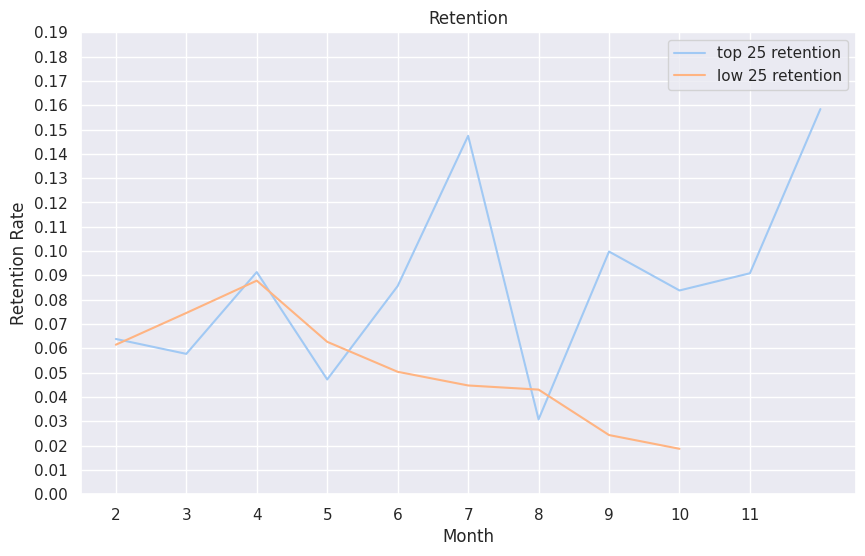

In [39]:
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))

for row_label, row_data in retention_avg.iterrows():
    plt.plot(row_data.index[1:], row_data.values[1:], label=f'{row_label}')

plt.title('Retention')
plt.xlabel('Month')
plt.ylabel('Retention Rate')
plt.xticks(range(2, 12))
plt.yticks(np.arange(0, 0.2, 0.01))
plt.grid(True)
plt.legend()

# 그래프 표시
plt.show()

* 5월 중순 이전에는 마케팅 비용이 하위 25%일 때 구매한 고객의 리텐션율이 높은 구간이 보이지만, 5월 중순 이후에는 상위 25%일 때 구매한 고객의 리텐션이 훨씬 높아진다.
* 이를 보아 재구매율 증대를 위해 **마케팅 비용을 높히는 것이 장기적으로 보았을 때 큰 이득을 가져온**다는 것을 확인하였다.

### 1-5) Discount_info


#### **1-5-1) 카테고리와 무관하게 쿠폰을 제공하는 달이 일정함.**

→ 10% (1,4,7,10) , 20% (2,5,8,11), 30% (3,6,9,12)

In [40]:
df_dis.groupby('월')['할인율'].unique()

월
Apr    [10]
Aug    [20]
Dec    [30]
Feb    [20]
Jan    [10]
Jul    [10]
Jun    [30]
Mar    [30]
May    [20]
Nov    [20]
Oct    [10]
Sep    [30]
Name: 할인율, dtype: object

부여받은 Discount_Info.csv를 확인해본 결과, 제품카테고리와 무관하게 1월,2월,3월...10월,11월,12월과 같이 달이 지남에 따라 10%,20%,30%의 할인율을 반복하고 있음을 알 수 있었다.

이러한 할인율이 소비자 구매 패턴 등을 반영해 이커머스에서 최고 수익을 창출하는 데에 적합하지 않다고 생각하여 아래의 과정을 통해 할인율에 반영됐으면 하는 점들을 제안해보았다.

#### **1-5-2) 할인율에 따른 구매횟수 , 평균금액, 고객생애가치 분석을 통하여 효과적인 할인율 고려**

**결론 :**
구매횟수 : 10%가 제일 많음
평균금액,고객생애가치 : 30%가 제일 높음
20%일 때 이용힌 고객들은 고객생애주기가 매우 낮고 여러 지표에서 낮은 성과를 보인다

In [41]:
month_dict = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
df_dis2= df_dis.copy()
df_on['월'] = df_on['거래날짜'].dt.month
df_dis2['월']= df_dis['월'].replace(month_dict)
df_dis2 = pd.merge(df_dis2,df_on,on=['제품카테고리','월'])
df_dis2.groupby('할인율')['구매횟수','평균금액','고객생애가치'].mean()

,구매횟수,평균금액,고객생애가치
할인율,,,
10,115.160675,51.153238,36.408986
20,100.139316,50.676393,29.745842
30,107.887076,55.537525,36.531677


In [42]:
#  각 카테고리별 기준이 되는 판매수량 보다 한명의 고객이 하루에 해당 카테고리에 대한 구매 수량의 총합이 크다면, 다음번 구매때 해당 카테고리에 한해서 10% 할인 쿠폰을 제공한다
#각 카테고리별 기준이 되는 판매 금액 보다 한명의 고객이 하루에 해당 카테고리에 대한 구매 금액의 총합이 크다면, 다음번 구매때 해당 카테고리에 한해서 30% 할인 쿠폰을 제공한다
pd.concat([pd.DataFrame({'기준이 되는 판매 수량 ': pd.DataFrame(df_dis2.groupby(['고객ID','거래날짜','제품카테고리'])['수량'].sum()).reset_index('제품카테고리').groupby('제품카테고리')['수량'].describe().iloc[:,6]}),
           pd.DataFrame({'기준이 되는 판매 금액 ':pd.DataFrame(df_dis2.groupby(['고객ID','거래날짜','제품카테고리'])['평균금액'].sum()).reset_index('제품카테고리').groupby('제품카테고리')['평균금액'].describe().iloc[:,6]})],axis=1)

,기준이 되는 판매 수량,기준이 되는 판매 금액
제품카테고리,,
Accessories,3.00,13.5900
Android,1.00,19.9900
Apparel,13.00,187.2575
Bags,10.00,81.5300
Bottles,10.00,4.9900
Drinkware,20.00,32.7700
Gift Cards,2.00,152.1675
Headgear,2.00,24.7475
Housewares,18.00,2.5000


10%일 때 구매횟수가 가장 많고, 30%일 때 평균금액과 고객생애가치 가장 높다.

20%일 때 이용힌 고객들은 고객생애주기가 매우 낮고 여러 지표에서 낮은 성과를 보이고 있다. 제외하고 이 비용을 다른 데로 돌려도 좋을 것 같다.

(이 점은 후에 군집별로 분석해도 여섯 군집 중 최소 다섯 군집에서 동일하다.)


10%일 땐 가격대가 높지 않은 물품을 많이 구매하며, 30%일 때는 평소에 사지 않았던 고액의 물건을 거래하는 것 같다.


→ 각 제품 카테고리별 고객이 하루에 구매한 총액을 기준으로, 상위 25% 고객이 구매한 총액이상의 금액을 사용할시, 다음번 구매에 해당 제품카테고리의 30% 할인쿠폰 제공

→각 제품 카테고리별 고객이 하루에 구매한 수량을 기준으로, 상위 25% 고객이 구매한 수량 이상의 제품을 구매할시, 다음번 구매에 해당 제품카테고리의 10% 할인쿠폰 제공



### 1-6) 이용 카테고리수의 증가에 따른 고객생애가치 증가



#### **1-6-1) 파생변수: 주이용횟수, 주이용카테고리, 이용카테고리 변수 생성**


주이용카테고리 : 고객별로 가장 많이 이용한 카테고리이다.

주이용횟수 : 고객이 주카테고리를 총 몇번 이용했는지에 대한 지표이다. (2일 이상 거래, 10행 이상 거래한 고객만을 뽑았기에 최소 3번은 구매해야 주카테고리로 선정한다.)

이용카테고리수 :  고객이 가입 후 이용해본 카테고리의 수를 계산하였다.

In [43]:
#df_on2 기본 df에서 평균금액, 수량 이상치를 제외한 데이터프레임이다.
df_on2.head(2)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,총구매금액,구매횟수,평균구매금액,평균구매빈도,고객생애가치,거래날짜달기준,최초거래날짜,최초구매일로부터달,다음구매날짜,다음쿠폰상태,최종금액,재구매날까지의일,지불금액,총판매수량,총판매금액,성별,고객지역,가입기간,거래요일
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,153.71,0.0,153.71,4570,688916.34,남,Chicago,12,Tue
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,153.71,0.0,153.71,4570,688916.34,남,Chicago,12,Tue


In [44]:
#고객의 행동 특성을 보고 싶기에 최소한 거래한지 2일, 거래행이 10행 이상있는 고객들만을 뽑았다.
a=pd.DataFrame(df_on2.groupby(['고객ID'])['거래날짜'].value_counts().index)
a.columns=['divide']
a['고객ID']=a['divide'].apply(lambda x:x[0])
a['거래날짜']=a['divide'].apply(lambda x:x[1])
sale_c=pd.DataFrame(a.groupby('고객ID')['거래날짜'].count())
sale_c=sale_c.reset_index()
cus2d=sale_c[sale_c['거래날짜']>2]['고객ID'].tolist()
df_3=df_on2.copy()
df_3=df_3.loc[df_3['고객ID'].isin(cus2d)]

In [45]:
#거래행이 10 이상
u10=df_3.groupby(['고객ID'])['거래ID'].count().sort_values().head(18).index.tolist()
df_3=df_3.loc[~df_3['고객ID'].isin(u10)]

In [46]:
#전체 고객 중 거래를 한 날이 2일 이상, 거래 기록이 10행 이상인 고객만의 데이터프레임이다.
df_3.head(5)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,총구매금액,구매횟수,평균구매금액,평균구매빈도,고객생애가치,거래날짜달기준,최초거래날짜,최초구매일로부터달,다음구매날짜,다음쿠폰상태,최종금액,재구매날까지의일,지불금액,총판매수량,총판매금액,성별,고객지역,가입기간,거래요일
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,153.71,0.0,153.71,4570,688916.34,남,Chicago,12,Tue
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,153.71,0.0,153.71,4570,688916.34,남,Chicago,12,Tue
2,USER_1358,Transaction_0016,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Clicked,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Clicked,153.71,0.0,153.71,4570,688916.34,남,Chicago,12,Tue
3,USER_1358,Transaction_0017,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Clicked,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Clicked,153.71,0.0,153.71,4570,688916.34,남,Chicago,12,Tue
4,USER_1358,Transaction_0018,2019-01-01,Product_0981,Nest-USA,2,153.71,6.5,Clicked,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Not Used,307.42,0.0,307.42,4570,688916.34,남,Chicago,12,Tue


In [47]:
#고객별 주 카테고리, 이용 카테고리
cc=pd.DataFrame(df_3.groupby('고객ID')['제품카테고리'].value_counts())

cc.columns=['주문횟수']
cc.reset_index(inplace=True)
cc.head()

,고객ID,제품카테고리,주문횟수
0,USER_0001,Nest-USA,20
1,USER_0001,Apparel,19
2,USER_0001,Office,11
3,USER_0001,Bags,2
4,USER_0001,Drinkware,2


In [48]:
cat=pd.DataFrame(cc.groupby('고객ID')['제품카테고리'].count()).reset_index()
cc=pd.merge(cc,cat,on='고객ID')
cc.columns=['고객ID','제품카테고리','주문횟수','이용카테고리']
fav_cat=pd.DataFrame(cc.groupby('고객ID')['주문횟수'].max()).reset_index()

#자동으로 해당행(고객ID,주문횟수)- Inner Join
fav_cat=pd.merge(cc,fav_cat,on=['고객ID','주문횟수'])

#최소 3번은 시켜야 주이용카테고리에 들어간다, 이용카테고리수 최소 또한 3
fav_cat.columns=['고객ID','주이용카테고리','주이용횟수','이용카테고리수']
fav_cat.head()

,고객ID,주이용카테고리,주이용횟수,이용카테고리수
0,USER_0001,Nest-USA,20,10
1,USER_0009,Apparel,33,10
2,USER_0013,Apparel,17,6
3,USER_0018,Apparel,23,8
4,USER_0019,Apparel,6,7


In [49]:
#기존의 df에 합치기
df_3=pd.merge(df_3,fav_cat,on='고객ID')
df_on3=pd.merge(df_on2,fav_cat,on='고객ID')
df_on3.groupby(['주이용카테고리'])[['주이용횟수','고객지역','가입기간','구매횟수','평균구매금액','고객생애가치']].agg(['count','mean'])

주이용횟수              가입기간              구매횟수             평균구매금액  \
           count       mean  count       mean  count        mean  count   
주이용카테고리                                                                   
Apparel    20865  67.425929  20865  26.622813  20865  186.404457  20865   
Bags          26   5.000000     26  10.000000     26   26.000000     26   
Lifestyle     29   7.000000     29  15.000000     29   29.000000     29   
Nest-USA    6269  33.505663   6269  22.644281   6269   89.482374   6269   
Office       535  13.983178    535  23.259813    535   50.785047    535   
Waze          16   4.000000     16  28.000000     16   16.000000     16   

                     고객생애가치             
                mean  count       mean  
주이용카테고리                                 
Apparel    46.640113  20865  57.884132  
Bags       44.211154     26   2.624406  
Lifestyle  38.820690     29   3.855479  
Nest-USA   66.473208   6269  25.215178  
Office     39.617255    535  10.645173  
Waze       17.148750     16   1.754027

#### **1-6-2) 주이용카테고리의 횟수가 높은 Apparel / Nest-USA / Office 에 대해 카테고리 고객별 주카테고리가 확립되어 있나, 아닌가에 따른 retention 차이 확인**


**결론 :** 주이용카테고리가 Apparel일 때의 리텐션 평균 :  36.335
Apparel 카테고리를 이용해본 고객의 리텐션 평균 :  20.3138

주이용카테고리가 Nest-USA일 때의 리텐션 평균 :  36.1797
Nest-USA 카테고리를 이용해본 고객의 리텐션 평균 :  20.518

주이용카테고리가 Office일 때의 리텐션 평균 :  56.1041
Office 카테고리를 이용해본 고객의 리텐션 평균 :  21.1690

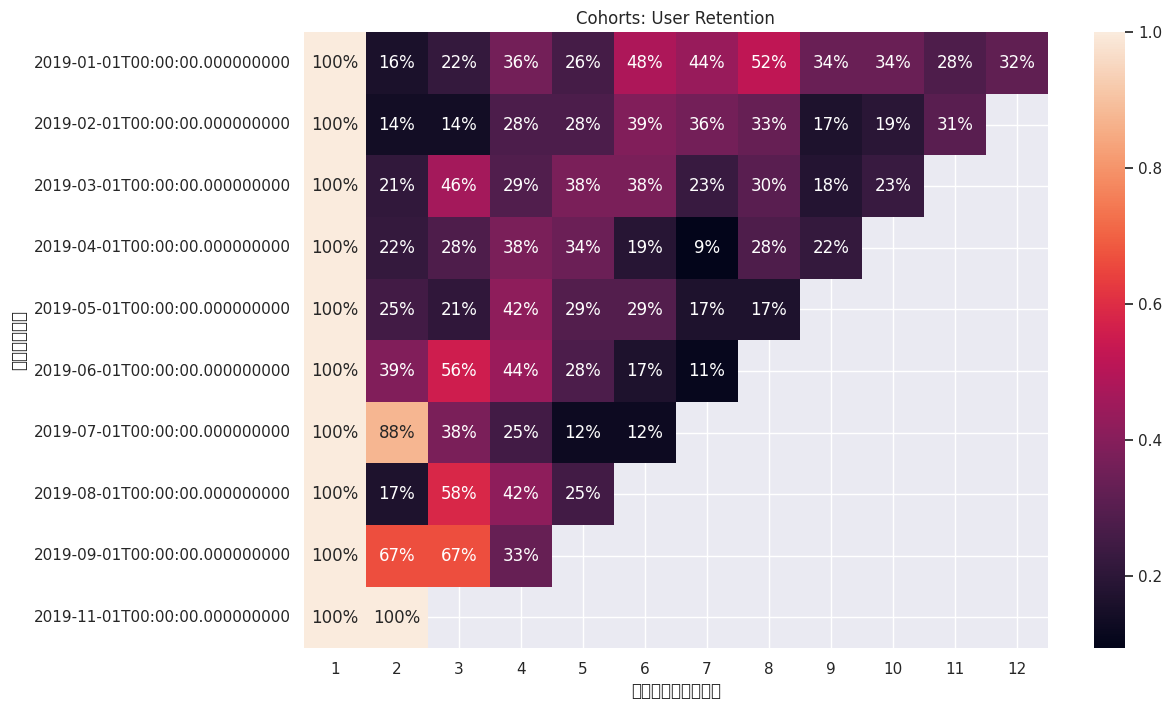

주이용카테고리가 Apparel일 때의 리텐션 평균 :  36.33518518518519
Apparel 카테고리를 이용해본 고객의 리텐션 평균 :  35.583235329485326


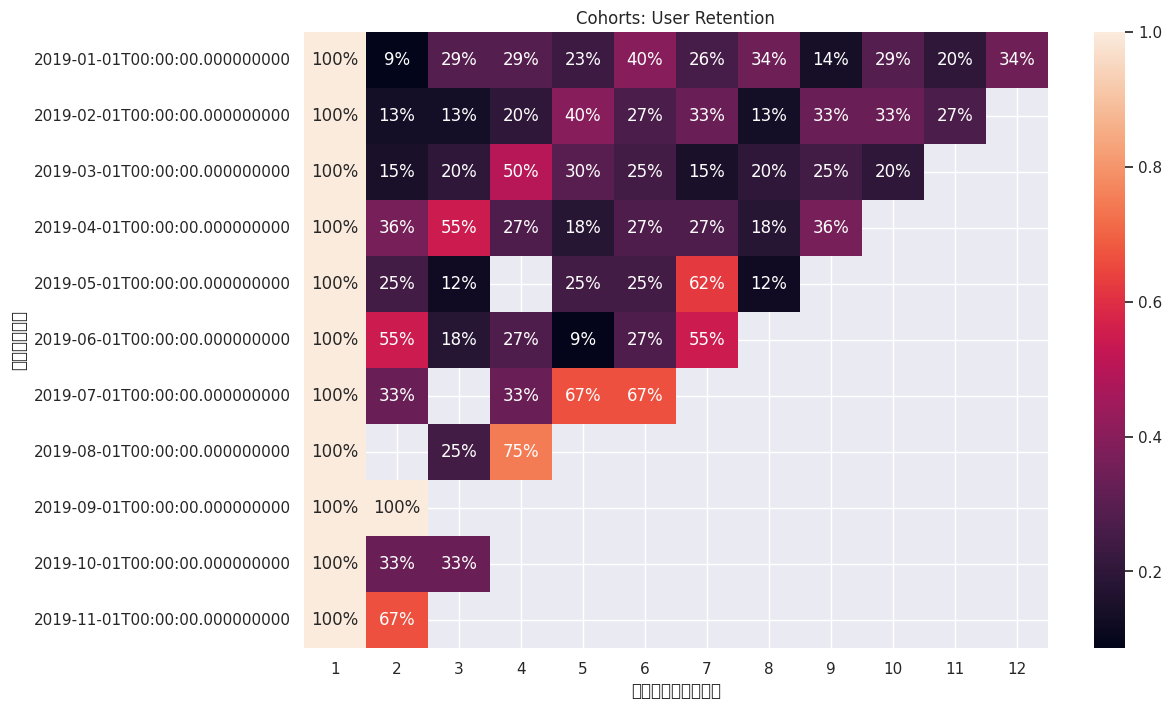

주이용카테고리가 Nest-USA일 때의 리텐션 평균 :  36.179742063492064
Nest-USA 카테고리를 이용해본 고객의 리텐션 평균 :  35.60003637566138


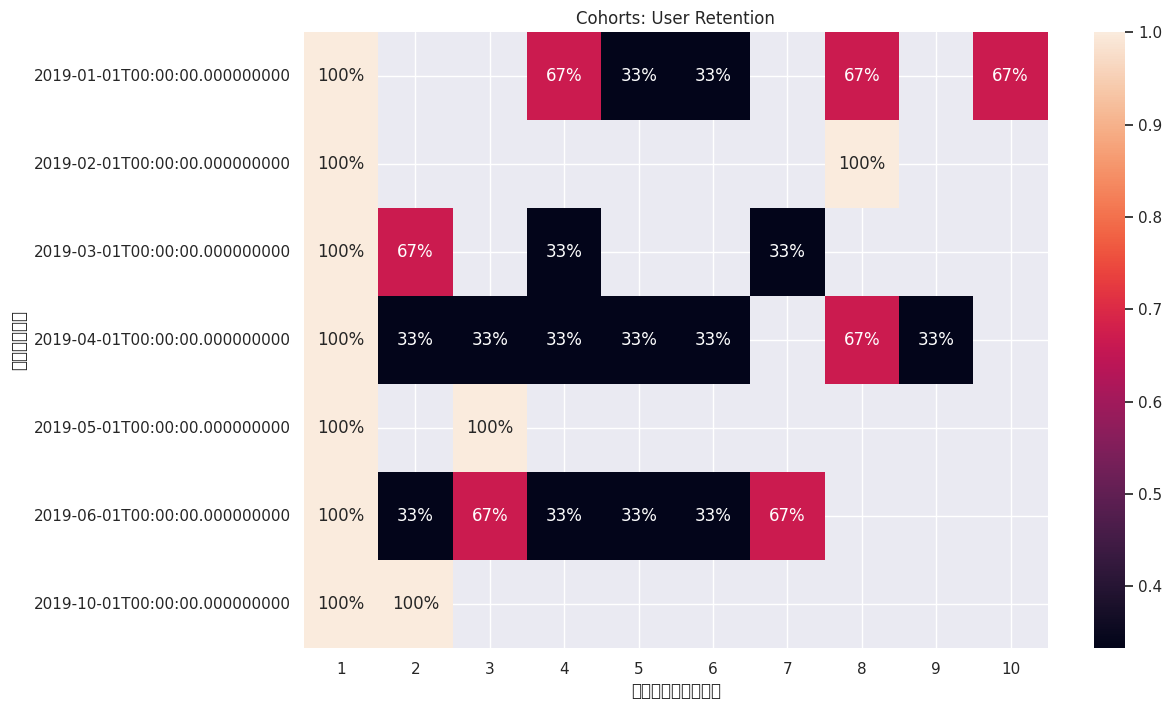

주이용카테고리가 Office일 때의 리텐션 평균 :  56.104166666666664
Office 카테고리를 이용해본 고객의 리텐션 평균 :  35.93521645021646


In [50]:
#주카테고리 = 특정 카테고리 와 해당 카테고리를 이용해본 사람간의 리텐션 차이 : Apparel,Nest-USA,Office
#Apparel과 Nest-USA, Office를 타깃으로 기본적으로 리텐션이 단순 해당 카테고리를 이용만 해봤던 고객보다 높다는 사실을 증명할 수 있다.
main_a=df_3.loc[df_3['주이용카테고리']=="Apparel",'고객ID'].unique().tolist()
main_n=df_3.loc[df_3['주이용카테고리']=="Nest-USA",'고객ID'].unique().tolist()
main_o=df_3.loc[df_3['주이용카테고리']=="Office",'고객ID'].unique().tolist()

a=retention_m(df_3.loc[df_3['고객ID'].isin(main_a)])
n=retention_m(df_3.loc[df_3['고객ID'].isin(main_n)])
o=retention_m(df_3.loc[df_3['고객ID'].isin(main_o)])

#주이용카테고리가 Apparel일 때 리텐션
heatmap(a)
print("주이용카테고리가 Apparel일 때의 리텐션 평균 : ",a.mean().mean() )

#Apparel 카테고리를 이용만해본 고객의 리텐션
use_a=df_3.loc[df_3['제품카테고리']=="Apparel",'고객ID'].unique().tolist()
print("Apparel 카테고리를 이용해본 고객의 리텐션 평균 : ",retention_m(df_3.loc[df_3['고객ID'].isin(use_a)]).mean().mean())

#주이용카테고리가 Nest-USA일 때 리텐션
heatmap(n)
print("주이용카테고리가 Nest-USA일 때의 리텐션 평균 : ",n.mean().mean() )

#Nest-USA 카테고리를 이용만해본 고객의 리텐션
use_n=df_3.loc[df_3['제품카테고리']=="Nest-USA",'고객ID'].unique().tolist()
print("Nest-USA 카테고리를 이용해본 고객의 리텐션 평균 : ",retention_m(df_3.loc[df_3['고객ID'].isin(use_n)]).mean().mean())

#주이용카테고리가 Office일 때 리텐션
heatmap(o)
print("주이용카테고리가 Office일 때의 리텐션 평균 : ",o.mean().mean() )

#Office 카테고리를 이용만해본 고객의 리텐션
use_o=df_3.loc[df_3['제품카테고리']=="Office",'고객ID'].unique().tolist()
print("Office 카테고리를 이용해본 고객의 리텐션 평균 : ",retention_m(df_3.loc[df_3['고객ID'].isin(use_o)]).mean().mean())


세가지 제품에 대하여 모두 주이용카테고리일 때 고객의 리텐션 평균이 상승한 것을 볼 수 있다. 따라서 향후에 고객세분화를 통해 나온 silver/bronze 고객에 대상으로 주이용카테고리 확립해주는 것을 목적으로 한다.

#### **1-6-3) 이용해본 카테고리 수에 따른 고객 생애 가치 시각화**

**결론** : 고객별로 이용해본 카테고리 수가 많을 수록 고객생애가치도 함께 높아지는 것을 확인할 수 있었다. 따라서 향후에 VIP/Diamond 고객에 대상으로 이용해본 카테고리 수를 확장하는 것을 목표로 한다.

(0.0, 120.0)

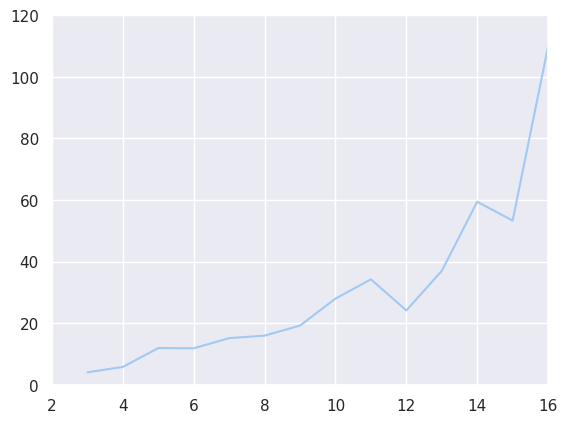

In [51]:
n_check=df_on3.groupby(['이용카테고리수'])[['고객지역','가입기간','구매횟수','평균구매금액','고객생애가치']].mean()
n_check

n_check.reset_index().corr()
plt.plot(n_check['고객생애가치'])
plt.xlim(2,16)
plt.ylim(0,120)

### 1-7) 최종 데이터 만들기

In [52]:
df_on['년'] = df_on['거래날짜'].dt.year
df_on['일'] = df_on['거래날짜'].dt.day
month_dict = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
df_dis['월']= df_dis['월'].replace(month_dict)
df_mar.columns = ['거래날짜', '오프라인비용', '온라인비용']
df_mar['거래날짜'] = pd.to_datetime(df_mar['거래날짜'])

In [53]:
# 1. onlines와 customer 데이터 합치기 (고객ID 기준으로)
#pd.merge(df_on,df_cus,on=['고객ID'],how='left')
# 2. onlines + customer + discount 데이터 합치기 (제품 카테고리 - 월 을 기준으로)
#pd.merge(pd.merge(df_on,df_cus,on=['고객ID'],how='left'),df_dis, on=['제품카테고리','월'],how='left')
# 3. onlines +customer + discount + maketing 데이터 합치기 (거래 날짜를 기준으로)
df = pd.merge(pd.merge(pd.merge(df_on,df_cus,on=['고객ID'],how='left'),df_dis, on=['제품카테고리','월'],how='left'),df_mar,on=['거래날짜'],how='left')

In [54]:
df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,총구매금액,구매횟수,평균구매금액,평균구매빈도,고객생애가치,거래날짜달기준,최초거래날짜,최초구매일로부터달,다음구매날짜,다음쿠폰상태,최종금액,재구매날까지의일,월,년,일,성별,고객지역,가입기간,쿠폰코드,할인율,오프라인비용,온라인비용
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,153.71,0.0,1,2019,1,남,Chicago,12,ELEC10,10.0,4500,2424.5
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,153.71,0.0,1,2019,1,남,Chicago,12,ELEC10,10.0,4500,2424.5
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Not Used,2.05,0.0,1,2019,1,남,Chicago,12,OFF10,10.0,4500,2424.5
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,87.65,0.0,1,2019,1,남,Chicago,12,SALE10,10.0,4500,2424.5
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,16.50,0.0,1,2019,1,남,Chicago,12,AIO10,10.0,4500,2424.5


# 2.전체 고객에 대한 솔루션 제공 :
Part 1에서 진행했던 EDA 부분에서 나온 결론을 총집합하여 고객 세분화 하기 이전, 전체 고객에 대한 솔루션을 제공한다

- ### **전략 1 : 주목해야 할 제품 카테고리에 대한 구매 유도 전략**

    - 고객이 Apparel, Nest-USA, Office를 주요 이용 카테고리 설정하기 위해서는 해당 이용 카테고리의 거래 수를 늘리는 것을 목표로 해야 한다.
        
         → 1-5-2의 값을 활용하여, 고객이 하루에 각 카테고리에 대하여 Apparel : 13번,  Nest-USA :12번, Office : 50번의 횟수를 구매하게 된다면, 해당 카테고리 제품에 대하여 10% 쿠폰을 제공해준다.
        
    - Drinkware, Apparel, Bags, Office, Waze, Headgear를 구매하는 고객에 한해 카테고리 내의 인기 제품의 구매를 유도한다.
        
        → 1-5-2의 값을 활용하여, 고객이 하루에 각 카테고리에 대하여 Drinkware: 32.7, Apparel: 187, Bags: 81 , Office: 17, Waze: 14 , Headgear: 24.74 금액 이상 구매하게 된다면, 아래의 값을 참고하여, 해당 카테고리 제품 내에 인기 제품을 포함하여 구매할 시 30% 쿠폰을 제공한다.
        
        - Apparel : 'Product_0520', 'Product_0519', 'Product_0922', 'Product_0398', 'Product_0399', 'Product_0521', 'Product_0362'
        - Drinkware : 'Product_0892', 'Product_0882', 'Product_0900', 'Product_0181', 'Product_0891'
        - Bags : ‘Product_0864’,‘Product_0865’,‘Product_0858’
        - Office : 'Product_0904', 'Product_0969', 'Product_0952', 'Product_0852'
        - Waze : 'Product_1017', 'Product_1008', 'Product_1000'
        - Headgear : 'Product_0926'
        


- ### **전략2 : 여성과 남성의 구매 특성에 맞는 구매 유도 전략**

    - 여성은 Apparel, Bags, Office 카테고리를 2-3달 주기로 구매하는 경향을 보이므로, 2~3달 주기에 따라 마케팅 전략을 수립한다.
    - 남성은 Nest-USA를 5개월 주기로, Office는 3-4달 주기로 구매하는 경향을 고려하여 마케팅 전략을 수립한다.

    


- ### **전략3 : 고객이 구매한 날짜를 기반으로 마케팅 전략**

    - 고객생애가치가 높은 고객이 주로 거래하는 요일인 월요일, 수요일, 토요일에 홍보 비용이 더 많이 드는 오프라인 마케팅을 진행했을 때, 1-4-4) 의 결과를 참고하면, 고객의 참여도가 많을 확률이 높으므로 오프라인 마케팅을 진행하도록 한다.
    - 고객생애가치가 낮은 고객이 주로 거래하는 요일인 화요일과 목요일에는 장바구니에 담아뒀던 제품의 알람을 보내는 방식으로 온라인 마케팅을 진행하도록 한다.

#3.RFM 기법과 제품 구매 가치를 통하여, 고객 세분화 진행

### **3-1) RFM을 진행한 이유**

거래횟수가 52924행인 것에 비해, 고객의 수는 1468명인 것을 볼 수 있다.
이는 한명의 고객이 여러번의 구매를 한 것으로 보이기 때문에, 거래 횟수가 2번 이상인 고객을 확인해보니 1402명 즉 95.5% 고객이 2번 이상 거래를 하는 것으로 볼 수 있다.

다만, 같은 날짜에 여러번 구매한 경우가 많아 고객 별로 다른 거래 날짜가 2개 이상인 경우에 고객의 수는 확인해보니 734명 즉 50% 정도인 것으로 보아 다른 날짜에 재방문 하는 고객의 수는 현저히 줄어드는 것을 확인해볼 수 있었다.


따라서 Recency : 얼마나 최근에 구매했는가,Frequency : 얼마나 자주 구매했는가,
Monetary : 얼마나 많은 금액을 지출했는가를 확인해볼 수 있는 RFM 기법을 사용하여 고객의 구매 패턴을 파악해보려고 한다.

In [55]:
print(f"온라인거래가 일어난 횟수 : {len(df)}")
print(f"온라인거래를 이용한 고객 수 : {len(df['고객ID'].unique())}")
print(f"거래 횟수가 2번 이상인 고객 수  : {len(df.groupby('고객ID')['거래날짜'].size()[df.groupby('고객ID')['거래날짜'].size() > 1])}")
print(f"고객별로 서로 다른 거래 날짜가 두 개 이상인 고객 수  : {len(df.groupby('고객ID')['거래날짜'].nunique()[df.groupby('고객ID')['거래날짜'].nunique() > 1])}")

온라인거래가 일어난 횟수 : 52924
온라인거래를 이용한 고객 수 : 1468
거래 횟수가 2번 이상인 고객 수  : 1402
고객별로 서로 다른 거래 날짜가 두 개 이상인 고객 수  : 734


In [56]:
# 원본 데이터셋 복사

rfm_online_sales = df.copy()
rfm_online_sales['최종가격'] = rfm_online_sales['평균금액']*rfm_online_sales['수량']
# 날짜 형식 변환
rfm_online_sales['거래날짜'] = pd.to_datetime(rfm_online_sales['거래날짜'])

# 데이터 내 마지막 날짜 계산
last_date = rfm_online_sales['거래날짜'].max()

# Recency 계산
recency_data = rfm_online_sales.groupby('고객ID')['거래날짜'].max().reset_index()
recency_data['Recency'] = (last_date - recency_data['거래날짜']).dt.days

# Frequency 계산
frequency_data = rfm_online_sales.groupby('고객ID')['거래ID'].count().reset_index()
frequency_data.rename(columns={'거래ID': 'Frequency'}, inplace=True)

# Monetary 계산
rfm_online_sales['SalesValue'] = rfm_online_sales['수량'] * rfm_online_sales['최종가격']
monetary_data = rfm_online_sales.groupby('고객ID')['SalesValue'].sum().reset_index()
monetary_data.rename(columns={'SalesValue': 'Monetary'}, inplace=True)

# RFM 데이터 결합
rfm_data = recency_data.merge(frequency_data, on='고객ID').merge(monetary_data, on='고객ID')

In [57]:
# rfm_data : 고객별로 R, F, M 값 구함
rfm_data.head(2)

,고객ID,거래날짜,Recency,Frequency,Monetary
0,USER_0000,2019-09-15,107,2,41.99
1,USER_0001,2019-11-02,59,60,413396.44


### **3-2) 제품 구매가치를 구해서, 포함시킨 이유**

고객이 구매한 상품의 특성 또한 고객의 구매 영향에 미치기도 하는데 RFM 분석은  R,F,M 3가지 요인으로만 분석한다는 단점이 존재한다. 따라서 고객이 어떠한 제품을 구입하였는지까지 고려할 수 있는 P (product) 요인을 추가한 다음 R,F,M,P 값을 사용하여 고객 세분화를 진행해보려고 한다.

Product 요인을 추가하는 방법

1. Onlinesales_info 데이터에서 제품 카테고리별 구매된 횟수 (count)
2. 제품 카테고리별 구매된 금액 / 구매된 횟수 (1회 주문 금액)
3. (count) * (1회 주문금액)을 곱해서 순차적으로 가장 낮은 값을 가지는 제품 카테고리는 1을 갖도록 가장 높은 값을 가지는 카테고리는 20의 값을 가지게 함 (구매가치)
4. 고객이 구매한 모든 제품 카테고리에 대하여 각각 제품 카테고리별 구매한 횟수 * 각 카테고리별 구매가치를 구한다음 더한다 (고객_지표)

  ex) A라는 고객이 Housewares를 10번사고, Android를 5번 샀을 때, 10x1 (housewares 구매한 횟수 * housewares 구매가치) + 5x2 (Android를 구매한 횟수 * Android를 구매가치) = 20 -> A라는 고객의 최종고객지표는 20을 가진다.

In [58]:
# 1. Onlinesales_info 데이터에서 제품 카테고리별 구매된 횟수 (count)
show_df = pd.DataFrame()
product_count = []
product_price = []
for value in list(df['제품카테고리'].value_counts().index):
  count = len(df.loc[df['제품카테고리']==value])
  product_count.append(count)
  price = df.loc[df['제품카테고리']==value,'평균금액'].sum()/count
  product_price.append(price)
count_df = pd.DataFrame({'product':list(df['제품카테고리'].value_counts().index),'count':product_count})
count_df.reset_index(drop=True,inplace=True)
show_df = count_df.set_index('product')
count_dict = count_df.set_index('product')['count'].to_dict()

# 2.제품 카테고리별 구매된 금액 / 구매된 횟수 (1회 주문 금액)
price_df = pd.DataFrame({'product':list(df['제품카테고리'].value_counts().index),'price':product_price})
price_df.sort_values(by='price', ascending=False,inplace=True)
price_df.reset_index(drop=True,inplace=True)
show_df = pd.concat([show_df,price_df.set_index('product')],axis=1)
price_dict = price_df.set_index('product')['price'].to_dict()

# 3. (count) * (1회 주문금액)을 곱해서 가장 낮은 값을 가지는 제품 카테고리는 부터 1을 갖도록 가장 높은 값을 가지는 카테고리는 20의 값을 가지도록 카테고리별 구매가치 계산
product_values_for_df = [count_dict[product] * price_dict[product] for product in count_dict]
product_values = {product: count_dict[product] * price_dict[product] for product in count_dict}
value_df = pd.DataFrame({'product':list(df['제품카테고리'].value_counts().index),'count*price':product_values_for_df})
value_df.sort_values(by='count*price', ascending=False,inplace=True)
value_df.reset_index(drop=True,inplace=True)
show_df = pd.concat([show_df,value_df.set_index('product')],axis=1)
sorted_products = sorted(product_values, key=product_values.get)
index_dict = {index: i for i, index in enumerate(sorted_products, start=1)}
show_df.sort_values('count*price',inplace=True)
show_df['구매가치'] = list(range(1,21))
show_df

,count,price,count*price,구매가치
product,,,,
Housewares,122,2.060574,251.39,1
Android,43,15.903488,683.85,2
More Bags,46,19.776957,909.74,3
Bottles,268,3.437201,921.17,4
Fun,160,6.743812,1079.01,5
Google,105,16.446190,1726.85,6
Accessories,234,8.211068,1921.39,7
Waze,554,6.607852,3660.75,8
Backpacks,89,80.046404,7124.13,9


In [59]:
# 4.고객이 구매한 제품 카테고리별 구매한 횟수 * 각 카테고리별 구매가치를 구한다음 더해 최종 고객 지표를 만듦
customer_product_count = df.groupby(['고객ID', '제품카테고리']).size().reset_index(name='구매_횟수')
customer_product_count['제품_가치'] = customer_product_count['제품카테고리'].map(index_dict)
customer_product_count['최종_제품_가치'] = customer_product_count['구매_횟수'] * customer_product_count['제품_가치']
customer_value_indicator = customer_product_count.groupby('고객ID')['최종_제품_가치'].sum().reset_index(name='고객_지표')
customer_value_indicator.head(3)

,고객ID,고객_지표
0,USER_0000,32
1,USER_0001,1034
2,USER_0002,344


In [60]:
rfm_data= pd.merge(rfm_data,customer_value_indicator,on='고객ID')
rfm_data.head(3)

,고객ID,거래날짜,Recency,Frequency,Monetary,고객_지표
0,USER_0000,2019-09-15,107,2,41.99,32
1,USER_0001,2019-11-02,59,60,413396.44,1034
2,USER_0002,2019-10-19,73,23,33503.96,344



### **3-3) R , F, M, P를 고려하여 RFMP SCORE를 만들기**


앞에서  구한 R, F, M, P 값들을 고려해서 최종 RFMP SCORE를 만들기 위해서 기계학습 기법과 기술 통계량을 활용하여, 고객이 갖는 변수의 특성을 고려하면서도 객관화된 방법으로 가중치를 산출하고자 한다. ( 가중치를 선정하는 기법은 "RFM 모형의 가중치 선택에 관한 연구"의 내용을 참고하였다.)



1. R, F, M , P변수에 대한 데이터 표준화
2. Elbow Method 방법을 활용한 최적의 K값 탐색
3. 각 지표별로 K-Means Clustering 알고리즘을 활용하여 전체 고객 데이터를 K개의 그룹으로 군집화
4. K개로 분류된 그룹1, 그룹2, …, 그룹K에 대하여 각각 R, F, M ,P값의 CV(Coefficient ofvariation, 변동계수)를 산출하고 전체 집단과의 비율을 활용
5. w1,w2,w3,w4 값을 구하기
6. W1, W2, W3, W4값을 구하기
7. 구하고자 하는 값 : W1*R + W2*F + W3*M + W4*P



#### 5,6번에 대하여 w1~w4 / W1 ~ W4를 구하는 방법 (식으로 작성)

변동 계수(CV)는 데이터의 흩어짐을 나타내는 지표이며, 변동 계수가 작을수록 데이터의 흩어짐이 작다는 것을 의미한다.
해당 열의 wn (n= R,F,M,P)이 크다는 것은 n열에 대하여 군집화 결과가 다른 열에 비해 더 작은 변동 계수를 갖고 있어서, 데이터의 흩어짐이 작다는 것을 의미합니다. 이는n열의 군집화가 다른 열에 비해 더 일관된 패턴을 나타내고 있으며, 따라서 데이터의 특성을 더 잘 반영하기 때문에 다른 열들보다 큰 가중치를 가지게 해 최종 점수를 계산하는 방식이다.


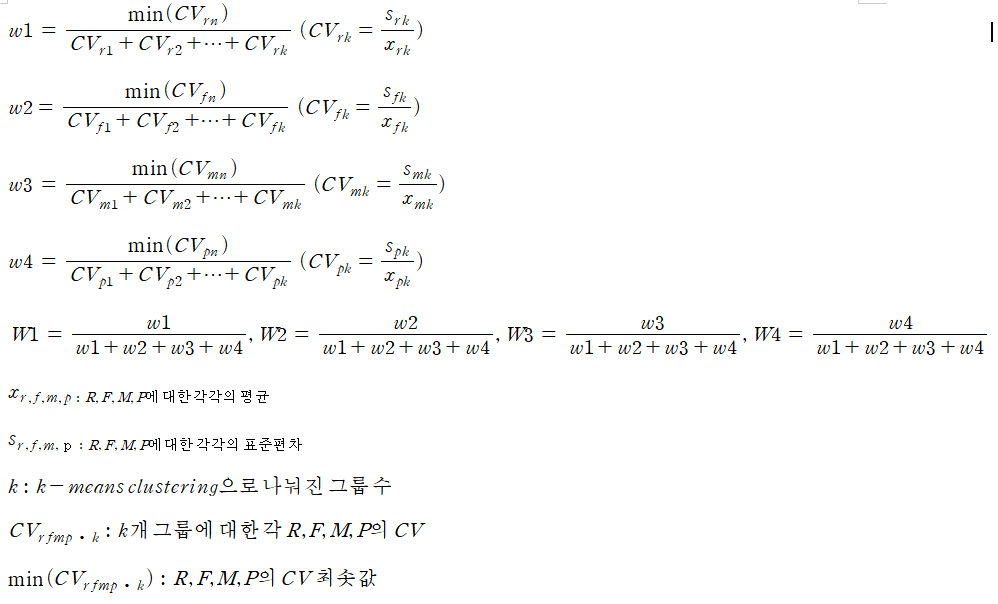

In [62]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# 2. Elbow Method 그래프를 통하여 R,F,M,P에 대하여 최적의 k개수 정하기
def plot_elbow_curve(data, col,max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    # Elbow Method 그래프 플로팅
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o', linestyle='--')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title(col +' of Elbow Method graph')
    plt.show()

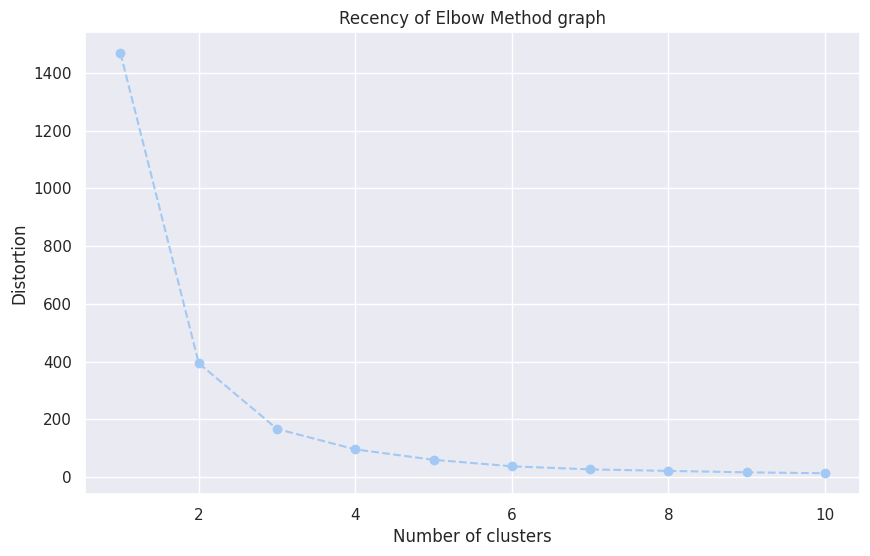

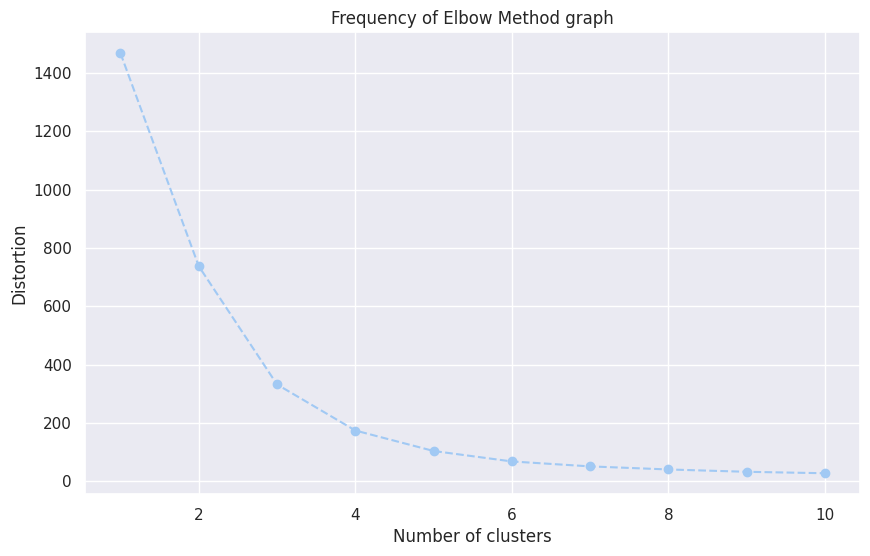

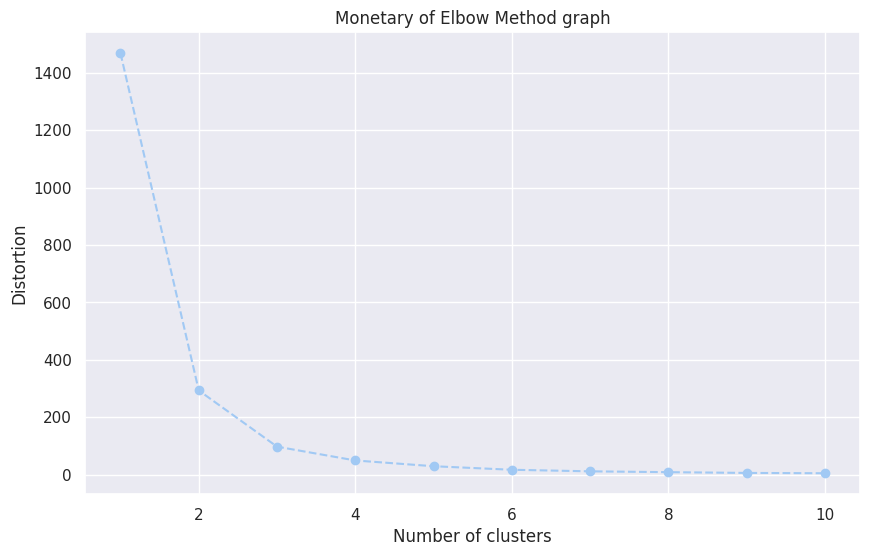

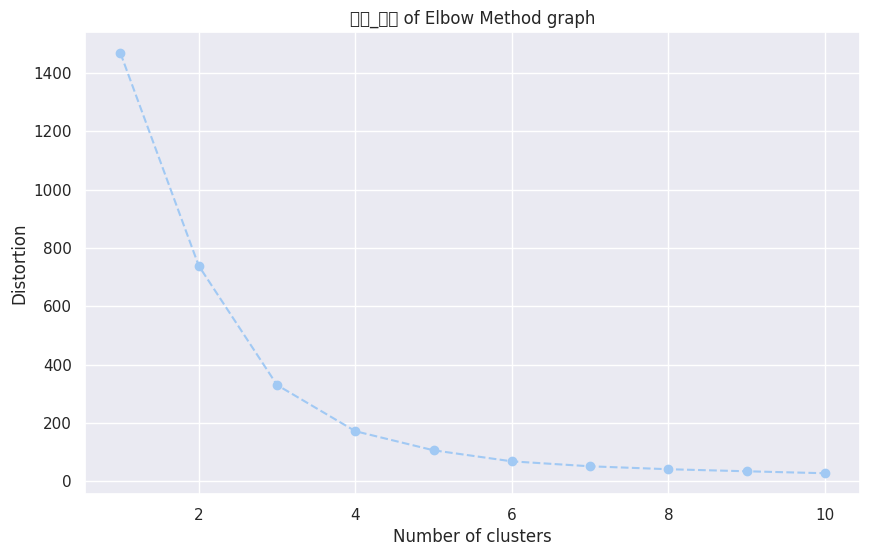

In [63]:
import warnings
warnings.filterwarnings("ignore")
for col in ['Recency','Frequency','Monetary','고객_지표']:
  scaler = StandardScaler() # 각 지표별로 클러스터링을 진행하기 위하여 표
  df_scale = pd.DataFrame(scaler.fit_transform(rfm_data[[col]]))
  plot_elbow_curve(df_scale,col)

R,F,M,P에 대하여 elbow method 그래프를 통하여
R은 군집을 3개로 , F는 군집을 4개로, M은 군집을 2개로, P는 군집을 4개로 두어 각각 kmeans 군집화를 실행하고, 각 지표별 군집에 대한 기술통계량을 사용해서 최종적으로 사용하는 가중치 값을 결정하려고 한다

In [64]:
# 5.w1,w2,w3,w4 값을 구하는 함수, rfm_data, 구하고 싶은 열의 이름, 해당 열이 진행하기로 한 클러스터의 개수 (2번에서 정함)
def geteachcolumnsweight(df_p,col,cluster_num):
  # 1.R, F, M , P변수에 대한 데이터 표준화
  scaler = StandardScaler()
  df_scale = pd.DataFrame(scaler.fit_transform(df_p[[col]]))
  df_scale.columns = [col]
  # 3. 각 지표별로 K-Means Clustering 알고리즘을 활용하여 전체 고객 데이터를 K개의 그룹으로 군집화
  kmeans_model = KMeans(n_clusters= cluster_num, random_state= 100)
  kmeans_model.fit(df_scale) # 학습
  df_p['Cluster'] = kmeans_model.predict(df_scale)
  CV_list = []
  weight_list = []
  for i in range(cluster_num): # 앞에 식에서 설명했던 w1,w2,w3,w4를 구하는 방식이다.
    mean_list=[]
    std_list = []
    CV_list.append(math.sqrt(df_p.loc[df_p['Cluster']==i].var()[0])/df_p.loc[df_p['Cluster']==i].mean()[0])
  weight = min(CV_list) / sum(CV_list)
  return weight

# 6.W1, W2, W3, W4값을 구하는 함수
def getfinalweight(w1,w2,w3,w4):
  final_sum = w1+w2+w3+w4
  W1 = w1/ final_sum
  W2 = w2/ final_sum
  W3 = w3/ final_sum
  W4 = w4/ final_sum
  return W1,W2,W3,W4

# 5번에서 말한 w1,w2,w3,w4를 구하기 위해서 함수 호출
w1 = geteachcolumnsweight(rfm_data,'Recency',3)
w2 = geteachcolumnsweight(rfm_data,'Frequency',4)
w3 = geteachcolumnsweight(rfm_data,'Monetary',2)
w4 = geteachcolumnsweight(rfm_data,'고객_지표',4)
print(f"변동계수를 사용하여 구한 가중치는 다음과 같다, 해당 값이 크다는 것은 군집화가 다른 열에 비해 더 일관된 패턴을 가졌다는 것을 의미한다.  w1:{w1}, w2:{w2}, w3:{w3}, w4:{w4},")

# 6번에서 말한 W1,W2,W3,W4를 구하기 위해서 함수 호출
W1,W2,W3,W4 = getfinalweight(w1,w2,w3,w4)
print(f"각 열에 쓰일 최종 가중치 값은 다음과 같다 W1:{W1}, W2:{W2}, W3:{W3}, W4:{W4},")
rfm_data.drop(columns=['Cluster'],inplace=True)

# 7.구하고자 하는 값 : W1R + W2F + W3M + W4P
rfm_data['RFMP_SCORE'] = rfm_data['Recency']*W1+ rfm_data['Frequency']*W2 + rfm_data['Monetary']*W3 +  rfm_data['고객_지표']*W4

변동계수를 사용하여 구한 가중치는 다음과 같다, 해당 값이 크다는 것은 군집화가 다른 열에 비해 더 일관된 패턴을 가졌다는 것을 의미한다.  w1:0.13820795836583935, w2:0.17492439386570188, w3:0.3550536911120684, w4:0.1734079338117129,
각 열에 쓰일 최종 가중치 값은 다음과 같다 W1:0.16422165808861536, W2:0.20784891362574265, W3:0.421882404995563, W4:0.20604702329007893,


In [65]:
rfm_data.head(2)

,고객ID,거래날짜,Recency,Frequency,Monetary,고객_지표,RFMP_SCORE
0,USER_0000,2019-09-15,107,2,41.99,32,42.295762
1,USER_0001,2019-11-02,59,60,413396.44,1034,174639.896959



### **3-4) RFMP SCORE을 통해 6개의 고객으로 나눔**

In [66]:
rfm_data['cluster'] = pd.qcut(rfm_data['RFMP_SCORE'], 6, labels=[6,5,4, 3, 2, 1])
rfm_data.head(3)
for i in range(1,7):
  print(f"클러스터 {i}의 RFMPSCORE 평균 {rfm_data.loc[rfm_data['cluster']==i,'RFMP_SCORE'].mean()} , 클러스터 {i}에 속하는 고객의 수 :{len(rfm_data.loc[rfm_data['cluster']==i,])}")

클러스터 1의 RFMPSCORE 평균 168545.1856848946 , 클러스터 1에 속하는 고객의 수 :245
클러스터 2의 RFMPSCORE 평균 10282.659123275647 , 클러스터 2에 속하는 고객의 수 :244
클러스터 3의 RFMPSCORE 평균 4133.093503593459 , 클러스터 3에 속하는 고객의 수 :245
클러스터 4의 RFMPSCORE 평균 1835.7193284576113 , 클러스터 4에 속하는 고객의 수 :244
클러스터 5의 RFMPSCORE 평균 709.2279114662125 , 클러스터 5에 속하는 고객의 수 :245
클러스터 6의 RFMPSCORE 평균 151.26426946910917 , 클러스터 6에 속하는 고객의 수 :245


In [67]:
np.round(rfm_data.groupby('cluster')['RFMP_SCORE'].describe().iloc[:,[3,7]],2)

,min,max
cluster,,
6,14.38,375.70
5,377.45,1161.02
4,1166.14,2668.83
3,2709.26,5920.53
2,5962.80,18135.32
1,18463.72,3719942.57


In [68]:
df = df.merge(rfm_data[['고객ID','cluster']],on='고객ID')
df.head(2)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,총구매금액,구매횟수,평균구매금액,평균구매빈도,고객생애가치,거래날짜달기준,최초거래날짜,최초구매일로부터달,다음구매날짜,다음쿠폰상태,최종금액,재구매날까지의일,월,년,일,성별,고객지역,가입기간,쿠폰코드,할인율,오프라인비용,온라인비용,cluster
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,153.71,0.0,1,2019,1,남,Chicago,12,ELEC10,10.0,4500,2424.5,1
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,20483.98,297,68.96963,0.813699,56.120493,2019-01-01,2019-01-01,1,2019-01-01,Used,153.71,0.0,1,2019,1,남,Chicago,12,ELEC10,10.0,4500,2424.5,1


# 4.클러스터 포함

### **4-1) 클러스터 별 구매 패턴 파악**
클러스터 1은 거래량 , 구매 수량, 평균 금액량 , 한번 구매시 평균 금액량이 모두 가장 높은 고객이며 클러스터 6으로 가면 갈수록, 해당 값들이 점점 감소하는 것을 확인할 수 있다.
따라서 각 클러스터 고객들을 아래과 같이 정의하도로 하겠다.

클러스터1 : VIP

클러스터2 : Diamond

클러스터3 : Platinum

클러스터4 : Gold

클러스터5 : Silver

클러스터6 : Bronze

.


거래량의 65%를 차지할만큼, 구매가 활발하게 이뤄지는 VIP/Diamond 집단에 대해서는 집단별 특성을 반영하여 이미 구매를 잘하고 있는 제품 이외에 고객이 다양한 제품을 구매할 수 있는 크로스셀링 기법을 목표로 한다.

거래량의 26%를 차지하는 정도로 많이는 아니지만 그래도 자주 구매하는 Platinum/Gold 집단에 대해서는 구매율을 높이기 위하여 장바구니 분석을 통한 묶음 상품 리스트를 만들어서 평소 구매한 제품과 함께 새로운 제품을 구매할 기회를 할인된 가격으로 제공한다.

거래량의 9%를 차지하는 정도로 구매가 잘 이뤄지지 않는 Silver/Bronze 집단에 대해서는 이탈방지를 위하여 주카테고리 활성화를 목표로 한다.

.


위 세가지 방법들에 대한 자세한 설명은 각 카테고리 부분에서 진행하도록 하겠다.





In [69]:
# 세그먼트 분리
VIP = df[df['cluster'] == 1]
Diamond = df[df['cluster'] == 2]
Platinum = df[df['cluster'] == 3]
Gold = df[df['cluster'] == 4]
Silver = df[df['cluster'] == 5]
Bronze = df[df['cluster'] == 6]

df_list = [VIP,Diamond,Platinum,Gold,Silver,Bronze]
value_df = pd.DataFrame()
for i,df_p in enumerate(df_list):
  total_count= int(len(df_p))
  count_value= int(sum(df_p.groupby('고객ID')['수량'].sum()))
  price_value = int(sum(df_p.groupby('고객ID')['최종금액'].sum()))
  once_price = int(price_value/total_count)
  value_list = [total_count,count_value,price_value,once_price]
  col = str(i+1) + '클러스터의 고객들의 구매이력'
  new_df = pd.DataFrame({col:value_list})
  new_df.index = ["총 거래량","총 구매 수량","평균금액량",'한번 구매 시 평균금액량']
  value_df = pd.concat([value_df,new_df],axis=1)
value_df

,1클러스터의 고객들의 구매이력,2클러스터의 고객들의 구매이력,3클러스터의 고객들의 구매이력,4클러스터의 고객들의 구매이력,5클러스터의 고객들의 구매이력,6클러스터의 고객들의 구매이력
총 거래량,21776,12694,8852,5036,3331,1235
총 구매 수량,147307,47897,24230,10892,5951,1756
평균금액량,2176194,1101696,734206,409354,203805,45537
한번 구매 시 평균금액량,99,86,82,81,61,36


### 4-2) VIP /Diamond 고객  : 제품 구매 카테고리를 늘리는 방안

(0.0, 120.0)

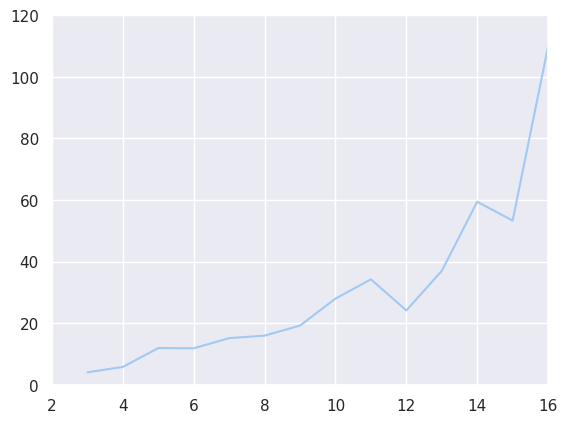

In [70]:
plt.plot(n_check['고객생애가치'])
plt.xlim(2,16)
plt.ylim(0,120)

이용카테고리 수가 많을수록 고객생애주기가 높은 고객이 많이 분포하고 있다 많은 카테고리를 사용하기에 구매횟수,평균구매금액이 오를 수 있다는 부분만 명심한다면 유의미하게 사용할 수 있을 것이다.

VIP /Diamond는 전체 거래량의 65%를 차지하고 있을만큼, 거래량 / 구매수량 모두 높은 고객이다. 앞에서 보여준 이용 카테고리수의 증가에 따라 고객생애주기가 높아지는 것으로 보아 VIP /Diamond에게는 이미 거래했던 카테고리 개수보다 더 많은 카테고리 수를 이용할 수 있게끔 해당 고객이 구매한 카테고리를 바탕으로 다른 카테고리의 제품을 추천해주는 크로스셀링 진행하려고 한다.

1. 고객이 주문한 제품 카테고리의 **종류 개수** 구하기 : **n** (n=1~20)

2. 고객이 주문한 유니크한 제품 카테고리 **종류 리스트** 구하기 : **customer_list**

3. 고객이 추가로 제품 카테고리를 구매하도록 목표로 삼는 제품 카테고리의 **종류 개수** 구하기 : **K : 짝수** (n이 짝수면 k = n+2, n이 홀수면 k= n+1)

4. 제품 카테고리의 종류 개수를 k개와 k+1개를 구매하는 유니크한 제품 카테고리를 리스트가 존재할 때 각 제품 카테고리 별로 리스트 안에 몇번 담겨져있는 지를 파악하여 많이 담기는 **k개의 제품 카테고리를 발견**하기 : **target_list**.

5. target_list는 고객이 목표로 삼는 카테고리 종류의 개수를 사는 사람들이 주로 사는 품목이므로, 만약 해당 고객이 target_list에 들어있는 제품을 구매하지 않는다면, **target_list 안에 들어있는 제품을 해당 고객에게 추천**해주기.

6. **recommend_list : target_list와 customer_list 차집합** ,
recommend _list에 들어있는 개수가 (k-n : 고객이 추가로 사야하는 제품 카테고리 개수)보다 크다면, recommend list에 들어있는 제품 카테고리 중 어느 제품을 사야할 지를 결정하기 위하여 해당 df에 대해서 **장바구니 분석**을 통해서 A제품을 사면 B 제품을 사는 경향이 있다 라는 결과에 대해서 [A,B] 이런식으로 리스트를 저장한다.최종적으로는 [[A,B],[B,C],[B,D],[B,C,D],[A,D]] 이런 식으로 저장되어있음 : **basket_list**

7. recommend_list 안에 들어있는 제품 카테고리(X)와 customer_list 안에 들어있는 제품 카테고리(y)를 하나씩 비교해가면서, **둘의 값([X,Y])이 basket_list에 들어있다면 X에 대해서 +1** 의 값을 가지도록 한다.
따라서 최종적으로는 recommend_list안에 들어있는 제품 카테고리들 중 count가 많이된 **제품 순서대로 고객이 추가적으로 사야하는 카테고리 수만큼 추천**해준다.
(이때 모든 [X,Y]가 basket_list에 없다면 다 0의 값을 가지기 때문에 이때는 무작위로 제품 카테고리를 추천해준다.)

### 예시 (step1 ~ step5까지의 예시)
A라는 고객이 구매한 유니크한 카테고리 종류 개수 5

고객이 주문한 유니크한 제품 카테고리 종류 리스트 : ['a','b','c','d','e']

고객이 추가로 제품 카테고리를 구매하도록 목표로 삼는 제품 카테고리의 종류 개수 : 6개

- 제품 카테고리의 종류 개수가 6개와 7개를 구매하는 고객들의 수 : 3명

- target_list

product_list = ['a','b','c','d','e','f','g','h','i']

cus1 =  ['a','b','c','d','e','f']

cus2 =  ['a','b','c','d','e','i]

cus3 =  ['a','b','c','h','e','i']

-> a : 3번, b :3번, c:3번,d:2번,e:3번,f:1번,g:0번, h: 1번 ,i:2번 이런식으로 counting한 후 내림차순으로 6번째 제품까지 고름

target_list : ['a','b','c','d','e','i']

- recommend list : ['i']



In [71]:
# 1.고객이 주문한 제품 카테고리의 종류 개수 구하기 : n (n=1~20)
# 2. 고객이 주문한 유니크한 제품 카테고리 종류 리스트 구하기 : customer_list

def cutertomerpurchase_numandlist(df_p, user_id):
  users_index = df_p[df_p['고객ID'] == user_id].index
  user_list = []
  for idx in range(len(users_index)):
    user_list.append(df_p.loc[users_index[idx],'제품카테고리'])
    user_list = set(user_list)
    user_list = list(user_list)
  return len(user_list), user_list

In [72]:
# 3. 고객이 추가로 제품 카테고리를 구매하도록 목표로 삼는 제품 카테고리의 종류 개수 구하기
def target_num(n):
  if n%2 ==0:
    target = n+2
  else:
    target = n+1
  return target

In [73]:
# 4.제품 카테고리의 종류 개수를 k개와 k+1개를 구매하는 유니크한 제품 카테고리를 리스트가 존재할 때 각 제품 카테고리 별로 리스트 안에 몇번 담겨져있는 지를 파악하여 많이 담기는 k개의 제품 카테고리를 발견하기
def gettargetcategory(df_p,k):
  product_list = df['제품카테고리'].unique() # 전체 df에 존재하는 제품카테고리 개수
  df_grouped = pd.DataFrame(df_p.groupby('고객ID')['제품카테고리'].nunique()) # 각 고객별로 구매한 제품카테고리의 종류수가 담겨져 있는 df

  user_id_list = []
  for i in range(len(df_grouped)):
    if k<=df_grouped.iloc[i].values[0] <= k+1:
      user_id_list.append(df_grouped.index[i]) # k개와 k+1개의 제품 카테고리를 구매하는 고객의 고객 ID 리스트

  purchase_product = []
  for user in user_id_list: # 하나의 고객에 대해서
      users_index = df_p[df_p['고객ID'] == user].index # 해당 고객이 구매한 이력이 있는 index를 찾음
      user_purchase = []
      for idx in range(len(users_index)):
        user_purchase.append(df_p.loc[users_index[idx],'제품카테고리']) # 고객이 구매한 이력에서 구매한 제품 카테고리를 모두 저장
        user_purchase = set(user_purchase) # 유니크한 제품 카테고리만 구하기
        user_purchase = list(user_purchase)
      purchase_product.append(user_purchase) # k개 or k+1개의 유니크한 제품 카테고리를 구매한 고객들이 산 유니크한 제품 카테고리 저장

  NestUSA_count = 0;Office_count = 0;Apparel_count =0;Bags_count = 0;Drinkware_count = 0;Lifestyle_count = 0;Waze_count = 0;
  Headgear_count = 0;Fun_count = 0;Google_count = 0;NotebooksJournals_count = 0;
  Backpacks_count = 0;NestCanada_count = 0;Housewares_count = 0;Bottles_count = 0;Nest_count = 0;Android_count = 0
  Accessories_count = 0;GiftCards_count = 0;MoreBags_count = 0
  count_list = [NestUSA_count, Office_count, Apparel_count, Bags_count, Drinkware_count, Lifestyle_count, Waze_count,
                Headgear_count, Fun_count, Google_count, NotebooksJournals_count,
                Backpacks_count, NestCanada_count, Housewares_count, Bottles_count, Nest_count, Android_count,
                Accessories_count, GiftCards_count, MoreBags_count]

  for customer_product in purchase_product: # customer_product : 각 고객이 구매한 제품 카테고리가 저장되어 있음
      for j, pro in enumerate(product_list): # 전체 df가 가지고 있는 각 제품 카테고리에 대해서
          if pro in customer_product: # 고객이 구매한 제품 카테고리라면
              count_list[j] += 1 # 해당 제품에 대해서 +1을 해준다
  # counting이 많이 되었다는건, 해당 고객들에 대해서 많이 구매된 제품이기 때문에 counting된 횟수를 기준으로 target 숫자인 k만큼 뽑아낸다
  target_list = [product_list[i] for i in sorted(range(len(count_list)), key=lambda x: count_list[x], reverse=True)[:k]]
  return target_list

In [74]:
# 6.해당 df에 대해서 장바구니 분석을 통해서 A제품을 사면 B 제품을 사는 경향이 있다 라는 결과에 대해서 [A,B] 이런식으로 리스트를 저장한다.
# 최종적으로는 [[A,B],[B,C],[B,D],[B,C,D],[A,D]] 이런 식으로 저장되어있음 : basket_list
def encoding(x):
    if x<=0:
        return 0
    if x>=1:
        return 1

def get_basket_list(df,column):
  Trans=df.groupby(['고객ID','거래ID']).size().reset_index(name='고유_거래ID')
  Trans['고유_거래ID']=np.arange(1,len(Trans)+1)
  df = df.merge(Trans[['고객ID','거래ID','고유_거래ID']],on=['고객ID','거래ID'])
  Transaction = df.groupby(['고유_거래ID',column])[column].count().reset_index(name='Count')
  basket = Transaction.pivot_table(index='고유_거래ID', columns=column, values='Count', aggfunc='sum').fillna(0)
  # 0, 1 로 변환해주는 함수
  # applying the function to the dataset
  basket = basket.applymap(encoding)
  freq_item = apriori(basket, min_support = 0.01,use_colnames = True)
  rules = association_rules(freq_item, metric = "lift", min_threshold = 1)
  rules.sort_values('confidence', ascending = False, inplace = True)
  basket_list = []
  for i in range(len(rules)):
    mini_list = []
    mini_list.append(next(iter(rules['antecedents'].values[i])))
    mini_list.append(next(iter(rules['consequents'].values[i])))
    basket_list.append(mini_list)
  return basket_list

# 7.제품 카테고리들 중 count가 많이된 제품 순서대로 고객이 추가적으로 사야하는 카테고리 수만큼 추천
def apiori_recommend(customer_list,target_list,basket_list):
  recommend_list = list(set(target_list).difference(customer_list))
  num = len(target_list) - len(customer_list)
  if len(recommend_list) <=num:
    final_product_limit = recommend_list
  else: # recoomend_list 중에 num 만큼 뽑아야됨
    similarity_scores = [0] * len(recommend_list)
    for idx,rec in enumerate(recommend_list):
      for cus in customer_list:
        list1 =[]
        list1.append(rec)
        list1.append(cus)
        for sublist in basket_list:
          if all(item in sublist for item in list1):
            similarity_scores[idx] +=1
    final_product_limit = [recommend_list[i] for i in sorted(range(len(similarity_scores)), key=lambda x: similarity_scores[x], reverse=True)[:num]]
  return final_product_limit

In [75]:
# 5. target_list는 고객이 목표로 삼는 카테고리 종류의 개수를 사는 사람들이 주로 사는 품목이므로, 만약 해당 고객이 target_list에 들어있는 제품을 구매하지 않는다면, target_list 안에 들어있는 제품을 해당 고객에게 추천해주기.
def get_recommend_list(df_p,user_list,target_list):
  recommend_list = list(set(target_list).difference(user_list))
  num = len(target_list) - len(user_list)
  if len(recommend_list) <= num: # 추천 리스트의 수 == 고객이 사야하는 카테고리의 수 -> 추천리스트 구매
    pass
  else: # 추천리스트수 >= 고객이 사야하는 카테고리의 수 -> step 6,7의 함수를 불러와서 추천리스트 중 장바구니 분석 결과를 사용하여 고객이 사야하는 카테고리의 수만큼만 뽑아 추천해준다
    basket_list = get_basket_list(df_p,'제품카테고리')
    plus_rec= apiori_recommend(user_list,target_list,basket_list)
    recommend_list = plus_rec
  return recommend_list

In [76]:
# 각 스텝별로 함수를 사용하는 방법 (예시)
user_id = 'USER_1358'
# step 1,2
n,customer_list = cutertomerpurchase_numandlist(VIP,user_id)
# step 3
k = target_num(n)
# step4
target_list = gettargetcategory(VIP,k)
# step 5,6,7
recommend_list = get_recommend_list(VIP,customer_list,target_list)

print(f"{user_id}의 고객이 구매한 제품 카테고리 수는 {n}개이며, 구매한 제품카테고리는 {customer_list}이다.")
print(f"고객이 도달해야하는 제품 카테고리의 개수는 {k}이며, 추가적으로 구매하길 추천하는 제품카테고리는 종류는 {recommend_list}이다. ")

USER_1358의 고객이 구매한 제품 카테고리 수는 15개이며, 구매한 제품카테고리는 ['Backpacks', 'Drinkware', 'Fun', 'Google', 'Apparel', 'Notebooks & Journals', 'Bottles', 'Waze', 'Office', 'Housewares', 'Nest-Canada', 'Nest-USA', 'Headgear', 'Lifestyle', 'Bags']이다.
고객이 도달해야하는 제품 카테고리의 개수는 16이며, 추가적으로 구매하길 추천하는 제품카테고리는 종류는 ['Nest']이다. 


최종적으로 고객의 구매 특성을 파악하여 제품카테고리 추천하는 예시

In [77]:
def final_recomend(df_p,user_id):
  n,customer_list = cutertomerpurchase_numandlist(df_p,user_id)
  recommend_list = get_recommend_list(df_p,customer_list,gettargetcategory(df_p,target_num(n)))
  print(f"{user}의 고객이 구매한 제품 카테고리 수는 {n}개이며, 고객이 도달해야하는 제품 카테고리의 개수는 {target_num(n)}이며, 추가적으로 구매하길 추천하는 제품카테고리는 종류는 {recommend_list}이다.")

In [78]:
user_list = VIP['고객ID'].unique()[:10]
for user in user_list:
  final_recomend(VIP, user)
  print()

USER_1358의 고객이 구매한 제품 카테고리 수는 15개이며, 고객이 도달해야하는 제품 카테고리의 개수는 16이며, 추가적으로 구매하길 추천하는 제품카테고리는 종류는 ['Nest']이다.

USER_0736의 고객이 구매한 제품 카테고리 수는 17개이며, 고객이 도달해야하는 제품 카테고리의 개수는 18이며, 추가적으로 구매하길 추천하는 제품카테고리는 종류는 ['Backpacks']이다.

USER_0541의 고객이 구매한 제품 카테고리 수는 16개이며, 고객이 도달해야하는 제품 카테고리의 개수는 18이며, 추가적으로 구매하길 추천하는 제품카테고리는 종류는 ['Android', 'Google']이다.

USER_1267의 고객이 구매한 제품 카테고리 수는 12개이며, 고객이 도달해야하는 제품 카테고리의 개수는 14이며, 추가적으로 구매하길 추천하는 제품카테고리는 종류는 ['Gift Cards', 'Bottles']이다.

USER_0281의 고객이 구매한 제품 카테고리 수는 12개이며, 고객이 도달해야하는 제품 카테고리의 개수는 14이며, 추가적으로 구매하길 추천하는 제품카테고리는 종류는 ['Gift Cards', 'Fun']이다.

USER_0867의 고객이 구매한 제품 카테고리 수는 11개이며, 고객이 도달해야하는 제품 카테고리의 개수는 12이며, 추가적으로 구매하길 추천하는 제품카테고리는 종류는 ['Nest']이다.

USER_0484의 고객이 구매한 제품 카테고리 수는 12개이며, 고객이 도달해야하는 제품 카테고리의 개수는 14이며, 추가적으로 구매하길 추천하는 제품카테고리는 종류는 ['Notebooks & Journals', 'Fun']이다.

USER_1382의 고객이 구매한 제품 카테고리 수는 12개이며, 고객이 도달해야하는 제품 카테고리의 개수는 14이며, 추가적으로 구매하길 추천하는 제품카테고리는 종류는 ['Notebooks & Journals', 'Nest']이다.

USER_0138의 고객이 구매한 제품 카테고리 수는 13개이며, 고객이 

### 4-3)  Platinum/Gold :재구매율을 높히기 위해, 제품 추천 방안

* 세그먼트 3과 4의 재구매율을 높히기 위해서 각 세그먼트에서 구매횟수가 상위 25%인 사람들의 장바구니를 분석하여 어떤 상품을 구매했을 때 해당상품과 연계해서 구매하는 물건을 분석한 후 묶음 상품으로 할인된 가격으로 판매해서 구매율 증진을 목표로 한다.

예시) A물건과 B물건의 연계 구매율이 높다고 했을 때, A-B 묶음 상품에는 20%할인을 적용하는 방법

3-2-1) Platinum

Platinum의 구매횟수 상위 25%인 고객을 상대로 장바구니 분석을 통해 연계돼서 구매되는 제품 분석

In [79]:
#구매횟수 상위 25%고객 추출
q3 = Platinum['구매횟수'].quantile(0.75)
Platinum_top = Platinum[Platinum['구매횟수'] > q3]

# 구매횟수 상위 25%고객 장바구니 석
Trans=Platinum_top.groupby(['고객ID','거래ID']).size().reset_index(name='고유_거래ID')
Trans['고유_거래ID']=np.arange(1,942)

top_3= Platinum_top.copy()
top_3=pd.merge(top_3,Trans,on=['고객ID','거래ID'])

Transaction = top_3.groupby(['고유_거래ID','제품ID'])['제품ID'].count().reset_index(name='Count')

basket = Transaction.pivot_table(index='고유_거래ID', columns='제품ID', values='Count', aggfunc='sum').fillna(0)

# 0, 1 로 변환해주는 함수
def encoding(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
basket = basket.applymap(encoding)

freq_item = apriori(basket, min_support = 0.01,use_colnames = True)
freq_item

,support,itemsets
0,0.010627,(Product_0184)
1,0.012752,(Product_0185)
2,0.014878,(Product_0195)
3,0.010627,(Product_0202)
4,0.010627,(Product_0206)
5,0.018066,(Product_0228)
6,0.011690,(Product_0535)
7,0.026567,(Product_0854)
8,0.021254,(Product_0880)
9,0.012752,(Product_0882)


In [80]:
# 묶음 상품의 개수는 2개인 것이 이상적이기 때문에 2개의 연계 상품만 추출
n = freq_item[freq_item['itemsets'].apply(lambda x: len(x)) == 2]
n

,support,itemsets
37,0.015940,"(Product_0916, Product_0915)"
38,0.017003,"(Product_0917, Product_0915)"
39,0.013815,"(Product_0917, Product_0916)"
40,0.010627,"(Product_0916, Product_0918)"
41,0.011690,"(Product_0917, Product_0918)"
42,0.030818,"(Product_0983, Product_0976)"


결론 :

Platinum 집단에 대해서는 아래과 같은 묶음 상품을 팔아 추가구매를 유도한다


Product_0915 Product_0916 묶음 상품

Product_0915 Product_0917 묶음 상품

Product_0916 Product_0917 묶음 상품

Product_0916와 Product_0918 묶음 상품

Product_0918 Product_0917의 묶음 상품

Product_0976 Product_0983 묶음 상품


3-2-2) Gold

Gold의 구매횟수 상위 25%인 고객을 상대로 장바구니 분석을 통해 연계돼서 구매되는 제품 분석

In [81]:
#구매횟수 상위 25%고객 추출
q3 = Gold['구매횟수'].quantile(0.75)
Gold_top = Gold[Gold['구매횟수'] > q3]

# 구매횟수 상위 25%고객 장바구니 분석
Trans=Gold_top.groupby(['고객ID','거래ID']).size().reset_index(name='고유_거래ID')
Trans['고유_거래ID']=np.arange(1,537)

top_4= Gold_top.copy()
top_4=pd.merge(top_4,Trans,on=['고객ID','거래ID'])

Transaction = top_4.groupby(['고유_거래ID','제품ID'])['제품ID'].count().reset_index(name='Count')

basket = Transaction.pivot_table(index='고유_거래ID', columns='제품ID', values='Count', aggfunc='sum').fillna(0)

# 0, 1 로 변환해주는 함수
def encoding(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
basket = basket.applymap(encoding)

freq_item = apriori(basket, min_support = 0.01,use_colnames = True)
freq_item

,support,itemsets
0,0.013060,(Product_0184)
1,0.014925,(Product_0185)
2,0.014925,(Product_0201)
3,0.022388,(Product_0228)
4,0.011194,(Product_0230)
5,0.011194,(Product_0273)
6,0.013060,(Product_0443)
7,0.013060,(Product_0535)
8,0.011194,(Product_0539)
9,0.014925,(Product_0854)


In [82]:
# 묶음 상품의 개수는 2개인 것이 이상적이기 때문에 2개의 연계 상품만 추출
n = freq_item[freq_item['itemsets'].apply(lambda x: len(x)) == 2]
n

,support,itemsets
41,0.011194,"(Product_0880, Product_0894)"
42,0.011194,"(Product_0916, Product_0915)"
43,0.011194,"(Product_0917, Product_0915)"
44,0.011194,"(Product_0915, Product_0918)"
45,0.011194,"(Product_0917, Product_0916)"
46,0.013060,"(Product_0916, Product_0918)"
47,0.024254,"(Product_0983, Product_0976)"


결론 :

Gold 집단에 대해서는 아래과 같은 묶음 상품을 팔아 추가구매를 유도한다

Product_0880 Product_0894 묶음 상품

Product_0915 Product_0916 묶음 상품

Product_0915 Product_0917 묶음 상품

Product_0915 Product_0918 묶음 상품

Product_0916 Product_0917 묶음 상품

Product_0916 Product_0918 묶음 상품

Product_0976 Product_0983 묶음 상품


### 4-4) 클러스터 5,6 : 이탈방지를 위하여 주카테고리 제공

#####1) 하위 군집일수록 구매한 제품의 인기가 낮았기에, 하위 군집에만 속하는 장바구니 분석 결과가 이탈의 원인이 된 것은 아닌지 확인한다.

위 1-2의 결과를 바탕으로 하위 군집으로 내려갈수록 해당 군집이 구매한 제품ID의 인기(총판매량,총판매금액)의 평균이 우하향하는걸 확인할 수 있다.

해당 결과와 도메인 지식을 바탕으로 가설을 설정한다.

가설 :

1. 총판매량과 총판매액이 높다면 그렇지 않은 제품보다 제품력, 그에 따른 고객 만족도가 높은 제품일 가능성이 높을 것이다.

2. 제품ID를 기준으로 상위군집 1,2 군집의 장바구니 분석 결과와 하위 군집 5,6의 장바구니 분석을 비교하여 만약 상위 군집엔 없는데 하위 군집에만 있는 제품ID가 있다면, 총판매량과 총판매액을 확인한다. 만약, 해당 제품이 속하는 카테고리의 평균보다 못 미칠 시, 해당하는 제품들이 이탈의 원인은 아닐지 면밀한 관리 혹은 해당 제품ID 판매 중지 등의 조치가 필요할 것이다.

In [83]:
#장바구니 분석 전, 각 거래의 고유한 거래 ID를 생성해야 하는데, 현재 데이터프레임에서의 거래ID는 다른 고객ID일 때, 중복될 수 있으므로 고객ID, 거래ID를 묶어 새로운 '고유_거래ID' 컬럼을 완성하였다.
df_o = pd.merge(df_3,df, on=['가입기간', '거래ID', '거래날짜', '거래날짜달기준', '고객ID', '고객생애가치', '고객지역', '구매횟수', '다음구매날짜', '다음쿠폰상태',
 '배송료', '성별', '수량', '재구매날까지의일', '제품ID', '제품카테고리', '총구매금액', '최종금액', '최초거래날짜', '최초구매일로부터달', '쿠폰상태', '평균구매금액',
 '평균구매빈도', '평균금액'],how='left')
Trans=df_o.groupby(['고객ID','거래ID']).size().reset_index(name='고유_거래ID')
Trans['고유_거래ID']=np.arange(1,13426)

In [84]:
#장바구니 분석을 위한 형태로 데이터프레임을 수정해야 하기에 copy()한 후, 생성한 고유_거래ID를 붙여주었다.
df_a=df_o.copy()
df_a=pd.merge(df_a,Trans,on=['고객ID','거래ID'])

In [85]:
#클러스터별로 나누기 - 해당 클러스터에 해당하는 고객의 거래만을 추려준다.
a1=df_a.loc[df_a['cluster']==1]
a2=df_a.loc[df_a['cluster']==2]
a3=df_a.loc[df_a['cluster']==3]
a4=df_a.loc[df_a['cluster']==4]
a5=df_a.loc[df_a['cluster']==5]
a6=df_a.loc[df_a['cluster']==6]

a12=df_a.loc[(df_a['cluster']==1)|(df_a['cluster']==2)]
a56=df_a.loc[(df_a['cluster']==5)|(df_a['cluster']==6)]

In [86]:
#min_support를 0.01로 지정해주었다. (전체 거래 중 몇퍼센트 이상을 차지하는 조합만 보여줄 것인지에 대한 threshold)
ap12=ap(a12,'제품ID')
ap56=ap(a56,'제품ID')

상위 1,2 군집(VIP, Diamond)의 장바구니 분석

In [87]:
ap12

,support,itemsets
0,0.010845,(Product_0181)
1,0.014613,(Product_0195)
2,0.014061,(Product_0854)
3,0.021965,(Product_0880)
4,0.013418,(Product_0892)
5,0.012407,(Product_0894)
6,0.013694,(Product_0900)
7,0.029777,(Product_0904)
8,0.012775,(Product_0905)
9,0.010936,(Product_0907)


이탈위험고객(Cluster5,Cluster6)은 구매하는데 상위군집은 구매하지 않은 인기없는 제품을 찾고자 하는 것이기에 여러 제품의 조합은 제외하고 비교하였다.

위의 조건에 해당하는 제품ID는 다음의 6개였다.

'Product_0184','Product_0206','Product_0882','Product_0926','Product_0942','Product_0952'

In [88]:
#이탈군에서만 도출된 6개의 제품ID의 제품카테고리,총판매량,총판매액 확인
churn=['Product_0184','Product_0206','Product_0882','Product_0926','Product_0942','Product_0952']

hwak=df_o.loc[df_o['제품ID'].isin(churn)]

In [89]:
#비교 지표 - 카테고리별 평균 총판매수량,총판매금액
df_o.groupby('제품카테고리')[['총판매수량','총판매금액']].mean()

,총판매수량,총판매금액
제품카테고리,,
Accessories,195.595960,870.024747
Android,13.363636,217.817273
Apparel,160.348055,2139.575211
Backpacks,43.625000,3579.663393
Bags,1638.390873,13456.716637
Bottles,1041.818182,3400.440000
Drinkware,2803.781522,14385.344951
Fun,380.164948,2569.769588
Gift Cards,57.226667,4893.421600


In [90]:
#상위군집에는 없는데 하위군집 5,6(Silver,Bronze)에서만 나온 제품ID의 총판매량,총판매금액 확인 + 속해있는 카테고리 평균과 비교
hwak.groupby(['제품카테고리','제품ID'])['총판매수량','총판매금액'].mean().sort_values('총판매금액',ascending=False)

총판매수량     총판매금액
제품카테고리    제품ID                          
Drinkware Product_0882  1857.0  31223.63
Office    Product_0952  3141.0  25931.32
Headgear  Product_0926   712.0   9043.62
Office    Product_0942  4036.0   8968.64
          Product_0184  2082.0   3697.01
Apparel   Product_0206   272.0   2661.34

Office의 Product_0184의 경우, 총판매수량은 Office카테고리 평균 대비 3078→2082개, 총판매금액 또한 8732→3697로 매우 떨어지는 수치를 보였다.

따라서, 리뷰 등을 통한 소비자 반응 파악 혹은 직접적인 제품 조사를 통해 해당 제품을 확인해볼 것을 추천한다.

##### 2) 군집5,6(Silver,Bronze)에 대해 주카테고리를 바꾸긴 어렵다. 이미 정해진 내에서 구매횟수를 올릴 수 있도록 유도하여 리텐션율을 높이자!

In [91]:
ap_a=a12.loc[a12['제품카테고리']=="Apparel"]
ap_n=a12.loc[a12['제품카테고리']=="Nest-USA"]
ap_o=a12.loc[a12['제품카테고리']=="Office"]

ap_d=a12.loc[a12['제품카테고리']=="Drinkware"]
ap_l=a12.loc[a12['제품카테고리']=="Lifestyle"]

In [92]:
df_o.groupby(['cluster','주이용카테고리'])[['주이용횟수','고객지역','구매횟수','평균구매금액','고객생애가치']].agg(['count','mean']).dropna()

주이용횟수              구매횟수             평균구매금액             \
                   count       mean  count        mean  count       mean   
cluster 주이용카테고리                                                            
6       Apparel       66   9.333333     66   17.303030     66  24.928333   
        Office        24   5.000000     24   12.083333     24   7.869167   
        Waze          16   4.000000     16   16.000000     16  17.148750   
5       Apparel      252  11.222222    252   21.714286    252  39.860117   
        Nest-USA      52   5.846154     52   13.500000     52  59.411346   
        Office        31   5.709677     31   18.129032     31  32.574531   
4       Apparel      859  14.543655    859   36.925495    859  42.896201   
        Bags          26   5.000000     26   26.000000     26  44.211154   
        Nest-USA     448  11.770089    448   33.319196    448  65.110746   
        Office        15   7.000000     15   15.000000     15   6.646000   
3       Apparel     2338  22.099658   2338   55.285714   2338  46.572078   
        Lifestyle     29   7.000000     29   29.000000     29  38.820690   
        Nest-USA    1128  16.426418   1128   42.155142   1128  67.274197   
        Office        83   9.626506     83   30.566265     83  36.365663   
2       Apparel     4887  37.980765   4887   96.923266   4887  46.160429   
        Nest-USA    2260  27.407080   2260   73.077434   2260  67.961870   
        Office        27   7.000000     27   27.000000     27  32.679630   
1       Apparel    12463  92.563909  12463  260.617347  12463  47.351085   
        Nest-USA    2381  52.079378   2381  139.701806   2381  65.091315   
        Office       355  17.157746    355   64.301408    355  45.059636   

                  고객생애가치             
                   count       mean  
cluster 주이용카테고리                      
6       Apparel       66   1.316169  
        Office        24   0.750229  
        Waze          16   1.754027  
5       Apparel      252   5.655055  
        Nest-USA      52   2.171688  
        Office        31   5.493680  
4       Apparel      859   8.917043  
        Bags          26   2.624406  
        Nest-USA     448  16.799052  
        Office        15   0.227603  
3       Apparel     2338  15.082229  
        Lifestyle     29   3.855479  
        Nest-USA    1128  16.840592  
        Office        83   2.483963  
2       Apparel     4887  28.553400  
        Nest-USA    2260  26.721866  
        Office        27   7.453642  
1       Apparel    12463  82.145392  
        Nest-USA    2381  29.839331  
        Office       355  14.355004

기존의 인사이트에 더해 주이용카테고리가 같은 카테고리 내에서도 클러스터에 따라 해당 카테고리를 몇번 이용했는지에 대한 주이용횟수의 차이를 명확히 알아차릴 수 있었다.

In [93]:
#주이용카테고리별로 고객을 나눈다.
A=df_o.loc[df_o['주이용카테고리']=="Apparel"]
N=df_o.loc[df_o['주이용카테고리']=="Nest-USA"]

O=df_o.loc[df_o['주이용카테고리']=="Office"]


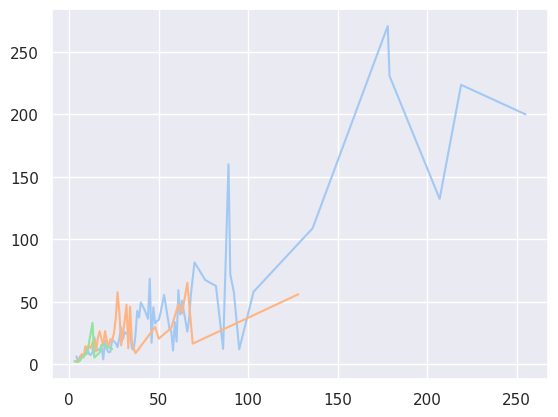

In [94]:
for i in [A,N,O]:
  plt.plot(i.groupby('주이용횟수')['고객생애가치'].mean())

카테고리별 조금의 차이는 있지만, 주이용카테고리를 이용해본 횟수가 높아질수록 고객생애주기가 우상향하는 패턴을 확인할 수 있다.

In [95]:
#고객기준으로 대입해야함. Apparel이 주카테고리인데 구매횟수가 하위 25인~ 상위 25인~
A['주이용횟수'].describe()

count    20865.000000
mean        67.425929
std         63.696329
min          4.000000
25%         27.000000
50%         44.000000
75%         76.000000
max        255.000000
Name: 주이용횟수, dtype: float64

In [96]:
#고객기준으로 대입해야함. Office가 주카테고리인데 구매횟수가 하위 25인~ 상위 25인~
N['주이용횟수'].describe()

count    6269.000000
mean       33.505663
std        27.350193
min         3.000000
25%        16.000000
50%        24.000000
75%        37.000000
max       128.000000
Name: 주이용횟수, dtype: float64

In [97]:
#nest는 안 나와서 50%로 수정
A_down=A.loc[A['주이용횟수']<=27,'고객ID']
A_up=A.loc[A['주이용횟수']>=76,'고객ID']

N_down=A.loc[A['주이용횟수']<=16,'고객ID']
N_up=A.loc[A['주이용횟수']>=37,'고객ID']

In [98]:
#같은 주이용카테고리 Apparel내에서
print("Apparel 이용횟수 하위 25%의 평균 리텐션 : ",retention_m(df_o.loc[df_o['고객ID'].isin(A_down)]).mean().mean())
print("Apparel 이용횟수 상위 25%의 평균 리텐션 : ",retention_m(df_o.loc[df_o['고객ID'].isin(A_up)]).mean().mean())

Apparel 이용횟수 하위 25%의 평균 리텐션 :  32.6517328042328
Apparel 이용횟수 상위 25%의 평균 리텐션 :  69.2063888888889


In [99]:
#같은 주이용카테고리 Nest-USA내에서
print("Nest-USA 이용횟수 하위 25%의 평균 리텐션 : ",retention_m(df_o.loc[df_o['고객ID'].isin(N_down)]).mean().mean())
print("Nest-USA 이용횟수 상위 25%의 평균 리텐션 : ",retention_m(df_o.loc[df_o['고객ID'].isin(N_up)]).mean().mean())

Nest-USA 이용횟수 하위 25%의 평균 리텐션 :  33.39011904761905
Nest-USA 이용횟수 상위 25%의 평균 리텐션 :  46.65739087301588


In [100]:
#Apparel 이용횟수 상위 25%의 장바구니 분석을 기반으로 이탈주의고객(클러스터 5,6)에게 상품을 추천한다.
ap(df_a.loc[df_a['고객ID'].isin(A_up)],"제품ID").sort_values('itemsets',ascending=False)

,support,itemsets
0,0.012095,(Product_0181)
29,0.021459,(Product_0990)
22,0.114319,(Product_0976)
23,0.015217,(Product_0980)
24,0.134608,(Product_0981)
25,0.117050,(Product_0983)
26,0.048771,(Product_0984)
27,0.040968,(Product_0985)
28,0.038236,(Product_0989)
30,0.022240,(Product_0992)


다음의 결과를 바탕으로 이탈주의(클러스터 5,6) 고객이 기존 가지고 있는 주이용카테고리를 더욱 적극적으로 이용하도록 만들 수 있다.

 그렇게 된다면 앞의 "주카테고리가 확립될 경우 그렇지 않은 고객에 비해 리텐션(재구매율)이 높다."는 EDA결과에 따라 고객 충성도 상승의 효과를 기대해 볼 수 있을 것이다.

### 4-5) 적절한 재구매 유도/마케팅 비용/주기 결정

EDA를 통해 마케팅 비용을 높혔을 때, 고객의 ARPPU와 리텐션이 증가한다는 사실을 토대로클러스터별 마케팅 비용을 높혔을 때 효과 차이를 분석하였다.

클러스터별 해석과 마케팅 데이터를 분석함에 있어서도 EDA와 같은 가정을 전제로 한 후 마케팅 분석을 진행하였다.

In [101]:
VIP['총마케팅비용'] = VIP['온라인비용'] + VIP['오프라인비용']
Diamond['총마케팅비용'] = Diamond['온라인비용'] + Diamond['오프라인비용']
Platinum['총마케팅비용'] = Platinum['온라인비용'] + Platinum['오프라인비용']
Gold['총마케팅비용'] = Gold['온라인비용'] + Gold['오프라인비용']
Silver['총마케팅비용'] = Silver['온라인비용'] + Silver['오프라인비용']
Bronze['총마케팅비용'] = Bronze['온라인비용'] + Bronze['오프라인비용']

# 광고일부터 14일까지의 구매데이터, CLV를 모두 더해서 날짜별로 새로운 데이터프레임을 만드는 함수 생성
def calculate_2weeks_marketing_metrics(cluster_df):
    cluster_df['날짜'] = cluster_df['거래날짜']
    cluster_df['날짜'] = pd.to_datetime(cluster_df['날짜'])
    cluster_df['거래날짜'] = pd.to_datetime(cluster_df['거래날짜'])

    cluster_df['2주뒤_날짜'] = cluster_df['날짜'] + pd.DateOffset(weeks=2)
    selected_rows = cluster_df[cluster_df['거래날짜'].between(cluster_df['날짜'], cluster_df['2주뒤_날짜'])]

    new_cluster = selected_rows.groupby('날짜').agg({
        '평균금액': 'sum',
        '고객ID': 'count',
    }).reset_index().rename(columns={'평균금액': '매출합', '고객ID': '고객수'})

    new_cluster = pd.merge(new_cluster, cluster_df[['날짜', '오프라인비용', '온라인비용', '총마케팅비용']], on='날짜', how='outer')

    week_cluster = new_cluster.drop_duplicates()
    week_cluster['ARPPU'] = week_cluster['매출합'] / week_cluster['고객수']
    cluster_df.drop(columns=['날짜'], inplace=True)

    return week_cluster

# 각 클러스터에 대해 함수를 적용
VIP_mar = calculate_2weeks_marketing_metrics(VIP)
Diamond_mar = calculate_2weeks_marketing_metrics(Diamond)
Platinum_mar = calculate_2weeks_marketing_metrics(Platinum)
Gold_mar = calculate_2weeks_marketing_metrics(Gold)
Silver_mar = calculate_2weeks_marketing_metrics(Silver)
Bronze_mar = calculate_2weeks_marketing_metrics(Bronze)

#### 4-5-1) 세그먼트 별 마케팅 비용 분석을 위해 마케팅 비용을 높혔을 때 효과가 있는 세그먼트를 먼저 확인

1. 각 세그먼트 별로 고객이 물건을 구매한 날짜의 평균 마케팅 비용



VIP 총마케팅비용 평균값: 4743.5009955914775
Diamond 총마케팅비용 평균값: 4784.970780683788
Platinum 총마케팅비용 평균값: 4633.068572074108
Gold 총마케팅비용 평균값: 4605.829880857824
Silver 총마케팅비용 평균값: 4762.641395977184
Bronze 총마케팅비용 평균값: 4783.861927125506


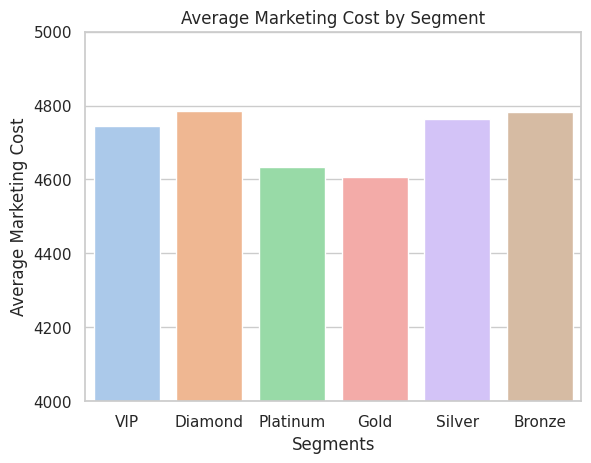

In [102]:
VIP_총마케팅비용_mean = VIP['총마케팅비용'].mean()
Diamond_총마케팅비용_mean = Diamond['총마케팅비용'].mean()
Platinum_총마케팅비용_mean = Platinum['총마케팅비용'].mean()
Gold_총마케팅비용_mean = Gold['총마케팅비용'].mean()
Silver_총마케팅비용_mean = Silver['총마케팅비용'].mean()
Bronze_총마케팅비용_mean = Bronze['총마케팅비용'].mean()

print("VIP 총마케팅비용 평균값:", VIP_총마케팅비용_mean)
print("Diamond 총마케팅비용 평균값:", Diamond_총마케팅비용_mean)
print("Platinum 총마케팅비용 평균값:", Platinum_총마케팅비용_mean)
print("Gold 총마케팅비용 평균값:", Gold_총마케팅비용_mean)
print("Silver 총마케팅비용 평균값:", Silver_총마케팅비용_mean)
print("Bronze 총마케팅비용 평균값:", Bronze_총마케팅비용_mean)

segment_means = [VIP_총마케팅비용_mean, Diamond_총마케팅비용_mean, Platinum_총마케팅비용_mean, Gold_총마케팅비용_mean, Silver_총마케팅비용_mean, Bronze_총마케팅비용_mean]

segments = ['VIP', 'Diamond', 'Platinum', 'Gold', 'Silver', 'Bronze']
sns.set_style("whitegrid")
sns.barplot(x=segments, y=segment_means, palette="pastel")

plt.title('Average Marketing Cost by Segment')
plt.xlabel('Segments')
plt.ylabel('Average Marketing Cost')
plt.ylim(4000, 5000)
plt.show()

* 세그먼트 별로 마케팅 비용의 큰 차이는 없지만, 그 중에서도 마케팅 비용이 높은 날짜에 많이 구매한 세그먼트는 Platinum과 Bronze이 있다.
* 이 결과로 마케팅 비용을 높혔을 때 효과를 많이 받는 세그먼트는 Platinum과 Bronze이라고 생각해볼 수 있으며, Platinum과 Bronze의 전환율을 높히기 위해서 마케팅을 활용해볼 수 있다.

2. 각 세그먼트 별로 마케팅 비용과 ARPPU의 상관관계 확인

상관관계가 높다면 마케팅 비용을 높혔을 때 ARPPU가 높아지는 것이기 때문에 ARPPU와 마케팅비용간의 피어슨 상관계수를 확인해보았다.


In [103]:
from scipy.stats import pearsonr
# 피어슨 상관계수 계산
correlation_VIP, _ = pearsonr(VIP_mar['ARPPU'], VIP_mar['총마케팅비용'])
correlation_Diamond, _ = pearsonr(Diamond_mar['ARPPU'], Diamond_mar['총마케팅비용'])
correlation_Platinum, _ = pearsonr(Platinum_mar['ARPPU'], Platinum_mar['총마케팅비용'])
correlation_Gold, _ = pearsonr(Gold_mar['ARPPU'], Gold_mar['총마케팅비용'])
correlation_Silver, _ = pearsonr(Silver_mar['ARPPU'], Silver_mar['총마케팅비용'])
correlation_Bronze, _ = pearsonr(Bronze_mar['ARPPU'], Bronze_mar['총마케팅비용'])

print("VIP 세그먼트의 피어슨 상관계수:", correlation_VIP)
print("Diamond 세그먼트의 피어슨 상관계수:", correlation_Diamond)
print("Platinum 세그먼트의 피어슨 상관계수:", correlation_Platinum)
print("Gold 세그먼트의 피어슨 상관계수:", correlation_Gold)
print("Silver 세그먼트의 피어슨 상관계수:", correlation_Silver)
print("Bronze 세그먼트의 피어슨 상관계수:", correlation_Bronze)

VIP 세그먼트의 피어슨 상관계수: 0.23917566134923118
Diamond 세그먼트의 피어슨 상관계수: 0.17594733633097567
Platinum 세그먼트의 피어슨 상관계수: 0.20972564632349375
Gold 세그먼트의 피어슨 상관계수: 0.17797220256535493
Silver 세그먼트의 피어슨 상관계수: 0.08567914739206621
Bronze 세그먼트의 피어슨 상관계수: 0.2114783021036862


* VIP와 Diamond, Bronze의 경우 어느정 마케팅비용이 ARPPU와 상관관계가 있다고 볼 수 있으며,나머지 세그먼트도 약한 상관관계는 가지고 있다.
* 따라서 세그먼트 VIP와 Diamond, Bronze의 경우 마케팅 비용이 높아지면 사용자당 평균 매출이 증가하고, 매출 증대를 위해 마케팅을 전략적으로 활용가능해 볼 수 있다.

3. 온/오프라인 마케팅 비용의 ARPPU와의 상관관계

>각 세그먼트 별로 온라인 마케팅과 오프라인 마케팅 중 어느 마케팅을 사용했을 때 매출증대에 효과가 있는 파악하기 위해 각각 나누어서 상관계수를 확인헤보았다.

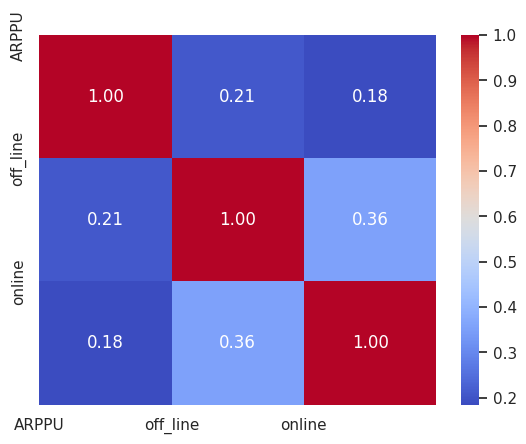

In [104]:
VIP_mar_subset = VIP_mar[['ARPPU', '오프라인비용', '온라인비용']]
new_x_labels = ['ARPPU', 'off_line', 'online']
new_y_labels =['ARPPU', 'off_line', 'online']
# heatmap 그리기
sns.heatmap(VIP_mar_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# x축 라벨 변경
plt.xticks(ticks=range(len(new_x_labels)), labels=new_x_labels)
plt.yticks(ticks=range(len(new_y_labels)), labels=new_y_labels)
plt.show()

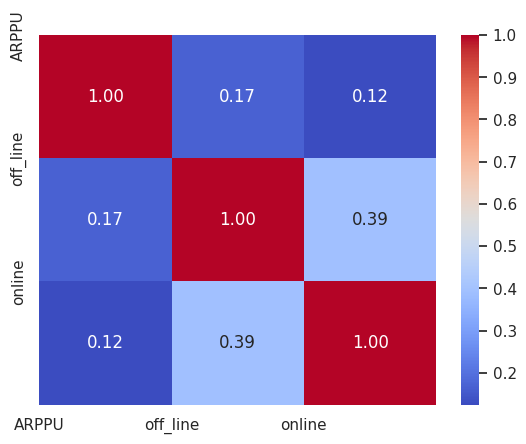

In [105]:
Diamond_mar_subset = Diamond_mar[['ARPPU', '오프라인비용', '온라인비용']]
new_x_labels = ['ARPPU', 'off_line', 'online']
new_y_labels =['ARPPU', 'off_line', 'online']
# heatmap 그리기
sns.heatmap(Diamond_mar_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# x축 라벨 변경
plt.xticks(ticks=range(len(new_x_labels)), labels=new_x_labels)
plt.yticks(ticks=range(len(new_y_labels)), labels=new_y_labels)
plt.show()

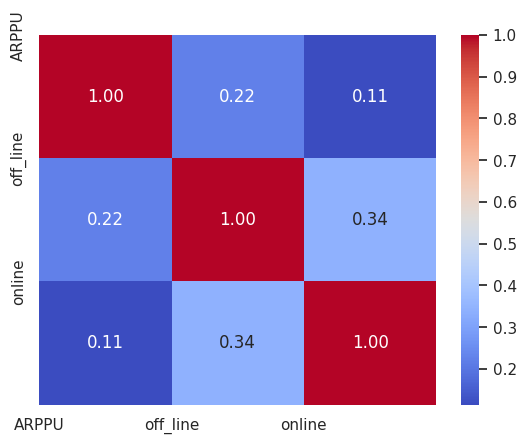

In [106]:
Platinum_mar_subset = Platinum_mar[['ARPPU', '오프라인비용', '온라인비용']]
new_x_labels = ['ARPPU', 'off_line', 'online']
new_y_labels =['ARPPU', 'off_line', 'online']
# heatmap 그리기
sns.heatmap(Platinum_mar_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# x축 라벨 변경
plt.xticks(ticks=range(len(new_x_labels)), labels=new_x_labels)
plt.yticks(ticks=range(len(new_y_labels)), labels=new_y_labels)
plt.show()

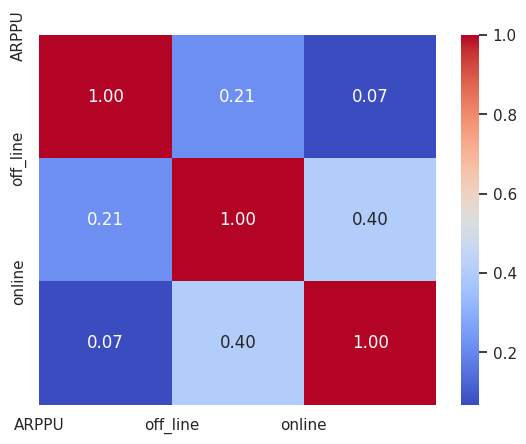

In [107]:
Gold_mar_subset = Gold_mar[['ARPPU', '오프라인비용', '온라인비용']]
new_x_labels = ['ARPPU', 'off_line', 'online']
new_y_labels =['ARPPU', 'off_line', 'online']
# heatmap 그리기
sns.heatmap(Gold_mar_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# x축 라벨 변경
plt.xticks(ticks=range(len(new_x_labels)), labels=new_x_labels)
plt.yticks(ticks=range(len(new_y_labels)), labels=new_y_labels)
plt.show()

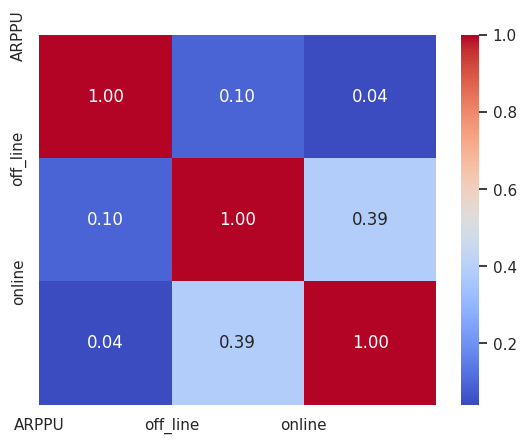

In [108]:

Silver_mar_subset = Silver_mar[['ARPPU', '오프라인비용', '온라인비용']]
new_x_labels = ['ARPPU', 'off_line', 'online']
new_y_labels =['ARPPU', 'off_line', 'online']
# heatmap 그리기
sns.heatmap(Silver_mar_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# x축 라벨 변경
plt.xticks(ticks=range(len(new_x_labels)), labels=new_x_labels)
plt.yticks(ticks=range(len(new_y_labels)), labels=new_y_labels)
plt.show()

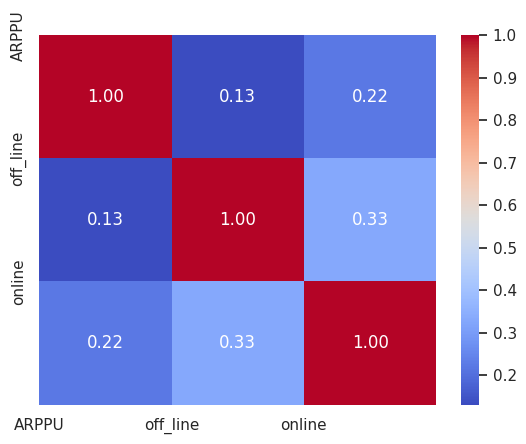

In [109]:

Bronze_mar_subset = Bronze_mar[['ARPPU', '오프라인비용', '온라인비용']]
new_x_labels = ['ARPPU', 'off_line', 'online']
new_y_labels =['ARPPU', 'off_line', 'online']
# heatmap 그리기
sns.heatmap(Bronze_mar_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# x축 라벨 변경
plt.xticks(ticks=range(len(new_x_labels)), labels=new_x_labels)
plt.yticks(ticks=range(len(new_y_labels)), labels=new_y_labels)
plt.show()

* VIP의 경우 오프라인 비용과 ARPU와의 상관관계가 온라인보다 조금 높았으며, 오프라인 온라인 둘 다 상관관계가0.2 부근으로 큰 차이가 있지는 않았다.
* Diamond의 경우 온라인은 0.08, 오프라인은 0.22로 오프라인 마케팅 비용을 높히는 것이 매출증대에 효과가 크다는 것을 알 수 있다.
* Bronze의 경우 온라인과의 상관관계는 0.24 오프라인과의 상관관계는 0.10으로 온라인이 앞도적으로 높았기 때문에 Bronze를 위한 마케팅 전략을 펼칠 때에는 온라인 비용을 높히는 것이 훨씬 효율적이라는 것을 알 수 있었다.

#### 정리

  **VIP, Diamond : 매출증대를 위해서 오프라인 마케팅 비용 증가가 효과적**

  **Platinum : 전환율을 높히기 위해서 마케팅 비용 증가가 효과적**

 **Bronze : 매출증대를 위해서 온라인 마케팅 비용 증가가 효과적**



#### 4-5-2) 재구매 유도를 위한 마케팅 주기 결정

마케팅 주기 결정을 위해 클러스터별 재구매까지 걸리는 평균 날짜를 구해보았다.\
(당일 구매한 이력이 여러 개 있을 때는 재구매로 계산하지 않고, 다른 날짜에 구매한 내력이 있는 것만 재구매로 계산)

 (Onlinesales_info분석에서 생성한 파생변수 `재구매날까지의일`사용)



In [110]:
# 각 세그먼트별로 0인 경우 같은 날 구매이력이 있는 경우 0으로 추가해두었기 때문에
# 같은 날에 구매한 값을 제외하기 위해서 0 을 제외한 평균을 구했다.
VIP_no_zero = VIP[VIP['재구매날까지의일'] != 0]
Diamond_no_zero = Diamond[Diamond['재구매날까지의일'] != 0]
Platinum_no_zero = Platinum[Platinum['재구매날까지의일'] != 0]
Gold_no_zero = Gold[Gold['재구매날까지의일'] != 0]
Silver_no_zero = Silver[Silver['재구매날까지의일'] != 0]
Bronze_no_zero = Bronze[Bronze['재구매날까지의일'] != 0]

# 각 세그먼트별로 0을 제외한 값들의 평균 계산
mean_VIP = VIP_no_zero['재구매날까지의일'].mean()
mean_Diamond = Diamond_no_zero['재구매날까지의일'].mean()
mean_Platinum = Platinum_no_zero['재구매날까지의일'].mean()
mean_Gold = Gold_no_zero['재구매날까지의일'].mean()
mean_Silver = Silver_no_zero['재구매날까지의일'].mean()
mean_Bronze = Bronze_no_zero['재구매날까지의일'].mean()

print('VIP가 재구매까지 걸리는 기간: ', mean_VIP)
print('Diamond가 재구매까지 걸리는 기간: ', mean_Diamond)
print('Platinum가 재구매까지 걸리는 기간: ', mean_Platinum)
print('Gold가 재구매까지 걸리는 기간: ', mean_Gold)
print('Silver가 재구매까지 걸리는 기간: ', mean_Silver)
print('Bronze가 재구매까지 걸리는 기간: ', mean_Bronze)

VIP가 재구매까지 걸리는 기간:  40.663636363636364
Diamond가 재구매까지 걸리는 기간:  62.355437665782496
Platinum가 재구매까지 걸리는 기간:  58.48148148148148
Gold가 재구매까지 걸리는 기간:  62.28502415458937
Silver가 재구매까지 걸리는 기간:  73.22413793103448
Bronze가 재구매까지 걸리는 기간:  67.82142857142857


3-4-3) 마케팅 요일 결정

> 세그먼트 별로 많이 구매하는 요일이 다를거라 생각하여 세그먼트 별 구매횟수가 많은 요일을 구해보았다.

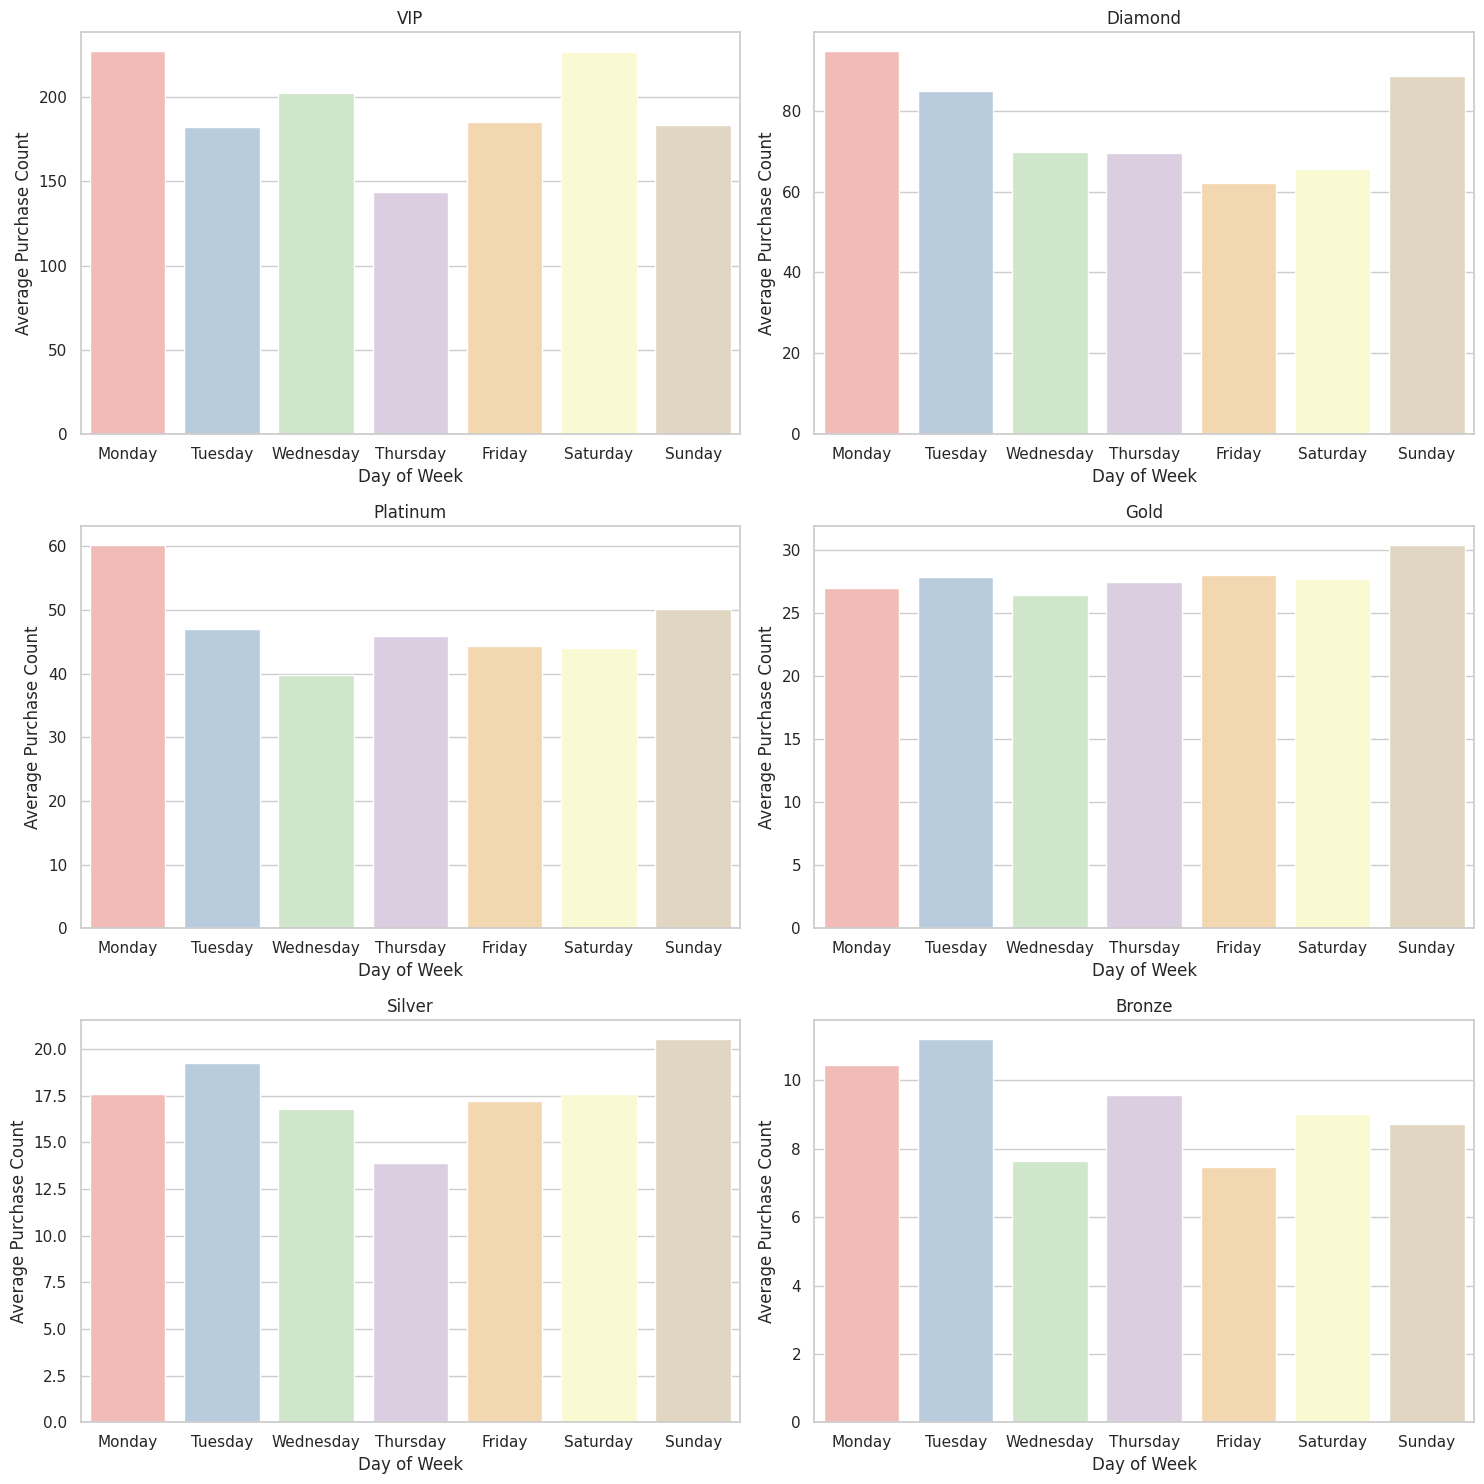

In [111]:
VIP['요일'] = VIP['거래날짜'].dt.day_name()
Diamond['요일'] = Diamond['거래날짜'].dt.day_name()
Platinum['요일'] = Platinum['거래날짜'].dt.day_name()
Gold['요일'] = Gold['거래날짜'].dt.day_name()
Silver['요일'] = Silver['거래날짜'].dt.day_name()
Bronze['요일'] = Bronze['거래날짜'].dt.day_name()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

VIP_day = VIP.groupby('요일').agg({'구매횟수': 'mean'}).reset_index()
Diamond_day = Diamond.groupby('요일').agg({'구매횟수': 'mean'}).reset_index()
Platinum_day = Platinum.groupby('요일').agg({'구매횟수': 'mean'}).reset_index()
Gold_day = Gold.groupby('요일').agg({'구매횟수': 'mean'}).reset_index()
Silver_day = Silver.groupby('요일').agg({'구매횟수': 'mean'}).reset_index()
Bronze_day = Bronze.groupby('요일').agg({'구매횟수': 'mean'}).reset_index()

plt.figure(figsize=(15, 15))

plt.subplot(3, 2, 1)
sns.barplot(x='요일', y='구매횟수', data=VIP_day, order=day_order, palette='Pastel1')
plt.title('VIP')
plt.xlabel('Day of Week')
plt.ylabel('Average Purchase Count')

plt.subplot(3, 2, 2)
sns.barplot(x='요일', y='구매횟수', data=Diamond_day, order=day_order, palette='Pastel1')
plt.title('Diamond')
plt.xlabel('Day of Week')
plt.ylabel('Average Purchase Count')

plt.subplot(3, 2, 3)
sns.barplot(x='요일', y='구매횟수', data=Platinum_day, order=day_order, palette='Pastel1')
plt.title('Platinum')
plt.xlabel('Day of Week')
plt.ylabel('Average Purchase Count')

plt.subplot(3, 2, 4)
sns.barplot(x='요일', y='구매횟수', data=Gold_day, order=day_order, palette='Pastel1')
plt.title('Gold')
plt.xlabel('Day of Week')
plt.ylabel('Average Purchase Count')

plt.subplot(3, 2, 5)
sns.barplot(x='요일', y='구매횟수', data=Silver_day, order=day_order, palette='Pastel1')
plt.title('Silver')
plt.xlabel('Day of Week')
plt.ylabel('Average Purchase Count')

plt.subplot(3, 2, 6)
sns.barplot(x='요일', y='구매횟수', data=Bronze_day, order=day_order, palette='Pastel1')
plt.title('Bronze')
plt.xlabel('Day of Week')
plt.ylabel('Average Purchase Count')

plt.tight_layout()
plt.show()

> 정리

**VIP 세그먼트:** 월요일

**Diamond 세그먼트:** : 월요일

**Platinum 세그먼트:** :월요일

**Gold 세그먼트:** : 일요일

**Silver 세그먼트:** : 일요일

**Bronze 세그먼트:** : 화요일

### 4-6) 쿠폰을 제공하는 상황 / 제공할 쿠폰

In [112]:
coupon_use_df = pd.DataFrame()
clu_list= ['VIP', 'Diamond' ,'Platinum', 'Gold' , 'Silver' ,'Bronze' ]
for clu,user_df in zip(clu_list,df_list):
  utu =0;utc = 0;utnu = 0;ctu =0;ctc = 0;ctnu = 0;nutu =0;nutc = 0;nutnu = 0;once=0
  users = list(user_df['고객ID'].unique()) # 클러스터별로 고객ID 리스트
  for user in users: # 하나의 고객에 대해서 그 고객의 구매 index 확인
    users_index = user_df[user_df['고객ID'] == user].index
    for idx in range(len(users_index)): # 클러스터별 -> 고객별 구매이력 확인
      if len(users_index) <= 1:
        once +=1
      else:
        if idx ==0: # 고객이 첫번째 구매할 경우 패스
          continue
        else:

          if user_df.loc[users_index[idx-1],'쿠폰상태'] =='Used' and user_df.loc[users_index[idx],'쿠폰상태'] =='Used':
            utu +=1
          elif user_df.loc[users_index[idx-1],'쿠폰상태'] =='Used' and user_df.loc[users_index[idx],'쿠폰상태'] =='Clicked':
              utc +=1
          elif user_df.loc[users_index[idx-1],'쿠폰상태'] =='Used' and user_df.loc[users_index[idx],'쿠폰상태'] =='Not Used':
              utnu +=1
          elif user_df.loc[users_index[idx-1],'쿠폰상태'] =='Clicked' and user_df.loc[users_index[idx],'쿠폰상태'] =='Used':
              ctu +=1
          elif user_df.loc[users_index[idx-1],'쿠폰상태'] =='Clicked' and user_df.loc[users_index[idx],'쿠폰상태'] =='Clicked':
              ctc +=1
          elif user_df.loc[users_index[idx-1],'쿠폰상태'] =='Clicked' and user_df.loc[users_index[idx],'쿠폰상태'] =='Not Used':
              ctnu +=1
          elif user_df.loc[users_index[idx-1],'쿠폰상태'] =='Not Used' and user_df.loc[users_index[idx],'쿠폰상태'] =='Used':
              nutu +=1
          elif user_df.loc[users_index[idx-1],'쿠폰상태'] =='Not Used' and user_df.loc[users_index[idx],'쿠폰상태'] =='Clicked':
              nutc +=1
          elif user_df.loc[users_index[idx-1],'쿠폰상태'] =='Not Used' and user_df.loc[users_index[idx],'쿠폰상태'] =='Not Used':
              nutnu +=1
  col = clu +'의 클러스터별 쿠폰 재사용현황'
  value_list = [utu,utc,utnu,ctu,ctc,ctnu,nutu,nutc,nutnu,once]
  total_sum = sum(value_list)
  new_df = pd.DataFrame({col:value_list})
  new_df.index = ["쿠폰을 사용한 사람이 다시 사용","쿠폰을 사용한 사람이 다음에 클릭","쿠폰을 사용한 사람이 다음에 안 씀",
                    "쿠폰을 클릭한 사람이 다음에 사용", "쿠폰을 클릭한 사람이 다음에 클릭","쿠폰을 클릭한 사람이 다음에 쿠폰을 안씀",
                    "쿠폰을 사용 안한 사람이 다음에 사용","쿠폰을 사용 안한 사람이 다음에 클릭","쿠폰을 사용 안한 사람이 다음에 안 씀",
                  "한번만 구매"]
  new_df[col] =  round(new_df[col]/total_sum,3)*100
  coupon_use_df =pd.concat([coupon_use_df,new_df],axis=1)
coupon_use_df

,VIP의 클러스터별 쿠폰 재사용현황,Diamond의 클러스터별 쿠폰 재사용현황,Platinum의 클러스터별 쿠폰 재사용현황,Gold의 클러스터별 쿠폰 재사용현황,Silver의 클러스터별 쿠폰 재사용현황,Bronze의 클러스터별 쿠폰 재사용현황
쿠폰을 사용한 사람이 다시 사용,11.8,11.5,10.7,10.7,11.9,12.9
쿠폰을 사용한 사람이 다음에 클릭,16.9,17.3,17.1,18.3,16.8,17.3
쿠폰을 사용한 사람이 다음에 안 씀,5.2,5.1,5.1,4.9,5.1,4.9
쿠폰을 클릭한 사람이 다음에 사용,17.1,16.9,17.3,18.1,16.7,17.6
쿠폰을 클릭한 사람이 다음에 클릭,25.9,25.9,26.1,26.3,26.1,22.3
쿠폰을 클릭한 사람이 다음에 쿠폰을 안씀,7.7,7.9,8.1,7.3,7.6,6.4
쿠폰을 사용 안한 사람이 다음에 사용,5.1,5.6,4.8,4.9,5.3,4.4
쿠폰을 사용 안한 사람이 다음에 클릭,7.8,7.4,8.3,7.2,7.5,7.2
쿠폰을 사용 안한 사람이 다음에 안 씀,2.4,2.4,2.6,2.4,2.8,1.4
한번만 구매,0.0,0.0,0.0,0.0,0.1,5.6


In [113]:
coupon_use_df.idxmax(axis=1)

쿠폰을 사용한 사람이 다시 사용           Bronze의 클러스터별 쿠폰 재사용현황
쿠폰을 사용한 사람이 다음에 클릭            Gold의 클러스터별 쿠폰 재사용현황
쿠폰을 사용한 사람이 다음에 안 씀            VIP의 클러스터별 쿠폰 재사용현황
쿠폰을 클릭한 사람이 다음에 사용            Gold의 클러스터별 쿠폰 재사용현황
쿠폰을 클릭한 사람이 다음에 클릭            Gold의 클러스터별 쿠폰 재사용현황
쿠폰을 클릭한 사람이 다음에 쿠폰을 안씀    Platinum의 클러스터별 쿠폰 재사용현황
쿠폰을 사용 안한 사람이 다음에 사용       Diamond의 클러스터별 쿠폰 재사용현황
쿠폰을 사용 안한 사람이 다음에 클릭      Platinum의 클러스터별 쿠폰 재사용현황
쿠폰을 사용 안한 사람이 다음에 안 씀       Silver의 클러스터별 쿠폰 재사용현황
한번만 구매                      Bronze의 클러스터별 쿠폰 재사용현황
dtype: object

**클러스터 별로 쿠폰 사용 패턴에 대한 분석** : 각 클러스터 별로 비율의 순위별로 해석하지 않고, 전체 클러스터에 대해서 해당 클러스가 높은 값을 가지고 있는 인덱스를 뽑아내서 이를 바탕으로 클러스터를 해석하였다.


**1. VIP :**
    - 쿠폰을 사용한 사람이 다음에 안 씀
    
    → VIP는 다른 클러스터에 비해 쿠폰을 사용한 사람이 다음에 안 쓴 비율 값에 대해서만 값이 크다.  
    
    이는 VIP 고객들이 쿠폰을 한 번 사용한 후에는 추가적인 쿠폰을 기대하지 않거나, 더 이상 쿠폰에 의해 유인되지 않는다는 것을 의미한다.
    
    빠른 배송 서비스, 확장된 반품 정책와 같이 쿠폰 이외에도 추가적인 서비스나 특전을 제공하여 거래에 만족도를 높인다
    
**2. Diamond :**
    - 쿠폰을 사용 안 한 사람이 다음에 사용

    → Diamond 는 다른 클러스터에 비해 쿠폰을 사용 안 한 사람이 다음 사용한 값에 대해서만 값이 크다.  

    이는 쿠폰을 사용하지 않은 상태에서도 높은 관심을 가지고 있으며, 쿠폰을 통한 추가 혜택이 제공된다면 다음에는 더 많은 고객이 쿠폰을 사용할 것임을 시사한다. 따라서 Diamond 고객에게는 쿠폰을 사용하지 않은 고객들에게도 추가 혜택을 제공하여  다음 구매를 유도하는 방식으로 이루어질 수 있다.

  

**3. Platinum**
    - 쿠폰을 사용 안 한 사람이 다음에 클릭
    - 쿠폰을 클릭한 사람이 다음에 쿠폰을 안 씀

    → Platinum 는 다른 클러스터에 비해 쿠폰을 사용 안 한 사람이 다음에 클릭한 값과 에 쿠폰을 클릭한 사람이 다음에 쿠폰을 안 씀 값에 대해서만 값이 크다.

    이는 Platinum 의 고객들이 쿠폰을 사용하지 않은 상태에서도 제품에 대한 관심이 높다는 것을 시사한다. 그러나 동시에  쿠폰에는 관심이 있지만, 실제 사용으로 이뤄지지 않는 경우도 함께 존재한다. 따라서 쿠폰을 받은 후에도 구매를 유도하는 이벤트나 프로모션을 진행한다면 쿠폰 사용률을 높힐 수 있으며, 동시에 매출 증대를 기대해볼 수 있다.

**4. Gold :**
    - 쿠폰을 사용한 사람이 다음에 클릭
    - 쿠폰을 클릭한 사람이 다음에 사용
    - 쿠폰을 클릭한 사람이 다음에 클릭

    →  Gold 는 다른 클러스터에 비해 쿠폰을 사용한 사람이 다음에 클릭한 값과 쿠폰을 클릭한 사람이 다음에 사용한 값과 쿠폰을 클릭한 사람이 다음에 클릭한 값에 대해서만 값이 크다.

    이는 Gold의 고객들이 쿠폰에 대한 관심도와 활용도가 높지만, 자신의 상황에 맞는 쿠폰이 없어서 직접 쿠폰을 사용하지 못한 것으로 해석이 가능하다. 따라서 쿠폰 사용률을 높히기 위해서는 Gold 고객들에게는 상황에 맞는 맞춤형 쿠폰을 제공하는 것이 중요하다.

**5. Silver :**
    - 쿠폰을 사용 안한 사람이 다음에 안 씀

    → Silver 는 다른 클러스터에 비해 쿠폰을 사용 안한 사람이 다음에 안 쓴 값에 대해서만 값이 크다.

    이는 Silver 의 고객들이 쿠폰에 대한 관심이 낮으며, 쿠폰 제공이 구매로 연결되지 않는 경향이 크다는 것을 시사한다. 따라서 Silver에게는 쿠폰만 제공하는 것보다는 쿠폰과 함께 제품에 대한 추가적인 혜택이나 정보를 제공하여 구매로 이어질 수 있도록 유도하는 전략이 필요하다.

    또한 이러한 상황에서는 Silver 의 고객들이 쿠폰을 받아도 구매로 이어지지 않는 이유를 파악하여 해당 부분에 대한 개선점을 찾아내는 것도 중요한 것으로 보인다.

**6. Bronze :**
    - 쿠폰을 사용한 사람이 다시 사용
    - 한번만 구매

    → Bronze 는 다른 클러스터에 비해 쿠폰을 사용한 사람이 다시 사용한 값과 한번만 구매한 값에 대해서만 값이 크다

    이는 쿠폰 사용에 관심도와 활용도가 높은 그룹으로 해석할 수 있으며, 이탈 고객을 재구매로 이끌어내기 위해 쿠폰 제공이 중요한 것으로 보인다.

# 5.고객 세분화를 통한 집단별 맞춤 솔루션

step4에서 각 집단별 분석을 통해 해당 집단별 목표와, 유의미한 마케팅 방안을 확인해보았다.
따라서 위의 내용을 종합시켜 최종적으로 집단별 맞춤 솔루션을 제공하려고 한다.

## 1. VIP를 위한 맞춤 솔루션

1. **크로스 셀링 전략:** VIP 및 Diamond 고객을 대상으로 이미 구매한 카테고리와 관련된 제품을 추천하여 크로스 셀링을 촉진한다. 이를 통해 고객들이 다양한 카테고리의 제품을 이용할 수 있도록 하여 매출 증진을 기대할 수 있다.
2. **마케팅 전략:** VIP 고객의 특성을 고려하여 재구매 기간을 45일로 설정하고, 월요일을 중심으로 마케팅을 진행한다. 또한, VIP 세그먼트에 대한 오프라인 마케팅 비용을 증가시켜 매출을 증대시키는 전략을 채택한다.
3. **쿠폰 전략:** VIP 고객들이 쿠폰을 한 번 사용한 후에는 추가적인 쿠폰을 기대하지 않거나, 더 이상 쿠폰에 의해 유인되지 않는 경향이 있다. 따라서 쿠폰 이외에도 빠른 배송 서비스, 확장된 반품 정책과 같은 추가적인 서비스나 특전을 제공하여 거래에 만족도를 높이는 것을 목표로 한다.
    
**최종 솔루션:** VIP 고객을 위한 최적의 솔루션은 크로스 셀링 전략, 마케팅 전략, 그리고 쿠폰 전략을 결합한 것이다. VIP 고객들은 쿠폰을 한 번 사용한 이후 추가적인 쿠폰을 기대하거나 유인되지 않는 경향이 있으므로 빠른 배송 서비스, 확장된 반품 정책과 같은 추가적인 서비스나 특전을 제공하는 것이 좋다. 또한 45일 간격으로 월요일에 VIP 고객을 대상으로 고객이 크로스 셀링 전략을 통해 나온 추가적으로 구매해야 하는 제품 카테고리에 대하여 접해볼 수 있는 오프라인 마케팅을 진행하며 고객의 카테고리 이용 개수를 늘려 지속적으로 매출을 증대할 수 있도록 유도한다.

## 2. Diamond를 위한 맞춤 솔루션

1. 크로스 셀링 전략:  VIP 및 Diamond 고객을 대상으로 이미 구매한 카테고리와 관련된 제품을 추천하여 크로스 셀링을 촉진한다. 이를 통해 고객들이 다양한 카테고리의 제품을 이용할 수 있도록 하여 매출 증진을 기대할 수 있다.
2. 마케팅 전략: Diamond 고객의 특성을 고려한 재구매 기간인 62일 텀을 두고 진행한다. Diamond 고객은 오프라인 마케팅 비용 증가가 효과적이며 주로 일요일 날 구매하는 특징을 지니고 있으므로, 월요일 날 오프라인 행사를 통하여 고객들의 관심을 끌고 구매를 유도하자.
3. 쿠폰 전략:  쿠폰을 사용하지 않은 상태에서도 높은 관심을 가지고 있으며, 쿠폰을 통한 추가 혜택이 제공된다면 다음에는 더 많은 고객이 쿠폰을 사용할 것임을 나타낸다. 따라서 Diamond 고객에게는 쿠폰을 사용하지 않은 고객들에게도 추가 혜택을 제공하여  다음 구매를 유도하는 방식으로 이루어질 수 있다.

**최종 솔루션:** Diamond고객을 위한 최적의 솔루션은 크로스 셀링 전략과 마케팅 전략 쿠폰 전략을 결합한 것으로, 고객이 크로스셀링 전략을 통해 나온 추가적으로 구매해야 하는 제품 카테고리에 대한 쿠폰을 제공하여, 다음 구매를 유도한다. 또한 62일 텀을 기준으로 오프라인 마케팅 행사를 주기적으로 개최하며, 해당 행사의 홍보를 Diamond 고객에게 팝업창을 띄우므로써 많은 참여가 이뤄지도록 한다.

## 3. Platinum을 위한 맞춤 솔루션

1. **묶음 상품 전략**: Platinum 및 Gold 고객을 대상으로 많이 구매된 상품에 한해 묶음 상품으로 엮어 할인된 가격으로 제공한다. 이를 통해 구매율을 증진을 기대해볼 수 있다.
    - Platinum의 묶음 상품 목록은 아래와 같다.
        
        Product_0185와 Product_0184의 묶음 상품
        
        Product_0904와 Product_0185의 묶음 상품
        
        Product_0894와 Product_0880의 묶음 상품
        
        Product_0916와 Product_0915의 묶음 상품
        
        Product_0915와 Product_0917의 묶음 상품
        
        Product_0915와 Product_0918의 묶음 상품
        
        Product_0916와 Product_0917의 묶음 상품
        
        Product_0916와 Product_0918의 묶음 상품
        
        Product_0918와 Product_0917의 묶음 상품.
        
2. **마케팅 전략:** 재구매 기간을 고려하여 69일의 텀을 두고 월요일 중심으로 마케팅 활동을 진행한다. Platinum 세그먼트는 전환율을 높히기 위해서 전체적인 마케팅 비용을 높여서 진행하는 것이 효과적이었으므로, 마케팅 비용을 높혀 진행한다.
3. **쿠폰 전략:**

Platinum 고객들은 쿠폰을 받은 후에도 제품에 대한 관심이 높은데, 실제 사용으로 이뤄지지 않는 경우가 있다. 따라서 쿠폰을 받은 후에도 구매를 유도하는 이벤트나 프로모션을 진행하여 쿠폰 사용률을 높히고 매출을 증대할 수 있다.

**최종 솔루션:** Platinum 고객을 위한 최적의 솔루션은 묶음 상품, 마케팅, 그리고 쿠폰 전략을 종합적으로 활용하는 것이다. 묶음 상품을 할인된 가격에 구매할 수 있는 쿠폰을 제공한 후, 69일의 텀과 월요일 기준으로 쿠폰을 직접 사용하도록 유도하는 프로모션 등의 마케팅을 진행한다.

또한, 해당 고객에게는 쿠폰을 받은 후에 구매를 유도하는 이벤트나 프로모션을 추가적으로 진행할 수 있도록 온라인 마케팅에 초점을 맞추도록 한다. 이를 통해 고객들은 추가적인 구매 유도를 받으면서도 할인 혜택을 누릴 수 있으며, 매출을 증대시킬 수 있다.

## 4. Gold를 위한 맞춤 솔루션

1. **묶음 상품 전략:**Platinum 및 Gold 고객을 대상으로 많이 구매된 상품에 한해 묶음 상품으로 엮어 할인된 가격으로 제공한다. 이를 통해 구매율을 증진을 기대해볼 수 있다.
    - Gold의 묶음 상품 목록은 아래와 같다.
    
    Product_0847와 Product_0848의 묶음 상품
    
    Product_0904와 Product_0854의 묶음 상품
    
    Product_0894와 Product_0880의 묶음 상품
    
    Product_0904와 Product_0900의 묶음 상품
    
    Product_0904와 Product_0905의 묶음 상품
    
    Product_0904와 Product_0907의 묶음 상품
    
    Product_0969와 Product_0907의 묶음 상품
    
    Product_0916와 Product_0915의 묶음 상품
    
    Product_0915와 Product_0917의 묶음 상품
    
    Product_0915와 Product_0918의 묶음 상품
    
    Product_0916와 Product_0917의 묶음 상품
    
    Product_0916와 Product_0918의 묶음 상품
    
    Product_0918와 Product_0917의 묶음 상품
    
    Product_0951와 Product_0944의 묶음 상품
    
2. **마케팅 전략:**재구매 주기를 고려하여 62일의 간격으로 마케팅을 진행하는 것이 좋으며, 일요일에 구매가 집중되므로 이를 기준으로 마케팅 전략을 구성하는 것이 효과적이다.
3. **쿠폰 전략:** Gold의 고객들은 쿠폰에 대한 관심도와 활용도가 높지만, 자신의 상황에 맞는 쿠폰이 없어서 직접 쿠폰을 사용하지 못한 것으로 해석이 가능하다. 따라서 쿠폰 사용률을 높히기 위해서는 Gold 고객들의 상황에 는 맞춤형 쿠폰을 제공하는 것이 중요하다.

**최종 솔루션:** Gold의 고객을 위한 맞춤 솔루션은 묶음 상품, 마케팅, 그리고 쿠폰 전략을 종합적으로 활용하는 것이다. Gold 고객에게는 상황에 맞는 묶음 상품을 할인된 가격에 구매할 수 있는 쿠폰을 제공한 후, 62일의 텀을 주기로  일요일에 묶음 상품을 홍보하는 마케팅을 진행한다. 이를 통해 고객들은 자신의 상황에 맞는 상품의 할인 혜택을 누릴 수 있으며, 매출 증대를 기대할 수 있다.

## 5. Silver를 위한 맞춤 솔루션

**1. 이탈 방지 전략 :** Gold,Diamond 고객의 장바구니 분석과 Silver,Bronze 등급 고객의 장바구니 분석 결과를 비교하여 이탈위험고객군(Silver,Bronze)에만 존재하는데 총판매량, 총판매금액이 속한 제품 카테고리보다 현저히 떨어지는 Office 제품, Product_0183(총판매수량 Office카테고리 평균 대비 3078→2082개, 총판매금액 8732→3697)을 경계한다.

**2. 주이용카테고리 확립 전략 :** 하위 군집(Silver,Bronze)의 고객이 속해있는 주이용카테고리 내에서 이용횟수가 상위 25%인 고객의 장바구니 분석 결과를 바탕으로 고객이 기존 가지고 있는 주이용카테고리를 더욱 적극적으로 이용하도록, 최종적으로는 고객 충성도과 재구매율을 상승시키도록 유도해볼 수 있다.

**3.마케팅 전략:** 재구매까지 걸리는 날은 73일로 전체 등급 중 가장 길다.또한 Silver 등급이 가장 많이 방문하는 일요일에 ****이메일을 보내서 미완료된 구매를 리마인드한다.

**4.쿠폰 전략:** Silver 고객의 경우 다른 등급의 고객에 비해 쿠폰에 대한 관심도가 낮다. 정말 관심도 자체가 낮은 것이라면 해당 고객이 흥미있어할만한 제품/혜택을 마케팅하는 것이 효율적이겠지만 이커머스 자체에 대한 충성도가 낮아 할인 혜택에 대한 이해도가 없어서 이용하지 않고 있는 것은 아닌지 살펴볼 필요가 있다.

**5.최종 솔루션 :** Silver 고객을 위한 최적의 솔루션은 이탈 방지 전략과 주이용카테고리 확립 전략을 종합적으로 활용하는 것이다. 무엇보다 쿠폰 활용도가 왜 이리 낮은지 더욱 자세한 고객 행동 패턴 혹은 의견 청취 등을 통해 알아보아야 할 것이다. 전 등급 중 재구매까지 걸리는 날이 73일로 가장 길기에 완전 이탈하기 전 Silver 등급이 가장 많이 방문하는 일요일에 ****이메일을 보내 미완료된 구매를 리마인드해주며 재접속한 고객에 한해서 구매에 적용할 수 있는 적립금을 제공한다


    









### 6. Bronze를 위한 맞춤 솔루션

**1. 이탈 방지 전략 :** Gold,Diamond 고객의 장바구니 분석과 Silver,Bronze 등급 고객의 장바구니 분석 결과를 비교하여 이탈위험고객군(Silver,Bronze)에만 존재하는데 총판매량, 총판매금액이 속한 제품 카테고리보다 현저히 떨어지는 Office 제품, Product_0183(총판매수량 Office카테고리 평균 대비 3078→2082개, 총판매금액 8732→3697)을 경계한다.

**2. 주이용카테고리 확립 전략 :** 하위 군집(Silver,Bronze)의 고객이 속해있는 주이용카테고리 내에서 이용횟수가 상위 25%인 고객의 장바구니 분석 결과를 바탕으로 고객이 기존 가지고 있는 주이용카테고리를 더욱 적극적으로 이용하도록, 최종적으로는 고객 충성도과 재구매율을 상승시키도록 유도해볼 수 있다.

**3.마케팅 전략 :** 마케팅 금액이 높을수록, 온라인으로 마케팅할수록 효과적이라는 결과가 도출되었기에 Bronze 등급이 가장 많이 방문하는 화요일에 ****이메일을 보내서 미완료된 구매를 리마인드하고 리타켓팅 광고를 시행한다.

**4.쿠폰 전략 :** 쿠폰 사용에 관심도와 활용도가 높은 그룹으로 장바구니에 담아뒀던 제품 카테고리에 대해 추가적인 조건없이 쿠폰을 발급하여 당장의 수익보다는 우리 이커머스에 대한 긍정적 경험을 축적하는 데에 우선을 둔다.

**5.최종 솔루션 :** Bronze 고객을 위한 최적의 솔루션은 이탈 방지 전략과 주이용카테고리 확립 전략을 종합적으로 활용하는 것이다. Bronze고객은 특히나 구매이력이 한번인 고객이 많다. 재구매주기인 67일을 기준으로 잡고 효과적인 마케팅을 위해 가장 많이 방문하는 화요일, 온라인을 통한 리타켓팅 광고를 통해 고객의 관심을 유도해내야 한다. 할인에 민감한 등급이기에 Bronze 등급 휴면 고객에 대해서는 높은 할인률 쿠폰을 제공하는 것이 좋을 것이다.